In [1]:
# Copyright (c) 2024 Byeonghyeon Kim 
# github site: https://github.com/bhkim003/ByeonghyeonKim
# email: bhkim003@snu.ac.kr
 
# Permission is hereby granted, free of charge, to any person obtaining a copy of
# this software and associated documentation files (the "Software"), to deal in
# the Software without restriction, including without limitation the rights to
# use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of
# the Software, and to permit persons to whom the Software is furnished to do so,
# subject to the following conditions:
 
# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.
 
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS
# FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR
# COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER
# IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN
# CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.


In [2]:
import sys
import os
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.datasets
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt

import time

from snntorch import spikegen
import matplotlib.pyplot as plt
import snntorch.spikeplot as splt
from IPython.display import HTML

from tqdm import tqdm

from apex.parallel import DistributedDataParallel as DDP

import random
import datetime

import json

from sklearn.utils import shuffle

''' 레퍼런스
https://spikingjelly.readthedocs.io/zh-cn/0.0.0.0.4/spikingjelly.datasets.html#module-spikingjelly.datasets
https://github.com/GorkaAbad/Sneaky-Spikes/blob/main/datasets.py
https://github.com/GorkaAbad/Sneaky-Spikes/blob/main/how_to.md
https://github.com/nmi-lab/torchneuromorphic
https://snntorch.readthedocs.io/en/latest/snntorch.spikevision.spikedata.html#shd
'''

import snntorch
from snntorch.spikevision import spikedata

from spikingjelly.datasets.dvs128_gesture import DVS128Gesture
from spikingjelly.datasets.cifar10_dvs import CIFAR10DVS
from spikingjelly.datasets.n_mnist import NMNIST
# from spikingjelly.datasets.es_imagenet import ESImageNet
from spikingjelly.datasets import split_to_train_test_set
from spikingjelly.datasets.n_caltech101 import NCaltech101
from spikingjelly.datasets import pad_sequence_collate, padded_sequence_mask

import torchneuromorphic

import wandb

from torchviz import make_dot
import graphviz

/tmp/ipykernel_17489/3914466541.py:46: DeprecationWarning: The module snntorch.spikevision is deprecated. For loading neuromorphic datasets, we recommend using the Tonic project: https://github.com/neuromorphs/tonic
  from snntorch.spikevision import spikedata


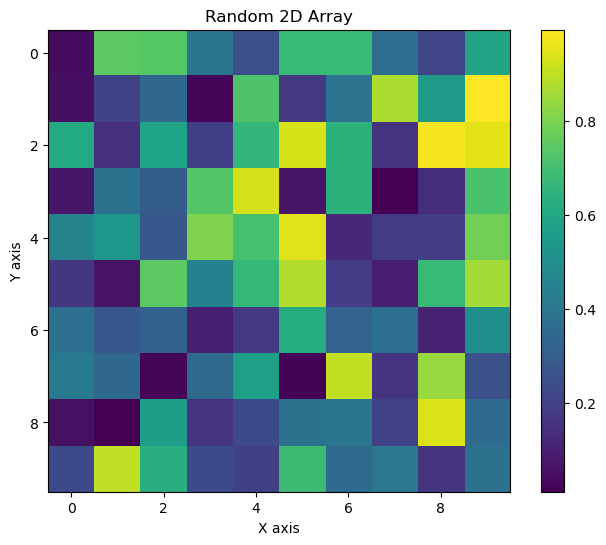

In [3]:
# my module import
from modules import *

# modules 폴더에 새모듈.py 만들면
# modules/__init__py 파일에 form .새모듈 import * 하셈
# 그리고 새모듈.py에서 from modules.새모듈 import * 하셈


In [4]:
def my_snn_system(devices = "0,1,2,3",
                    single_step = False, # True # False
                    unique_name = 'main',
                    my_seed = 42,
                    TIME = 10,
                    BATCH = 256,
                    IMAGE_SIZE = 32,
                    which_data = 'CIFAR10',
                    # CLASS_NUM = 10,
                    data_path = '/data2',
                    rate_coding = True,
    
                    lif_layer_v_init = 0.0,
                    lif_layer_v_decay = 0.6,
                    lif_layer_v_threshold = 1.2,
                    lif_layer_v_reset = 0.0,
                    lif_layer_sg_width = 1,

                    # synapse_conv_in_channels = IMAGE_PIXEL_CHANNEL,
                    synapse_conv_kernel_size = 3,
                    synapse_conv_stride = 1,
                    synapse_conv_padding = 1,
                    synapse_conv_trace_const1 = 1,
                    synapse_conv_trace_const2 = 0.6,

                    # synapse_fc_out_features = CLASS_NUM,
                    synapse_fc_trace_const1 = 1,
                    synapse_fc_trace_const2 = 0.6,

                    pre_trained = False,
                    convTrue_fcFalse = True,
                    cfg = [64, 64],
                    net_print = False, # True # False
                    weight_count_print = False, # True # False
                    pre_trained_path = "net_save/save_now_net.pth",
                    learning_rate = 0.0001,
                    epoch_num = 200,
                    verbose_interval = 100, #숫자 크게 하면 꺼짐
                    validation_interval = 10, #숫자 크게 하면 꺼짐
                    tdBN_on = False,
                    BN_on = False,

                    surrogate = 'sigmoid',

                    gradient_verbose = False,

                    BPTT_on = False,

                    optimizer_what = 'SGD', # 'SGD' 'Adam', 'RMSprop'
                    scheduler_name = 'no',
                    
                    ddp_on = True,

                    nda_net = False,
                    
                    domain_il_epoch = 0, # over 0, then domain il mode on

                    dvs_clipping = 1, 
                    dvs_duration = 10005,

                    OTTT_sWS_on = True, # True # False

                    DFA_on = False, # True # False
                    OTTT_input_trace_on = False, # True # False
                 
                    e_transport_swap = 5, # 1 이상이면 해당 숫자 에포크만큼 val_acc_best가 변화가 없으면 e_transport scheme (BP vs DFA) swap
                    e_transport_swap_tr = 0, # 1 이상이면 해당 숫자 에포크만큼 val_acc_best가 변화가 없으면 e_transport scheme (BP vs DFA) swap
                    e_transport_swap_coin = 0, # swap할 수 있는 coin 개수

                    drop_rate = 0.5, 

                    exclude_class = True, # True # False # gesture에서 10번째 클래스 제외

                    merge_polarities = True, # True # False # tonic dvs dataset 에서 polarities 합치기
                    denoise_on = True, 
                  ):
    ## hyperparameter check #############################################################
    if OTTT_sWS_on == True:
        assert BPTT_on == False and tdBN_on == False and BN_on == False
        if convTrue_fcFalse == False:
            assert single_step == True
    if single_step == True:
        assert BPTT_on == False and tdBN_on == False 
    if tdBN_on == True:
        assert BPTT_on == True
    if pre_trained == True:
        print('\n\n')
        print("Caution! pre_trained is True\n\n"*3)    
    if DFA_on == True:
        assert single_step == True and BPTT_on == False and any(isinstance(item, list) for item in cfg) == False
    if OTTT_input_trace_on == True:
        assert BPTT_on == False and single_step == True
    ######################################################################################


    ## 함수 내 모든 로컬 변수 저장 ########################################################
    hyperparameters = locals()
    hyperparameters['current epoch'] = 0
    ######################################################################################
    
    args_gpu = None
    ## DDP settting ######################################################################
    if (ddp_on == True):
        parser = argparse.ArgumentParser(description='my_snn CIFAR10 Training')

        # # local_rank는 command line에서 따로 줄 필요는 없지만, 선언은 필요
        parser.add_argument("--local_rank", default=0, type=int)

        args = parser.parse_args() # 이거 적어줘야됨. parser argument선언하고

        args.gpu = args.local_rank
        args_gpu = args.gpu
        torch.cuda.set_device(args.gpu)
        torch.distributed.init_process_group(backend="nccl", init_method="env://")
        args.world_size = torch.distributed.get_world_size()
    #######################################################################################


    ## wandb 세팅 ###################################################################
    current_time = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    if (ddp_on == True and torch.distributed.get_rank() != 0):
        wandb.finish()
    if (ddp_on == False or torch.distributed.get_rank() == 0):
        wandb.config.update(hyperparameters)
        wandb.run.name = f'lr_{learning_rate}_{unique_name}_{which_data}_tstep{TIME}'
        wandb.define_metric("summary_val_acc", summary="max")
        wandb.run.log_code(".", 
                           include_fn=lambda path: path.endswith(".py") or path.endswith(".ipynb"),
                           exclude_fn=lambda path: 'logs/' in path or 'net_save/' in path or 'result_save/' in path or 'trying/' in path or 'wandb/' in path or 'private/' in path
                           )
    ###################################################################################



    ## gpu setting ##################################################################################################################
    os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" 
    os.environ["CUDA_VISIBLE_DEVICES"]= devices
    ###################################################################################################################################


    ## seed setting ##################################################################################################################
    seed_assign(my_seed)
    ###################################################################################################################################
    

    ## data_loader 가져오기 ##################################################################################################################
    # data loader, pixel channel, class num
    train_loader, test_loader, synapse_conv_in_channels, CLASS_NUM = data_loader(
            which_data,
            data_path, 
            rate_coding, 
            BATCH, 
            IMAGE_SIZE,
            ddp_on,
            TIME,
            dvs_clipping,
            dvs_duration,
            exclude_class,
            merge_polarities,
            denoise_on, )
    synapse_fc_out_features = CLASS_NUM
    ###########################################################################################################################################

    
    ## parameter number calculator (안 중요함) ##################################################################################################################
    params_num = 0
    img_size = IMAGE_SIZE 
    bias_param = 1 # 1 or 0
    classifier_making = False
    if (convTrue_fcFalse == True):
        past_kernel = synapse_conv_in_channels
        for kernel in cfg:
            if (classifier_making == False):
                if (type(kernel) == list):
                    for residual_kernel in kernel:
                        if (residual_kernel >= 10000 and residual_kernel < 20000): # separable
                            residual_kernel -= 10000
                            params_num += (synapse_conv_kernel_size**2 + bias_param) * past_kernel
                            params_num += (1**2 * past_kernel + bias_param) * residual_kernel
                            past_kernel = residual_kernel  
                        elif (residual_kernel >= 20000 and residual_kernel < 30000): # depthwise
                            residual_kernel -= 20000
                            # 'past_kernel' should be same with 'kernel'
                            params_num += (synapse_conv_kernel_size**2 + bias_param) * past_kernel
                            past_kernel = residual_kernel  
                        else:
                            params_num += residual_kernel * ((synapse_conv_kernel_size**2) * past_kernel + bias_param)
                            past_kernel = residual_kernel
                elif (kernel == 'P' or kernel == 'M'):
                    img_size = img_size // 2
                elif (kernel == 'D'):
                    img_size = 1
                elif (kernel == 'L'):
                    classifier_making = True
                    past_kernel = past_kernel * (img_size**2)
                else:
                    if (kernel >= 10000 and kernel < 20000): # separable
                        kernel -= 10000
                        params_num += (synapse_conv_kernel_size**2 + bias_param) * past_kernel
                        params_num += (1**2 * past_kernel + bias_param) * kernel
                        past_kernel = kernel  
                    elif (kernel >= 20000 and kernel < 30000): # depthwise
                        kernel -= 20000
                        # 'past_kernel' should be same with 'kernel'
                        params_num += (synapse_conv_kernel_size**2 + bias_param) * past_kernel
                        past_kernel = kernel  
                    else:
                        params_num += kernel * (synapse_conv_kernel_size**2 * past_kernel + bias_param)
                        past_kernel = kernel    
            else: # classifier making
                params_num += (past_kernel + bias_param) * kernel
                past_kernel = kernel
        
        
        if classifier_making == False:
            past_kernel = past_kernel*img_size*img_size

        params_num += (past_kernel + bias_param) * synapse_fc_out_features
    else:
        past_in_channel = synapse_conv_in_channels*img_size*img_size
        for in_channel in cfg:
            if (type(in_channel) == list):
                for residual_in_channel in in_channel:
                    params_num += (past_in_channel + bias_param) * residual_in_channel
                    past_in_channel = residual_in_channel
            elif (in_channel == 'P' or in_channel == 'M'):
                img_size = img_size // 2
                past_in_channel = synapse_conv_in_channels*img_size*img_size
            else:
                params_num += (past_in_channel + bias_param) * in_channel
                past_in_channel = in_channel
        params_num += (past_in_channel + bias_param) * synapse_fc_out_features
    ###########################################################################################################################################


    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    ### network setting #######################################################################################################################
    if (convTrue_fcFalse == False):
        if (single_step == False):
            net = MY_SNN_FC(cfg, synapse_conv_in_channels, IMAGE_SIZE, synapse_fc_out_features,
                        synapse_fc_trace_const1, synapse_fc_trace_const2, 
                        lif_layer_v_init, lif_layer_v_decay, 
                        lif_layer_v_threshold, lif_layer_v_reset,
                        lif_layer_sg_width,
                        tdBN_on,
                        BN_on, TIME,
                        surrogate,
                        BPTT_on,
                        DFA_on,
                        drop_rate).to(device)
        else:
            net = MY_SNN_FC_sstep(cfg, synapse_conv_in_channels, IMAGE_SIZE, synapse_fc_out_features,
                        synapse_fc_trace_const1, synapse_fc_trace_const2, 
                        lif_layer_v_init, lif_layer_v_decay, 
                        lif_layer_v_threshold, lif_layer_v_reset,
                        lif_layer_sg_width,
                        tdBN_on,
                        BN_on, TIME,
                        surrogate,
                        BPTT_on,
                        DFA_on,
                        OTTT_sWS_on,
                        drop_rate).to(device)
    else:
        if (single_step == False):
            net = MY_SNN_CONV(cfg, synapse_conv_in_channels, IMAGE_SIZE,
                        synapse_conv_kernel_size, synapse_conv_stride, 
                        synapse_conv_padding, synapse_conv_trace_const1, 
                        synapse_conv_trace_const2, 
                        lif_layer_v_init, lif_layer_v_decay, 
                        lif_layer_v_threshold, lif_layer_v_reset,
                        lif_layer_sg_width,
                        synapse_fc_out_features, synapse_fc_trace_const1, synapse_fc_trace_const2,
                        tdBN_on,
                        BN_on, TIME,
                        surrogate,
                        BPTT_on,
                        OTTT_sWS_on,
                        DFA_on,
                        drop_rate).to(device)
        else:
            net = MY_SNN_CONV_sstep(cfg, synapse_conv_in_channels, IMAGE_SIZE,
                        synapse_conv_kernel_size, synapse_conv_stride, 
                        synapse_conv_padding, synapse_conv_trace_const1, 
                        synapse_conv_trace_const2, 
                        lif_layer_v_init, lif_layer_v_decay, 
                        lif_layer_v_threshold, lif_layer_v_reset,
                        lif_layer_sg_width,
                        synapse_fc_out_features, synapse_fc_trace_const1, synapse_fc_trace_const2,
                        tdBN_on,
                        BN_on, TIME,
                        surrogate,
                        BPTT_on,
                        OTTT_sWS_on,
                        DFA_on,
                        drop_rate).to(device)
    if (nda_net == True):
        net = VGG(cfg = cfg, num_classes=10, batch_norm = tdBN_on, in_c = synapse_conv_in_channels, 
                    lif_layer_v_threshold=lif_layer_v_threshold, lif_layer_v_decay=lif_layer_v_decay, lif_layer_sg_width=lif_layer_sg_width)
        net.T = TIME
    if ddp_on == False:
        net = torch.nn.DataParallel(net) 
    
    if pre_trained == True:
        net.load_state_dict(torch.load(pre_trained_path))
    
    if ddp_on == True:
        device = args.gpu
        net = net.to(args.gpu)
        net = DDP(net, delay_allreduce=True)

    net = net.to(device)
    if (net_print == True):
        if ddp_on == False or torch.distributed.get_rank() == 0:
            print(net)    
    ####################################################################################################################################
    

    ## wandb logging ###########################################
    if ddp_on == False or torch.distributed.get_rank() == 0:
        wandb.watch(net, log="all", log_freq = 10) #gradient, parameter logging해줌
    ############################################################

    ## param num and memory estimation except BN with MY own calculation some lines above ##########################################
    if ddp_on == False or torch.distributed.get_rank() == 0:
        real_param_num = sum(p.numel() for p in net.parameters() if p.requires_grad)
        if (weight_count_print == True):
            for name, param in net.named_parameters():
                if param.requires_grad:
                    print(f'Layer: {name} | Number of parameters: {param.numel()}')
        # Batch norm 있으면 아래 두 개 서로 다를 수 있음.
        # assert real_param_num == params_num, f'parameter number is not same. real_param_num: {real_param_num}, params_num: {params_num}'    
        print('='*50)
        print(f"My Num of PARAMS: {params_num:,}, system's param_num : {real_param_num:,}")
        memory = params_num / 8 / 1024 / 1024 # MB
        precision = 32
        memory = memory * precision 
        print(f"Memory: {memory:.2f}MiB at {precision}-bit")
        print('='*50)
    ##############################################################################################################################



    ## criterion ########################################## # loss 구해주는 친구
    criterion = nn.CrossEntropyLoss().to(device)
    if (OTTT_sWS_on == True):
        # criterion = nn.CrossEntropyLoss().to(device)
        criterion = lambda y_t, target_t: ((1 - 0.05) * F.cross_entropy(y_t, target_t) + 0.05 * F.mse_loss(y_t, F.one_hot(target_t, CLASS_NUM).float())) / TIME 
        if which_data == 'DVS_GESTURE':
            criterion = lambda y_t, target_t: ((1 - 0.001) * F.cross_entropy(y_t, target_t) + 0.001 * F.mse_loss(y_t, F.one_hot(target_t, CLASS_NUM).float())) / TIME 
    ####################################################
    



    ## optimizer, scheduler ########################################################################
    if(optimizer_what == 'SGD'):
        # optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
        optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0)
    elif(optimizer_what == 'Adam'):
        optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
        # optimizer = torch.optim.Adam(net.parameters(), lr=0.00001)
        # optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate/256 * BATCH, weight_decay=1e-4)
        # optimizer = optim.Adam(net.parameters(), lr=learning_rate, weight_decay=0, betas=(0.9, 0.999))
    elif(optimizer_what == 'RMSprop'):
        pass


    if (scheduler_name == 'StepLR'):
        scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
    elif (scheduler_name == 'ExponentialLR'):
        scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
    elif (scheduler_name == 'ReduceLROnPlateau'):
        scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)
    elif (scheduler_name == 'CosineAnnealingLR'):
        # scheduler = lr_scheduler.CosineAnnealingLR(optimizer, eta_min=0, T_max=50)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, eta_min=0, T_max=epoch_num)
    elif (scheduler_name == 'OneCycleLR'):
        scheduler = lr_scheduler.OneCycleLR(optimizer, max_lr=0.1, steps_per_epoch=len(train_loader), epochs=epoch_num)
    else:
        pass # 'no' scheduler
    ## optimizer, scheduler ########################################################################


    tr_acc = 0
    tr_correct = 0
    tr_total = 0
    tr_acc_best = 0
    tr_epoch_loss_temp = 0
    tr_epoch_loss= 0
    val_acc_best = 0
    val_acc_now = 0
    val_loss = 0
    elapsed_time_val = 0
    no_val_best_growth_count = 0
    no_tr_best_growth_count = 0
    iter_acc_array = np.array([])
    tr_acc_array = np.array([])
    val_acc_now_array = np.array([])
    DFA_current = DFA_on
    DFA_toggle = False
    DFA_flag = 1.0 if DFA_current == True else 0.0
    DFA_BP_toggle_trial = 0
    iter_of_val = False
    #======== EPOCH START ==========================================================================================
    for epoch in range(epoch_num):
        if (e_transport_swap > 0 or e_transport_swap_tr > 0):
            assert not (e_transport_swap > 0 and e_transport_swap_tr > 0)
            if e_transport_swap > 0 and no_val_best_growth_count == e_transport_swap:
                if DFA_BP_toggle_trial < e_transport_swap_coin:
                    net = BP_DFA_SWAP(net, convTrue_fcFalse, single_step, ddp_on, args_gpu)
                    no_val_best_growth_count = 0
                    DFA_current = not DFA_current
                    DFA_toggle = True
                    DFA_BP_toggle_trial = DFA_BP_toggle_trial + 1
            if e_transport_swap_tr > 0 and no_tr_best_growth_count == e_transport_swap_tr:
                if DFA_BP_toggle_trial < e_transport_swap_coin:
                    net = BP_DFA_SWAP(net, convTrue_fcFalse, single_step, ddp_on, args_gpu)
                    no_tr_best_growth_count = 0
                    DFA_current = not DFA_current
                    DFA_toggle = True
                    DFA_BP_toggle_trial = DFA_BP_toggle_trial + 1

        if ddp_on == False or torch.distributed.get_rank() == 0:
            # print('EPOCH', epoch)
            pass
        epoch_start_time = time.time()

        # if (domain_il_epoch>0 and which_data == 'PMNIST'):
        #     k = epoch // domain_il_epoch
        #     xtrain=data[k]['train']['x']
        #     ytrain=data[k]['train']['y']
        #     xtest =data[k]['test']['x']
        #     ytest =data[k]['test']['y']

        
        ####### iterator : input_loading & tqdm을 통한 progress_bar 생성###################
        iterator = enumerate(train_loader, 0)
        if ddp_on == False or torch.distributed.get_rank() == 0:  
            iterator = tqdm(iterator, total=len(train_loader), desc='train', dynamic_ncols=True, position=0, leave=True)
        ##################################################################################   
        
        #### validation_interval이 batch size보다 작을 시 validation_interval을 batch size로 맞춰줌#############
        validation_interval2 = validation_interval
        if (validation_interval > len(train_loader)):
            validation_interval2 = len(train_loader)
        ##################################################################################################


        ###### ITERATION START ##########################################################################################################
        for i, data in iterator:
            iter_one_train_time_start = time.time()
            net.train() # train 모드로 바꿔줘야함

            ### data loading & semi-pre-processing ################################################################################
            if len(data) == 2:
                inputs, labels = data
                # 처리 로직 작성
            elif len(data) == 3:
                inputs, labels, x_len = data
                # print('x_len',x_len)
                # mask = padded_sequence_mask(x_len)
                # max_time_step = x_len.max()
                # min_time_step = x_len.min()
            ## batch 크기 ######################################
            real_batch = labels.size(0)
            ###########################################################

            ###########################################################################################################################        
            if (which_data == 'n_tidigits'):
                inputs = inputs.permute(0, 1, 3, 2, 4)
                labels = labels[:, 0, :]
                labels = torch.argmax(labels, dim=1)
            elif (which_data == 'heidelberg'):
                inputs = inputs.view(5, 1000, 1, 700, 1)
                print("\n\n\n경고!!!! heidelberg 이거 타임스텝이랑 채널 잘 바꿔줘라!!!\n\n\n\n")
            # print('inputs',inputs.size(),'\nlabels',labels.size())
            # print(labels)
                
            if (which_data == 'DVS_CIFAR10' or which_data == 'DVS_GESTURE' or which_data == 'DVS_GESTURE_TONIC' or which_data == 'DVS_CIFAR10_2' or which_data == 'NMNIST' or which_data == 'NMNIST_TONIC' or which_data == 'N_CALTECH101' or which_data == 'n_tidigits' or which_data == 'heidelberg'):
                inputs = inputs.permute(1, 0, 2, 3, 4)
            elif rate_coding == True :
                inputs = spikegen.rate(inputs, num_steps=TIME)
            else :
                inputs = inputs.repeat(TIME, 1, 1, 1, 1)
            # inputs: [Time, Batch, Channel, Height, Width]  
            ####################################################################################################################### 
                
            
            # # dvs 데이터 시각화 코드 (확인 필요할 시 써라)
            # ##############################################################################################
            # dvs_visualization(inputs, labels, TIME, BATCH, my_seed)
            # #####################################################################################################

            ## to (device) #######################################
            inputs = inputs.to(device)
            labels = labels.to(device)
            ###########################################################


            ## gradient 초기화 #######################################
            optimizer.zero_grad()
            ###########################################################
            
            ## DVS gesture에서 other label자리 매꾸기 ###############
            if (which_data == 'DVS_GESTURE'):
                labels[labels>2] -= 1
            #######################################################         
                               
            if merge_polarities == True:
                inputs = inputs[:,:,0,:,:]

            if single_step == False:
                # net에 넣어줄때는 batch가 젤 앞 차원으로 와야함. # dataparallel때매##############################
                # inputs: [Time, Batch, Channel, Height, Width]   
                inputs = inputs.permute(1, 0, 2, 3, 4) # net에 넣어줄때는 batch가 젤 앞 차원으로 와야함. # dataparallel때매
                # inputs: [Batch, Time, Channel, Height, Width] 
                #################################################################################################
            else:
                labels = labels.repeat(TIME, 1)
                ## first input도 ottt trace 적용하기 위한 코드 (validation 시에는 필요X) ##########################
                if OTTT_input_trace_on == True:
                    spike = inputs
                    trace = torch.full_like(spike, fill_value = 0.0, dtype = torch.float, requires_grad=False)
                    inputs = []
                    for t in range(TIME):
                        trace[t] = trace[t-1]*synapse_conv_trace_const2 + spike[t]*synapse_conv_trace_const1
                        inputs += [[spike[t], trace[t]]]
                ##################################################################################################


            if single_step == False:
                ### input --> net --> output #####################################################
                outputs = net(inputs)
                ##################################################################################
                ## loss, backward ##########################################
                loss = criterion(outputs, labels)
                loss.backward()
                ############################################################
                ## weight 업데이트!! ##################################
                optimizer.step()
                ################################################################
            else:
                outputs_all = []
                loss = 0.0
                for t in range(TIME):
                    ### input[t] --> net --> output_one_time #########################################
                    outputs_one_time = net(inputs[t])
                    ##################################################################################
                    one_time_loss = criterion(outputs_one_time, labels[t].contiguous())
                    one_time_loss.backward() # one_time backward
                    loss += one_time_loss.data
                    outputs_all.append(outputs_one_time.detach())
                optimizer.step() # full step time update
                outputs_all = torch.stack(outputs_all, dim=1)
                outputs = outputs_all.mean(1) # ottt꺼 쓸때
                labels = labels[0]
                loss /= TIME
            tr_epoch_loss_temp += loss.data/len(train_loader)

            ## net 그림 출력해보기 #################################################################
            # print('시각화')
            # make_dot(outputs, params=dict(list(net.named_parameters()))).render("net_torchviz", format="png")
            # return 0
            ##################################################################################

            #### batch 어긋남 방지 ###############################################
            assert real_batch == outputs.size(0), f'batch size is not same. real_batch: {real_batch}, outputs.size(0): {outputs.size(0)}'
            #######################################################################
            

            ####### training accruacy save for print ###############################
            _, predicted = torch.max(outputs.data, 1)
            total = real_batch
            correct = (predicted == labels).sum().item()
            iter_acc = correct / total
            tr_total += total
            tr_correct += correct
            if i % verbose_interval == verbose_interval-1:
                if ddp_on == False or torch.distributed.get_rank() == 0:
                    print(f'{epoch}-{i} training acc: {100 * iter_acc:.2f}%, lr={[f"{lr}" for lr in (param_group["lr"] for param_group in optimizer.param_groups)]}, val_acc: {100 * val_acc_now:.2f}%')
            iter_acc_string = f'epoch-{epoch:<3} iter_acc:{100 * iter_acc:7.2f}%, lr={[f"{lr:9.7f}" for lr in (param_group["lr"] for param_group in optimizer.param_groups)]}'
            iter_acc_string2 = f'epoch-{epoch:<3} lr={[f"{lr:9.7f}" for lr in (param_group["lr"] for param_group in optimizer.param_groups)]}'
            ################################################################
            




            iter_one_train_time_end = time.time()
            elapsed_time = iter_one_train_time_end - iter_one_train_time_start  # 실행 시간 계산

            if (i % verbose_interval == verbose_interval-1):
                if ddp_on == False or torch.distributed.get_rank() == 0:
                    print(f"iter_one_train_time: {elapsed_time} seconds, last one_val_time: {elapsed_time_val} seconds\n")

            ##### validation ##################################################################################################################################
            if i % validation_interval2 == validation_interval2-1:
                iter_one_val_time_start = time.time()
                tr_acc = tr_correct/tr_total
                tr_correct = 0
                tr_total = 0
                val_loss = 0
                correct = 0
                total = 0
                with torch.no_grad():
                    net.eval() # eval 모드로 바꿔줘야함 
                    for data in test_loader:
                        ## data loading & semi-pre-processing ##########################################################
                        if len(data) == 2:
                            inputs, labels = data
                            # 처리 로직 작성
                        elif len(data) == 3:
                            inputs, labels, x_len = data
                            # print('x_len',x_len)
                            # mask = padded_sequence_mask(x_len)
                            # max_time_step = x_len.max()
                            # min_time_step = x_len.min()
                            # B, T, *spatial_dims = inputs.shape

                        if (which_data == 'DVS_CIFAR10' or which_data == 'DVS_GESTURE' or which_data == 'DVS_GESTURE_TONIC' or which_data == 'DVS_CIFAR10_2' or which_data == 'NMNIST' or which_data == 'NMNIST_TONIC' or which_data == 'N_CALTECH101' or which_data == 'n_tidigits' or which_data == 'heidelberg'):
                            inputs = inputs.permute(1, 0, 2, 3, 4)
                        elif rate_coding == True :
                            inputs = spikegen.rate(inputs, num_steps=TIME)
                        else :
                            inputs = inputs.repeat(TIME, 1, 1, 1, 1)
                        # inputs: [Time, Batch, Channel, Height, Width]  
                        ###################################################################################################

                        inputs = inputs.to(device)
                        labels = labels.to(device)
                        real_batch = labels.size(0)
                        
                        ## DVS gesture에서 other label자리 매꾸기 ###############
                        if (which_data == 'DVS_GESTURE'):
                            labels[labels>2] -= 1
                        #######################################################
                        
                        if merge_polarities == True:
                            inputs = inputs[:,:,0,:,:]

                        ## network 연산 시작 ############################################################################################################
                        if single_step == False:
                            outputs = net(inputs.permute(1, 0, 2, 3, 4)) #inputs: [Batch, Time, Channel, Height, Width]  
                            val_loss += criterion(outputs, labels)/len(test_loader)
                        else:
                            outputs_all = []
                            for t in range(TIME):
                                outputs = net(inputs[t])
                                val_loss_temp = criterion(outputs, labels)
                                outputs_all.append(outputs.detach())
                                val_loss += (val_loss_temp.data/TIME)/len(test_loader)
                            outputs_all = torch.stack(outputs_all, dim=1)
                            outputs = outputs_all.mean(1)
                        #################################################################################################################################

                        _, predicted = torch.max(outputs.data, 1)
                        total += real_batch
                        assert real_batch == outputs.size(0), f'batch size is not same. real_batch: {real_batch}, outputs.size(0): {outputs.size(0)}'
                        correct += (predicted == labels).sum().item()

                    val_acc_now = correct / total
                    # print(f'{epoch}-{i} validation acc: {100 * val_acc_now:.2f}%, lr={[f"{lr:.10f}" for lr in (param_group["lr"] for param_group in optimizer.param_groups)]}')

                iter_one_val_time_end = time.time()
                elapsed_time_val = iter_one_val_time_end - iter_one_val_time_start  # 실행 시간 계산
                # print(f"iter_one_val_time: {elapsed_time_val} seconds")

                # network save
                if val_acc_best < val_acc_now:
                    val_acc_best = val_acc_now
                    if ddp_on == False or torch.distributed.get_rank() == 0:
                        # wandb 키면 state_dict아닌거는 저장 안됨
                        torch.save(net.state_dict(), f"net_save/save_now_net_weights_{unique_name}.pth")
                        # torch.save(net, f"net_save/save_now_net_{unique_name}.pth")
                        # torch.save(net.module.state_dict(), f"net_save/save_now_net_weights2_{unique_name}.pth")
                        # torch.save(net.module, f"net_save/save_now_net2_{unique_name}.pth")
                    no_val_best_growth_count = 0
                else:
                    no_val_best_growth_count = no_val_best_growth_count + 1

                if tr_acc_best < tr_acc:
                    tr_acc_best = tr_acc
                    no_tr_best_growth_count = 0
                else:
                    no_tr_best_growth_count = no_tr_best_growth_count + 1

                tr_epoch_loss = tr_epoch_loss_temp
                tr_epoch_loss_temp = 0

                if DFA_toggle == True:
                    DFA_flag = 1.0 - DFA_flag
                    DFA_toggle = False

                iter_of_val = True
            ####################################################################################################################################################
            
            ## progress bar update ############################################################################################################
            if ddp_on == False or torch.distributed.get_rank() == 0:
                if iter_of_val == False:
                    iterator.set_description(f"{iter_acc_string}, iter_loss:{loss:10.6f}, val_best:{100 * val_acc_best:7.2f}%")  
                else:
                    iterator.set_description(f"{iter_acc_string2}, tr/val_loss:{tr_epoch_loss:10.6f}/{val_loss:10.6f}, tr:{100 * tr_acc:7.2f}%, val:{100 * val_acc_now:7.2f}%, val_best:{100 * val_acc_best:7.2f}%")  
                    iter_of_val = False
            ####################################################################################################################################
            
            ## wandb logging ############################################################################################################
            if ddp_on == False or torch.distributed.get_rank() == 0:
                wandb.log({"iter_acc": iter_acc})
                wandb.log({"tr_acc": tr_acc})
                wandb.log({"val_acc_now": val_acc_now})
                wandb.log({"val_acc_best": val_acc_best})
                wandb.log({"summary_val_acc": val_acc_now})
                wandb.log({"epoch": epoch})
                wandb.log({"DFA_flag": DFA_flag}) # DFA mode 바뀌자 마자 바뀌는 게 아니고 validation 한번 했을 때 바뀜.
                wandb.log({"val_loss": val_loss}) 
                wandb.log({"tr_epoch_loss": tr_epoch_loss}) 
            ####################################################################################################################################
            
            
            ## accuray 로컬에 저장 하기 위한 코드 #####################################################################################
            iter_acc_array = np.append(iter_acc_array, iter_acc)
            tr_acc_array = np.append(tr_acc_array, tr_acc)
            val_acc_now_array = np.append(val_acc_now_array, val_acc_now)
            base_name = f'{current_time}'
            ####################################################################################################################
            
            iter_acc_file_name_time = f'result_save/{base_name}_iter_acc_array_{unique_name}.npy'
            tr_acc_file_name_time = f'result_save/{base_name}_tr_acc_array_{unique_name}.npy'
            val_acc_file_name_time = f'result_save/{base_name}_val_acc_now_array_{unique_name}.npy'
            hyperparameters_file_name_time = f'result_save/{base_name}_hyperparameters_{unique_name}.json'

            hyperparameters['current epoch'] = epoch

            ### accuracy 세이브: 덮어쓰기 하기 싫으면 주석 풀어서 사용 (시간마다 새로 쓰기) 비추천 ########################
            # if ddp_on == False or torch.distributed.get_rank() == 0:
            #     np.save(iter_acc_file_name_time, iter_acc_array)
            #     np.save(tr_acc_file_name_time, iter_acc_array)
            #     np.save(val_acc_file_name_time, val_acc_now_array)
            #     with open(hyperparameters_file_name_time, 'w') as f:
            #         json.dump(hyperparameters, f, indent=4)
            #########################################################################################################

            ## accuracy 세이브 ###########################################################################################
            if ddp_on == False or torch.distributed.get_rank() == 0:
                np.save(f'result_save/iter_acc_array_{unique_name}.npy', iter_acc_array)
                np.save(f'result_save/tr_acc_array_{unique_name}.npy', tr_acc_array)
                np.save(f'result_save/val_acc_now_array_{unique_name}.npy', val_acc_now_array)
                with open(f'result_save/hyperparameters_{unique_name}.json', 'w') as f:
                    json.dump(hyperparameters, f, indent=4)
            ##########################################################################################################
        ###### ITERATION END ##########################################################################################################
                

        ## scheduler update #############################################################################
        if (scheduler_name != 'no'):
            if (scheduler_name == 'ReduceLROnPlateau'):
                scheduler.step(val_loss)
            else:
                scheduler.step()
        #################################################################################################
        
        # 실행 시간 계산
        epoch_time_end = time.time()
        # print(f"epoch_time: {epoch_time_end - epoch_start_time} seconds\n") 
    #======== EPOCH END ==========================================================================================
def my_snn_system(devices = "0,1,2,3",
                    single_step = False, # True # False
                    unique_name = 'main',
                    my_seed = 42,
                    TIME = 10,
                    BATCH = 256,
                    IMAGE_SIZE = 32,
                    which_data = 'CIFAR10',
                    # CLASS_NUM = 10,
                    data_path = '/data2',
                    rate_coding = True,
    
                    lif_layer_v_init = 0.0,
                    lif_layer_v_decay = 0.6,
                    lif_layer_v_threshold = 1.2,
                    lif_layer_v_reset = 0.0,
                    lif_layer_sg_width = 1,

                    # synapse_conv_in_channels = IMAGE_PIXEL_CHANNEL,
                    synapse_conv_kernel_size = 3,
                    synapse_conv_stride = 1,
                    synapse_conv_padding = 1,
                    synapse_conv_trace_const1 = 1,
                    synapse_conv_trace_const2 = 0.6,

                    # synapse_fc_out_features = CLASS_NUM,
                    synapse_fc_trace_const1 = 1,
                    synapse_fc_trace_const2 = 0.6,

                    pre_trained = False,
                    convTrue_fcFalse = True,
                    cfg = [64, 64],
                    net_print = False, # True # False
                    weight_count_print = False, # True # False
                    pre_trained_path = "net_save/save_now_net.pth",
                    learning_rate = 0.0001,
                    epoch_num = 200,
                    verbose_interval = 100, #숫자 크게 하면 꺼짐
                    validation_interval = 10, #숫자 크게 하면 꺼짐
                    tdBN_on = False,
                    BN_on = False,

                    surrogate = 'sigmoid',

                    gradient_verbose = False,

                    BPTT_on = False,

                    optimizer_what = 'SGD', # 'SGD' 'Adam', 'RMSprop'
                    scheduler_name = 'no',
                    
                    ddp_on = True,

                    nda_net = False,
                    
                    domain_il_epoch = 0, # over 0, then domain il mode on

                    dvs_clipping = 1, 
                    dvs_duration = 10005,

                    OTTT_sWS_on = True, # True # False

                    DFA_on = False, # True # False
                    OTTT_input_trace_on = False, # True # False
                 
                    e_transport_swap = 5, # 1 이상이면 해당 숫자 에포크만큼 val_acc_best가 변화가 없으면 e_transport scheme (BP vs DFA) swap
                    e_transport_swap_tr = 0, # 1 이상이면 해당 숫자 에포크만큼 val_acc_best가 변화가 없으면 e_transport scheme (BP vs DFA) swap
                    e_transport_swap_coin = 0, # swap할 수 있는 coin 개수

                    drop_rate = 0.5, 

                    exclude_class = True, # True # False # gesture에서 10번째 클래스 제외

                    merge_polarities = True, # True # False # tonic dvs dataset 에서 polarities 합치기
                    denoise_on = True, 
                  ):
    ## hyperparameter check #############################################################
    if OTTT_sWS_on == True:
        assert BPTT_on == False and tdBN_on == False and BN_on == False
        if convTrue_fcFalse == False:
            assert single_step == True
    if single_step == True:
        assert BPTT_on == False and tdBN_on == False 
    if tdBN_on == True:
        assert BPTT_on == True
    if pre_trained == True:
        print('\n\n')
        print("Caution! pre_trained is True\n\n"*3)    
    if DFA_on == True:
        assert single_step == True and BPTT_on == False and any(isinstance(item, list) for item in cfg) == False
    if OTTT_input_trace_on == True:
        assert BPTT_on == False and single_step == True
    ######################################################################################


    ## 함수 내 모든 로컬 변수 저장 ########################################################
    hyperparameters = locals()
    hyperparameters['current epoch'] = 0
    ######################################################################################
    
    args_gpu = None
    ## DDP settting ######################################################################
    if (ddp_on == True):
        parser = argparse.ArgumentParser(description='my_snn CIFAR10 Training')

        # # local_rank는 command line에서 따로 줄 필요는 없지만, 선언은 필요
        parser.add_argument("--local_rank", default=0, type=int)

        args = parser.parse_args() # 이거 적어줘야됨. parser argument선언하고

        args.gpu = args.local_rank
        args_gpu = args.gpu
        torch.cuda.set_device(args.gpu)
        torch.distributed.init_process_group(backend="nccl", init_method="env://")
        args.world_size = torch.distributed.get_world_size()
    #######################################################################################


    ## wandb 세팅 ###################################################################
    current_time = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    if (ddp_on == True and torch.distributed.get_rank() != 0):
        wandb.finish()
    if (ddp_on == False or torch.distributed.get_rank() == 0):
        wandb.config.update(hyperparameters)
        wandb.run.name = f'lr_{learning_rate}_{unique_name}_{which_data}_tstep{TIME}'
        wandb.define_metric("summary_val_acc", summary="max")
        wandb.run.log_code(".", 
                           include_fn=lambda path: path.endswith(".py") or path.endswith(".ipynb"),
                           exclude_fn=lambda path: 'logs/' in path or 'net_save/' in path or 'result_save/' in path or 'trying/' in path or 'wandb/' in path or 'private/' in path
                           )
    ###################################################################################



    ## gpu setting ##################################################################################################################
    os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" 
    os.environ["CUDA_VISIBLE_DEVICES"]= devices
    ###################################################################################################################################


    ## seed setting ##################################################################################################################
    seed_assign(my_seed)
    ###################################################################################################################################
    

    ## data_loader 가져오기 ##################################################################################################################
    # data loader, pixel channel, class num
    train_loader, test_loader, synapse_conv_in_channels, CLASS_NUM = data_loader(
            which_data,
            data_path, 
            rate_coding, 
            BATCH, 
            IMAGE_SIZE,
            ddp_on,
            TIME,
            dvs_clipping,
            dvs_duration,
            exclude_class,
            merge_polarities,
            denoise_on, )
    synapse_fc_out_features = CLASS_NUM
    ###########################################################################################################################################

    
    ## parameter number calculator (안 중요함) ##################################################################################################################
    params_num = 0
    img_size = IMAGE_SIZE 
    bias_param = 1 # 1 or 0
    classifier_making = False
    if (convTrue_fcFalse == True):
        past_kernel = synapse_conv_in_channels
        for kernel in cfg:
            if (classifier_making == False):
                if (type(kernel) == list):
                    for residual_kernel in kernel:
                        if (residual_kernel >= 10000 and residual_kernel < 20000): # separable
                            residual_kernel -= 10000
                            params_num += (synapse_conv_kernel_size**2 + bias_param) * past_kernel
                            params_num += (1**2 * past_kernel + bias_param) * residual_kernel
                            past_kernel = residual_kernel  
                        elif (residual_kernel >= 20000 and residual_kernel < 30000): # depthwise
                            residual_kernel -= 20000
                            # 'past_kernel' should be same with 'kernel'
                            params_num += (synapse_conv_kernel_size**2 + bias_param) * past_kernel
                            past_kernel = residual_kernel  
                        else:
                            params_num += residual_kernel * ((synapse_conv_kernel_size**2) * past_kernel + bias_param)
                            past_kernel = residual_kernel
                elif (kernel == 'P' or kernel == 'M'):
                    img_size = img_size // 2
                elif (kernel == 'D'):
                    img_size = 1
                elif (kernel == 'L'):
                    classifier_making = True
                    past_kernel = past_kernel * (img_size**2)
                else:
                    if (kernel >= 10000 and kernel < 20000): # separable
                        kernel -= 10000
                        params_num += (synapse_conv_kernel_size**2 + bias_param) * past_kernel
                        params_num += (1**2 * past_kernel + bias_param) * kernel
                        past_kernel = kernel  
                    elif (kernel >= 20000 and kernel < 30000): # depthwise
                        kernel -= 20000
                        # 'past_kernel' should be same with 'kernel'
                        params_num += (synapse_conv_kernel_size**2 + bias_param) * past_kernel
                        past_kernel = kernel  
                    else:
                        params_num += kernel * (synapse_conv_kernel_size**2 * past_kernel + bias_param)
                        past_kernel = kernel    
            else: # classifier making
                params_num += (past_kernel + bias_param) * kernel
                past_kernel = kernel
        
        
        if classifier_making == False:
            past_kernel = past_kernel*img_size*img_size

        params_num += (past_kernel + bias_param) * synapse_fc_out_features
    else:
        past_in_channel = synapse_conv_in_channels*img_size*img_size
        for in_channel in cfg:
            if (type(in_channel) == list):
                for residual_in_channel in in_channel:
                    params_num += (past_in_channel + bias_param) * residual_in_channel
                    past_in_channel = residual_in_channel
            elif (in_channel == 'P' or in_channel == 'M'):
                img_size = img_size // 2
                past_in_channel = synapse_conv_in_channels*img_size*img_size
            else:
                params_num += (past_in_channel + bias_param) * in_channel
                past_in_channel = in_channel
        params_num += (past_in_channel + bias_param) * synapse_fc_out_features
    ###########################################################################################################################################


    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    ### network setting #######################################################################################################################
    if (convTrue_fcFalse == False):
        if (single_step == False):
            net = MY_SNN_FC(cfg, synapse_conv_in_channels, IMAGE_SIZE, synapse_fc_out_features,
                        synapse_fc_trace_const1, synapse_fc_trace_const2, 
                        lif_layer_v_init, lif_layer_v_decay, 
                        lif_layer_v_threshold, lif_layer_v_reset,
                        lif_layer_sg_width,
                        tdBN_on,
                        BN_on, TIME,
                        surrogate,
                        BPTT_on,
                        DFA_on,
                        drop_rate).to(device)
        else:
            net = MY_SNN_FC_sstep(cfg, synapse_conv_in_channels, IMAGE_SIZE, synapse_fc_out_features,
                        synapse_fc_trace_const1, synapse_fc_trace_const2, 
                        lif_layer_v_init, lif_layer_v_decay, 
                        lif_layer_v_threshold, lif_layer_v_reset,
                        lif_layer_sg_width,
                        tdBN_on,
                        BN_on, TIME,
                        surrogate,
                        BPTT_on,
                        DFA_on,
                        OTTT_sWS_on,
                        drop_rate).to(device)
    else:
        if (single_step == False):
            net = MY_SNN_CONV(cfg, synapse_conv_in_channels, IMAGE_SIZE,
                        synapse_conv_kernel_size, synapse_conv_stride, 
                        synapse_conv_padding, synapse_conv_trace_const1, 
                        synapse_conv_trace_const2, 
                        lif_layer_v_init, lif_layer_v_decay, 
                        lif_layer_v_threshold, lif_layer_v_reset,
                        lif_layer_sg_width,
                        synapse_fc_out_features, synapse_fc_trace_const1, synapse_fc_trace_const2,
                        tdBN_on,
                        BN_on, TIME,
                        surrogate,
                        BPTT_on,
                        OTTT_sWS_on,
                        DFA_on,
                        drop_rate).to(device)
        else:
            net = MY_SNN_CONV_sstep(cfg, synapse_conv_in_channels, IMAGE_SIZE,
                        synapse_conv_kernel_size, synapse_conv_stride, 
                        synapse_conv_padding, synapse_conv_trace_const1, 
                        synapse_conv_trace_const2, 
                        lif_layer_v_init, lif_layer_v_decay, 
                        lif_layer_v_threshold, lif_layer_v_reset,
                        lif_layer_sg_width,
                        synapse_fc_out_features, synapse_fc_trace_const1, synapse_fc_trace_const2,
                        tdBN_on,
                        BN_on, TIME,
                        surrogate,
                        BPTT_on,
                        OTTT_sWS_on,
                        DFA_on,
                        drop_rate).to(device)
    if (nda_net == True):
        net = VGG(cfg = cfg, num_classes=10, batch_norm = tdBN_on, in_c = synapse_conv_in_channels, 
                    lif_layer_v_threshold=lif_layer_v_threshold, lif_layer_v_decay=lif_layer_v_decay, lif_layer_sg_width=lif_layer_sg_width)
        net.T = TIME
    if ddp_on == False:
        net = torch.nn.DataParallel(net) 
    
    if pre_trained == True:
        net.load_state_dict(torch.load(pre_trained_path))
    
    if ddp_on == True:
        device = args.gpu
        net = net.to(args.gpu)
        net = DDP(net, delay_allreduce=True)

    net = net.to(device)
    if (net_print == True):
        if ddp_on == False or torch.distributed.get_rank() == 0:
            print(net)    
    ####################################################################################################################################
    

    ## wandb logging ###########################################
    if ddp_on == False or torch.distributed.get_rank() == 0:
        wandb.watch(net, log="all", log_freq = 10) #gradient, parameter logging해줌
    ############################################################

    ## param num and memory estimation except BN with MY own calculation some lines above ##########################################
    if ddp_on == False or torch.distributed.get_rank() == 0:
        real_param_num = sum(p.numel() for p in net.parameters() if p.requires_grad)
        if (weight_count_print == True):
            for name, param in net.named_parameters():
                if param.requires_grad:
                    print(f'Layer: {name} | Number of parameters: {param.numel()}')
        # Batch norm 있으면 아래 두 개 서로 다를 수 있음.
        # assert real_param_num == params_num, f'parameter number is not same. real_param_num: {real_param_num}, params_num: {params_num}'    
        print('='*50)
        print(f"My Num of PARAMS: {params_num:,}, system's param_num : {real_param_num:,}")
        memory = params_num / 8 / 1024 / 1024 # MB
        precision = 32
        memory = memory * precision 
        print(f"Memory: {memory:.2f}MiB at {precision}-bit")
        print('='*50)
    ##############################################################################################################################



    ## criterion ########################################## # loss 구해주는 친구
    criterion = nn.CrossEntropyLoss().to(device)
    if (OTTT_sWS_on == True):
        # criterion = nn.CrossEntropyLoss().to(device)
        criterion = lambda y_t, target_t: ((1 - 0.05) * F.cross_entropy(y_t, target_t) + 0.05 * F.mse_loss(y_t, F.one_hot(target_t, CLASS_NUM).float())) / TIME 
        if which_data == 'DVS_GESTURE':
            criterion = lambda y_t, target_t: ((1 - 0.001) * F.cross_entropy(y_t, target_t) + 0.001 * F.mse_loss(y_t, F.one_hot(target_t, CLASS_NUM).float())) / TIME 
    ####################################################
    



    ## optimizer, scheduler ########################################################################
    if(optimizer_what == 'SGD'):
        # optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
        optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0)
    elif(optimizer_what == 'Adam'):
        optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
        # optimizer = torch.optim.Adam(net.parameters(), lr=0.00001)
        # optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate/256 * BATCH, weight_decay=1e-4)
        # optimizer = optim.Adam(net.parameters(), lr=learning_rate, weight_decay=0, betas=(0.9, 0.999))
    elif(optimizer_what == 'RMSprop'):
        pass


    if (scheduler_name == 'StepLR'):
        scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
    elif (scheduler_name == 'ExponentialLR'):
        scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
    elif (scheduler_name == 'ReduceLROnPlateau'):
        scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)
    elif (scheduler_name == 'CosineAnnealingLR'):
        # scheduler = lr_scheduler.CosineAnnealingLR(optimizer, eta_min=0, T_max=50)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, eta_min=0, T_max=epoch_num)
    elif (scheduler_name == 'OneCycleLR'):
        scheduler = lr_scheduler.OneCycleLR(optimizer, max_lr=0.1, steps_per_epoch=len(train_loader), epochs=epoch_num)
    else:
        pass # 'no' scheduler
    ## optimizer, scheduler ########################################################################


    tr_acc = 0
    tr_correct = 0
    tr_total = 0
    tr_acc_best = 0
    tr_epoch_loss_temp = 0
    tr_epoch_loss= 0
    val_acc_best = 0
    val_acc_now = 0
    val_loss = 0
    elapsed_time_val = 0
    no_val_best_growth_count = 0
    no_tr_best_growth_count = 0
    iter_acc_array = np.array([])
    tr_acc_array = np.array([])
    val_acc_now_array = np.array([])
    DFA_current = DFA_on
    DFA_toggle = False
    DFA_flag = 1.0 if DFA_current == True else 0.0
    DFA_BP_toggle_trial = 0
    iter_of_val = False
    #======== EPOCH START ==========================================================================================
    for epoch in range(epoch_num):
        if (e_transport_swap > 0 or e_transport_swap_tr > 0):
            assert not (e_transport_swap > 0 and e_transport_swap_tr > 0)
            if e_transport_swap > 0 and no_val_best_growth_count == e_transport_swap:
                if DFA_BP_toggle_trial < e_transport_swap_coin:
                    net = BP_DFA_SWAP(net, convTrue_fcFalse, single_step, ddp_on, args_gpu)
                    no_val_best_growth_count = 0
                    DFA_current = not DFA_current
                    DFA_toggle = True
                    DFA_BP_toggle_trial = DFA_BP_toggle_trial + 1
            if e_transport_swap_tr > 0 and no_tr_best_growth_count == e_transport_swap_tr:
                if DFA_BP_toggle_trial < e_transport_swap_coin:
                    net = BP_DFA_SWAP(net, convTrue_fcFalse, single_step, ddp_on, args_gpu)
                    no_tr_best_growth_count = 0
                    DFA_current = not DFA_current
                    DFA_toggle = True
                    DFA_BP_toggle_trial = DFA_BP_toggle_trial + 1

        if ddp_on == False or torch.distributed.get_rank() == 0:
            # print('EPOCH', epoch)
            pass
        epoch_start_time = time.time()

        # if (domain_il_epoch>0 and which_data == 'PMNIST'):
        #     k = epoch // domain_il_epoch
        #     xtrain=data[k]['train']['x']
        #     ytrain=data[k]['train']['y']
        #     xtest =data[k]['test']['x']
        #     ytest =data[k]['test']['y']

        
        ####### iterator : input_loading & tqdm을 통한 progress_bar 생성###################
        iterator = enumerate(train_loader, 0)
        if ddp_on == False or torch.distributed.get_rank() == 0:  
            iterator = tqdm(iterator, total=len(train_loader), desc='train', dynamic_ncols=True, position=0, leave=True)
        ##################################################################################   
        
        #### validation_interval이 batch size보다 작을 시 validation_interval을 batch size로 맞춰줌#############
        validation_interval2 = validation_interval
        if (validation_interval > len(train_loader)):
            validation_interval2 = len(train_loader)
        ##################################################################################################


        ###### ITERATION START ##########################################################################################################
        for i, data in iterator:
            iter_one_train_time_start = time.time()
            net.train() # train 모드로 바꿔줘야함

            ### data loading & semi-pre-processing ################################################################################
            if len(data) == 2:
                inputs, labels = data
                # 처리 로직 작성
            elif len(data) == 3:
                inputs, labels, x_len = data
                # print('x_len',x_len)
                # mask = padded_sequence_mask(x_len)
                # max_time_step = x_len.max()
                # min_time_step = x_len.min()
            ## batch 크기 ######################################
            real_batch = labels.size(0)
            ###########################################################

            ###########################################################################################################################        
            if (which_data == 'n_tidigits'):
                inputs = inputs.permute(0, 1, 3, 2, 4)
                labels = labels[:, 0, :]
                labels = torch.argmax(labels, dim=1)
            elif (which_data == 'heidelberg'):
                inputs = inputs.view(5, 1000, 1, 700, 1)
                print("\n\n\n경고!!!! heidelberg 이거 타임스텝이랑 채널 잘 바꿔줘라!!!\n\n\n\n")
            # print('inputs',inputs.size(),'\nlabels',labels.size())
            # print(labels)
                
            if (which_data == 'DVS_CIFAR10' or which_data == 'DVS_GESTURE' or which_data == 'DVS_GESTURE_TONIC' or which_data == 'DVS_CIFAR10_2' or which_data == 'NMNIST' or which_data == 'NMNIST_TONIC' or which_data == 'N_CALTECH101' or which_data == 'n_tidigits' or which_data == 'heidelberg'):
                inputs = inputs.permute(1, 0, 2, 3, 4)
            elif rate_coding == True :
                inputs = spikegen.rate(inputs, num_steps=TIME)
            else :
                inputs = inputs.repeat(TIME, 1, 1, 1, 1)
            # inputs: [Time, Batch, Channel, Height, Width]  
            ####################################################################################################################### 
                
            
            # # dvs 데이터 시각화 코드 (확인 필요할 시 써라)
            # ##############################################################################################
            # dvs_visualization(inputs, labels, TIME, BATCH, my_seed)
            # #####################################################################################################

            ## to (device) #######################################
            inputs = inputs.to(device)
            labels = labels.to(device)
            ###########################################################


            ## gradient 초기화 #######################################
            optimizer.zero_grad()
            ###########################################################
            
            ## DVS gesture에서 other label자리 매꾸기 ###############
            if (which_data == 'DVS_GESTURE'):
                labels[labels>2] -= 1
            #######################################################         
                               
            if merge_polarities == True:
                inputs = inputs[:,:,0,:,:]

            if single_step == False:
                # net에 넣어줄때는 batch가 젤 앞 차원으로 와야함. # dataparallel때매##############################
                # inputs: [Time, Batch, Channel, Height, Width]   
                inputs = inputs.permute(1, 0, 2, 3, 4) # net에 넣어줄때는 batch가 젤 앞 차원으로 와야함. # dataparallel때매
                # inputs: [Batch, Time, Channel, Height, Width] 
                #################################################################################################
            else:
                labels = labels.repeat(TIME, 1)
                ## first input도 ottt trace 적용하기 위한 코드 (validation 시에는 필요X) ##########################
                if OTTT_input_trace_on == True:
                    spike = inputs
                    trace = torch.full_like(spike, fill_value = 0.0, dtype = torch.float, requires_grad=False)
                    inputs = []
                    for t in range(TIME):
                        trace[t] = trace[t-1]*synapse_conv_trace_const2 + spike[t]*synapse_conv_trace_const1
                        inputs += [[spike[t], trace[t]]]
                ##################################################################################################


            if single_step == False:
                ### input --> net --> output #####################################################
                outputs = net(inputs)
                ##################################################################################
                ## loss, backward ##########################################
                loss = criterion(outputs, labels)
                loss.backward()
                ############################################################
                ## weight 업데이트!! ##################################
                optimizer.step()
                ################################################################
            else:
                outputs_all = []
                loss = 0.0
                for t in range(TIME):
                    ### input[t] --> net --> output_one_time #########################################
                    outputs_one_time = net(inputs[t])
                    ##################################################################################
                    one_time_loss = criterion(outputs_one_time, labels[t].contiguous())
                    one_time_loss.backward() # one_time backward
                    loss += one_time_loss.data
                    outputs_all.append(outputs_one_time.detach())
                optimizer.step() # full step time update
                outputs_all = torch.stack(outputs_all, dim=1)
                outputs = outputs_all.mean(1) # ottt꺼 쓸때
                labels = labels[0]
                loss /= TIME
            tr_epoch_loss_temp += loss.data/len(train_loader)

            ## net 그림 출력해보기 #################################################################
            # print('시각화')
            # make_dot(outputs, params=dict(list(net.named_parameters()))).render("net_torchviz", format="png")
            # return 0
            ##################################################################################

            #### batch 어긋남 방지 ###############################################
            assert real_batch == outputs.size(0), f'batch size is not same. real_batch: {real_batch}, outputs.size(0): {outputs.size(0)}'
            #######################################################################
            

            ####### training accruacy save for print ###############################
            _, predicted = torch.max(outputs.data, 1)
            total = real_batch
            correct = (predicted == labels).sum().item()
            iter_acc = correct / total
            tr_total += total
            tr_correct += correct
            if i % verbose_interval == verbose_interval-1:
                if ddp_on == False or torch.distributed.get_rank() == 0:
                    print(f'{epoch}-{i} training acc: {100 * iter_acc:.2f}%, lr={[f"{lr}" for lr in (param_group["lr"] for param_group in optimizer.param_groups)]}, val_acc: {100 * val_acc_now:.2f}%')
            iter_acc_string = f'epoch-{epoch:<3} iter_acc:{100 * iter_acc:7.2f}%, lr={[f"{lr:9.7f}" for lr in (param_group["lr"] for param_group in optimizer.param_groups)]}'
            iter_acc_string2 = f'epoch-{epoch:<3} lr={[f"{lr:9.7f}" for lr in (param_group["lr"] for param_group in optimizer.param_groups)]}'
            ################################################################
            




            iter_one_train_time_end = time.time()
            elapsed_time = iter_one_train_time_end - iter_one_train_time_start  # 실행 시간 계산

            if (i % verbose_interval == verbose_interval-1):
                if ddp_on == False or torch.distributed.get_rank() == 0:
                    print(f"iter_one_train_time: {elapsed_time} seconds, last one_val_time: {elapsed_time_val} seconds\n")

            ##### validation ##################################################################################################################################
            if i % validation_interval2 == validation_interval2-1:
                iter_one_val_time_start = time.time()
                tr_acc = tr_correct/tr_total
                tr_correct = 0
                tr_total = 0
                val_loss = 0
                correct = 0
                total = 0
                with torch.no_grad():
                    net.eval() # eval 모드로 바꿔줘야함 
                    for data in test_loader:
                        ## data loading & semi-pre-processing ##########################################################
                        if len(data) == 2:
                            inputs, labels = data
                            # 처리 로직 작성
                        elif len(data) == 3:
                            inputs, labels, x_len = data
                            # print('x_len',x_len)
                            # mask = padded_sequence_mask(x_len)
                            # max_time_step = x_len.max()
                            # min_time_step = x_len.min()
                            # B, T, *spatial_dims = inputs.shape

                        if (which_data == 'DVS_CIFAR10' or which_data == 'DVS_GESTURE' or which_data == 'DVS_GESTURE_TONIC' or which_data == 'DVS_CIFAR10_2' or which_data == 'NMNIST' or which_data == 'NMNIST_TONIC' or which_data == 'N_CALTECH101' or which_data == 'n_tidigits' or which_data == 'heidelberg'):
                            inputs = inputs.permute(1, 0, 2, 3, 4)
                        elif rate_coding == True :
                            inputs = spikegen.rate(inputs, num_steps=TIME)
                        else :
                            inputs = inputs.repeat(TIME, 1, 1, 1, 1)
                        # inputs: [Time, Batch, Channel, Height, Width]  
                        ###################################################################################################

                        inputs = inputs.to(device)
                        labels = labels.to(device)
                        real_batch = labels.size(0)
                        
                        ## DVS gesture에서 other label자리 매꾸기 ###############
                        if (which_data == 'DVS_GESTURE'):
                            labels[labels>2] -= 1
                        #######################################################
                        
                        if merge_polarities == True:
                            inputs = inputs[:,:,0,:,:]

                        ## network 연산 시작 ############################################################################################################
                        if single_step == False:
                            outputs = net(inputs.permute(1, 0, 2, 3, 4)) #inputs: [Batch, Time, Channel, Height, Width]  
                            val_loss += criterion(outputs, labels)/len(test_loader)
                        else:
                            outputs_all = []
                            for t in range(TIME):
                                outputs = net(inputs[t])
                                val_loss_temp = criterion(outputs, labels)
                                outputs_all.append(outputs.detach())
                                val_loss += (val_loss_temp.data/TIME)/len(test_loader)
                            outputs_all = torch.stack(outputs_all, dim=1)
                            outputs = outputs_all.mean(1)
                        #################################################################################################################################

                        _, predicted = torch.max(outputs.data, 1)
                        total += real_batch
                        assert real_batch == outputs.size(0), f'batch size is not same. real_batch: {real_batch}, outputs.size(0): {outputs.size(0)}'
                        correct += (predicted == labels).sum().item()

                    val_acc_now = correct / total
                    # print(f'{epoch}-{i} validation acc: {100 * val_acc_now:.2f}%, lr={[f"{lr:.10f}" for lr in (param_group["lr"] for param_group in optimizer.param_groups)]}')

                iter_one_val_time_end = time.time()
                elapsed_time_val = iter_one_val_time_end - iter_one_val_time_start  # 실행 시간 계산
                # print(f"iter_one_val_time: {elapsed_time_val} seconds")

                # network save
                if val_acc_best < val_acc_now:
                    val_acc_best = val_acc_now
                    if ddp_on == False or torch.distributed.get_rank() == 0:
                        # wandb 키면 state_dict아닌거는 저장 안됨
                        torch.save(net.state_dict(), f"net_save/save_now_net_weights_{unique_name}.pth")
                        # torch.save(net, f"net_save/save_now_net_{unique_name}.pth")
                        # torch.save(net.module.state_dict(), f"net_save/save_now_net_weights2_{unique_name}.pth")
                        # torch.save(net.module, f"net_save/save_now_net2_{unique_name}.pth")
                    no_val_best_growth_count = 0
                else:
                    no_val_best_growth_count = no_val_best_growth_count + 1

                if tr_acc_best < tr_acc:
                    tr_acc_best = tr_acc
                    no_tr_best_growth_count = 0
                else:
                    no_tr_best_growth_count = no_tr_best_growth_count + 1

                tr_epoch_loss = tr_epoch_loss_temp
                tr_epoch_loss_temp = 0

                if DFA_toggle == True:
                    DFA_flag = 1.0 - DFA_flag
                    DFA_toggle = False

                iter_of_val = True
            ####################################################################################################################################################
            
            ## progress bar update ############################################################################################################
            if ddp_on == False or torch.distributed.get_rank() == 0:
                if iter_of_val == False:
                    iterator.set_description(f"{iter_acc_string}, iter_loss:{loss:10.6f}, val_best:{100 * val_acc_best:7.2f}%")  
                else:
                    iterator.set_description(f"{iter_acc_string2}, tr/val_loss:{tr_epoch_loss:10.6f}/{val_loss:10.6f}, tr:{100 * tr_acc:7.2f}%, val:{100 * val_acc_now:7.2f}%, val_best:{100 * val_acc_best:7.2f}%")  
                    iter_of_val = False
            ####################################################################################################################################
            
            ## wandb logging ############################################################################################################
            if ddp_on == False or torch.distributed.get_rank() == 0:
                wandb.log({"iter_acc": iter_acc})
                wandb.log({"tr_acc": tr_acc})
                wandb.log({"val_acc_now": val_acc_now})
                wandb.log({"val_acc_best": val_acc_best})
                wandb.log({"summary_val_acc": val_acc_now})
                wandb.log({"epoch": epoch})
                wandb.log({"DFA_flag": DFA_flag}) # DFA mode 바뀌자 마자 바뀌는 게 아니고 validation 한번 했을 때 바뀜.
                wandb.log({"val_loss": val_loss}) 
                wandb.log({"tr_epoch_loss": tr_epoch_loss}) 
            ####################################################################################################################################
            
            
            ## accuray 로컬에 저장 하기 위한 코드 #####################################################################################
            iter_acc_array = np.append(iter_acc_array, iter_acc)
            tr_acc_array = np.append(tr_acc_array, tr_acc)
            val_acc_now_array = np.append(val_acc_now_array, val_acc_now)
            base_name = f'{current_time}'
            ####################################################################################################################
            
            iter_acc_file_name_time = f'result_save/{base_name}_iter_acc_array_{unique_name}.npy'
            tr_acc_file_name_time = f'result_save/{base_name}_tr_acc_array_{unique_name}.npy'
            val_acc_file_name_time = f'result_save/{base_name}_val_acc_now_array_{unique_name}.npy'
            hyperparameters_file_name_time = f'result_save/{base_name}_hyperparameters_{unique_name}.json'

            hyperparameters['current epoch'] = epoch

            ### accuracy 세이브: 덮어쓰기 하기 싫으면 주석 풀어서 사용 (시간마다 새로 쓰기) 비추천 ########################
            # if ddp_on == False or torch.distributed.get_rank() == 0:
            #     np.save(iter_acc_file_name_time, iter_acc_array)
            #     np.save(tr_acc_file_name_time, iter_acc_array)
            #     np.save(val_acc_file_name_time, val_acc_now_array)
            #     with open(hyperparameters_file_name_time, 'w') as f:
            #         json.dump(hyperparameters, f, indent=4)
            #########################################################################################################

            ## accuracy 세이브 ###########################################################################################
            if ddp_on == False or torch.distributed.get_rank() == 0:
                np.save(f'result_save/iter_acc_array_{unique_name}.npy', iter_acc_array)
                np.save(f'result_save/tr_acc_array_{unique_name}.npy', tr_acc_array)
                np.save(f'result_save/val_acc_now_array_{unique_name}.npy', val_acc_now_array)
                with open(f'result_save/hyperparameters_{unique_name}.json', 'w') as f:
                    json.dump(hyperparameters, f, indent=4)
            ##########################################################################################################
        ###### ITERATION END ##########################################################################################################
                

        ## scheduler update #############################################################################
        if (scheduler_name != 'no'):
            if (scheduler_name == 'ReduceLROnPlateau'):
                scheduler.step(val_loss)
            else:
                scheduler.step()
        #################################################################################################
        
        # 실행 시간 계산
        epoch_time_end = time.time()
        # print(f"epoch_time: {epoch_time_end - epoch_start_time} seconds\n") 
    #======== EPOCH END ==========================================================================================


In [5]:
# ### my_snn control board (Gesture) ########################
# decay = 0.25 # 0.875 0.25 0.125 0.75 0.5
# # nda 0.25 # ottt 0.5
# const2 = False # trace 할거면 True, 안할거면 False

# unique_name = 'main' ## 이거 설정하면 새로운 경로에 모두 save
# run_name = 'main' ## 이거 설정하면 새로운 경로에 모두 save

# if const2 == True:
#     const2 = decay
# else:
#     const2 = 0.0

# wandb.init(project= f'my_snn {unique_name}',save_code=True)

# my_snn_system(  devices = "2",
#                 single_step = True, # True # False
#                 unique_name = run_name,
#                 my_seed = 42,
#                 TIME = 10 , # dvscifar 10 # ottt 6 or 10 # nda 10  # 제작하는 dvs에서 TIME넘거나 적으면 자르거나 PADDING함
#                 BATCH = 16, # batch norm 할거면 2이상으로 해야함   # nda 256   #  ottt 128
#                 IMAGE_SIZE = 128, # dvscifar 48 # MNIST 28 # CIFAR10 32 # PMNIST 28 #NMNIST 34 # GESTURE 128
#                 # dvsgesture 128, dvs_cifar2 128, nmnist 34, n_caltech101 180,240, n_tidigits 64, heidelberg 700, 
#                 #pmnist는 28로 해야 됨. 나머지는 바꿔도 돌아는 감.

#                 # DVS_CIFAR10 할거면 time 10으로 해라
#                 which_data = 'DVS_GESTURE_TONIC',
# # 'CIFAR100' 'CIFAR10' 'MNIST' 'FASHION_MNIST' 'DVS_CIFAR10' 'PMNIST'아직
# # 'DVS_GESTURE', 'DVS_GESTURE_TONIC','DVS_CIFAR10_2','NMNIST','NMNIST_TONIC','N_CALTECH101','n_tidigits','heidelberg'
#                 # CLASS_NUM = 10,
#                 data_path = '/data2', # YOU NEED TO CHANGE THIS
#                 rate_coding = False, # True # False
#                 lif_layer_v_init = 0.0,
#                 lif_layer_v_decay = decay,
#                 lif_layer_v_threshold = 1.3102821334243646,  # 10000이상으로 하면 NDA LIF 씀. #nda 0.5  #ottt 1.0
#                 lif_layer_v_reset = 0, # 10000이상은 hardreset (내 LIF쓰기는 함 ㅇㅇ)
#                 lif_layer_sg_width = 2.570969004857107, # sigmoid류에서는 alpha값 4.0, rectangle류에서는 width값 0.5

#                 # synapse_conv_in_channels = IMAGE_PIXEL_CHANNEL,
#                 synapse_conv_kernel_size = 3,
#                 synapse_conv_stride = 1,
#                 synapse_conv_padding = 1,
#                 synapse_conv_trace_const1 = 1, # 현재 trace구할 때 현재 spike에 곱해지는 상수. 걍 1로 두셈.
#                 synapse_conv_trace_const2 = const2, # 현재 trace구할 때 직전 trace에 곱해지는 상수. lif_layer_v_decay와 같게 할 것을 추천

#                 # synapse_fc_out_features = CLASS_NUM,
#                 synapse_fc_trace_const1 = 1, # 현재 trace구할 때 현재 spike에 곱해지는 상수. 걍 1로 두셈.
#                 synapse_fc_trace_const2 = const2, # 현재 trace구할 때 직전 trace에 곱해지는 상수. lif_layer_v_decay와 같게 할 것을 추천

#                 pre_trained = False, # True # False
#                 convTrue_fcFalse = False, # True # False

#                 # 'P' for average pooling, 'D' for (1,1) aver pooling, 'M' for maxpooling, 'L' for linear classifier, [  ] for residual block
#                 # conv에서 10000 이상은 depth-wise separable (BPTT만 지원), 20000이상은 depth-wise (BPTT만 지원)
#                 # cfg = [64, 64],
#                 # cfg = [64, 124, 64, 124],
#                 # cfg = ['M','M',512], 
#                 # cfg = [512], 
#                 # cfg = ['M', 'M', 64, 128, 'P', 128, 'P'], 
#                 # cfg = ['M','M',512],
#                 cfg = ['M','M',200,200],
#                 # cfg = ['M','M',200,200,200],
#                 # cfg = ['M','M',1024,512,256,128,64],
#                 # cfg = [200,200],
#                 # cfg = [12], #fc
#                 # cfg = [12, 'M', 48, 'M', 12], 
#                 # cfg = [64,[64,64],64], # 끝에 linear classifier 하나 자동으로 붙습니다
#                 # cfg = [64, 128, 'P', 256, 256, 'P', 512, 512, 'P', 512, 512, 'D'], #ottt
#                 # cfg = [64, 128, 'P', 256, 256, 'P', 512, 512, 'P', 512, 512], 
#                 # cfg = [64, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512], 
#                 # cfg = [64, 'P', 128, 'P', 256, 256, 'P', 512, 512, 512, 512, 'D'], # nda
#                 # cfg = [64, 'P', 128, 'P', 256, 256, 'P', 512, 512, 512, 512], # nda 128pixel
#                 # cfg = [64, 'P', 128, 'P', 256, 256, 'P', 512, 512, 512, 512, 'L', 4096, 4096],
#                 # cfg = [20001,10001], # depthwise, separable
#                 # cfg = [64,20064,10001], # vanilla conv, depthwise, separable
#                 # cfg = [8, 'P', 8, 'P', 8, 'P', 8,'P', 8, 'P'],
#                 # cfg = [],        
                
#                 net_print = True, # True # False # True로 하길 추천
#                 weight_count_print = False, # True # False
                
#                 pre_trained_path = f"net_save/save_now_net_weights_{unique_name}.pth",
#                 learning_rate = 0.01, #0.1 bptt, #0.01 ottt, # default 0.001  # ottt 0.1 # nda 0.001 # 0.00936191669529645
#                 epoch_num = 60,
#                 verbose_interval = 999999999, #이거 걍 건들지마셈 #숫자 크게 하면 꺼짐 #걍 중간중간 iter에서 끊어서 출력
#                 validation_interval =  999999999,#999999999, #이거 걍 건들지마셈 #숫자 크게 하면 에포크 마지막 iter 때 val 함

#                 tdBN_on = False,  # True # False
#                 BN_on = False,  # True # False
                
#                 surrogate = 'hard_sigmoid', # 'sigmoid' 'rectangle' 'rough_rectangle' 'hard_sigmoid'
                
#                 gradient_verbose = False,  # True # False  # weight gradient 각 layer마다 띄워줌

#                 BPTT_on = False,  # True # False # True이면 BPTT, False이면 OTTT  # depthwise, separable은 BPTT만 가능
#                 optimizer_what = 'SGD', # 'SGD' 'Adam', 'RMSprop'
#                 scheduler_name = 'CosineAnnealingLR', # 'no' 'StepLR' 'ExponentialLR' 'ReduceLROnPlateau' 'CosineAnnealingLR' 'OneCycleLR'
                
#                 ddp_on = False,   # True # False 
#                 # 지원 DATASET: cifar10, mnist

#                 nda_net = False,   # True # False

#                 domain_il_epoch = 0, # over 0, then domain il mode on # pmnist 쓸거면 HLOP 코드보고 더 디벨롭하셈. 지금 개발 hold함.
                
#                 dvs_clipping = 2, # 숫자만큼 크면 spike 아니면 걍 0
#                 # gesture, cifar-dvs2, nmnist, ncaltech101

#                 dvs_duration = 100_000, # 0 아니면 time sampling # dvs number sampling OR time sampling # gesture, cifar-dvs2, nmnist, ncaltech101
#                 # 있는 데이터들 #gesture 100_000 25_000 10_000 1_000 1_000_000 #nmnist 10000 #nmnist_tonic 10_000 25_000
#                 # 한 숫자가 1us인듯 (spikingjelly코드에서)
#                 # 한 장에 50 timestep만 생산함. 싫으면 my_snn/trying/spikingjelly_dvsgesture의__init__.py 를 참고해봐

#                 OTTT_sWS_on = False, # True # False # BPTT끄고, CONV에만 적용됨.

#                 DFA_on = False, # True # False # residual은 dfa지원안함.
#                 OTTT_input_trace_on = False, # True # False # 맨 처음 input에 trace 적용
                 
#                 e_transport_swap = 0, # 1 이상이면 해당 숫자 에포크만큼 val_acc_best가 변화가 없으면 e_transport scheme (BP vs DFA) swap
#                 e_transport_swap_tr = 0, # 1 이상이면 해당 숫자 에포크만큼 tr_acc_best가 변화가 없으면 e_transport scheme (BP vs DFA) swap
#                 e_transport_swap_coin = 1, # swap할 수 있는 coin 개수

#                 drop_rate = 0, # drop_rate만큼 0으로 만듦. ex) 0.2면 activation의 20%를 0으로 만듦.

#                 exclude_class = True, # True # False # gesture에서 10번째 클래스 제외

#                 merge_polarities = False, # True # False # tonic dvs dataset 에서 polarities 합치기
#                 ) 
# # sigmoid와 BN이 있어야 잘된다.
# # average pooling  
# # 이 낫다. 
 
# # nda에서는 decay = 0.25, threshold = 0.5, width =1, surrogate = rectangle, batch = 256, tdBN = True
# ## OTTT 에서는 decay = 0.5, threshold = 1.0, surrogate = sigmoid, batch = 128, BN = True


# # DDP 실행 코드
# '''
# ddp_on 키고, gpu 개수 만큼 batch size 나눠줘
# CUDA_VISIBLE_DEVICES=0,1,2,3,4,5 python -m torch.distributed.launch --nproc_per_node=6 main_ddp.py
# CUDA_VISIBLE_DEVICES=1,2,3 python -m torch.distributed.launch --nproc_per_node=3 main_ddp.py
# CUDA_VISIBLE_DEVICES=0,1,2,3 python -m torch.distributed.launch --nproc_per_node=4 main_ddp.py
# '''


In [6]:
# ### my_snn control board (NMNIST) ########################
# decay = 0.25 # 0.875 0.25 0.125 0.75 0.5
# # nda 0.25 # ottt 0.5
# const2 = False # trace 할거면 True, 안할거면 False

# unique_name = 'main' ## 이거 설정하면 새로운 경로에 모두 save
# run_name = 'main' ## 이거 설정하면 새로운 경로에 모두 save

# if const2 == True:
#     const2 = decay
# else:
#     const2 = 0.0

# wandb.init(project= f'my_snn {unique_name}',save_code=True)

# my_snn_system(  devices = "4",
#                 single_step = True, # True # False
#                 unique_name = run_name,
#                 my_seed = 42,
#                 TIME = 10 , # dvscifar 10 # ottt 6 or 10 # nda 10  # 제작하는 dvs에서 TIME넘거나 적으면 자르거나 PADDING함
#                 BATCH = 128, # batch norm 할거면 2이상으로 해야함   # nda 256   #  ottt 128
#                 IMAGE_SIZE = 34, # dvscifar 48 # MNIST 28 # CIFAR10 32 # PMNIST 28 #NMNIST 34 # GESTURE 128
#                 # dvsgesture 128, dvs_cifar2 128, nmnist 34, n_caltech101 180,240, n_tidigits 64, heidelberg 700, 
#                 #pmnist는 28로 해야 됨. 나머지는 바꿔도 돌아는 감.

#                 # DVS_CIFAR10 할거면 time 10으로 해라
#                 which_data = 'NMNIST_TONIC',
# # 'CIFAR100' 'CIFAR10' 'MNIST' 'FASHION_MNIST' 'DVS_CIFAR10' 'PMNIST'아직
# # 'DVS_GESTURE', 'DVS_GESTURE_TONIC','DVS_CIFAR10_2','NMNIST','NMNIST_TONIC','N_CALTECH101','n_tidigits','heidelberg'
#                 # CLASS_NUM = 10,
#                 data_path = '/data2', # YOU NEED TO CHANGE THIS
#                 rate_coding = False, # True # False
#                 lif_layer_v_init = 0.0,
#                 lif_layer_v_decay = decay,
#                 lif_layer_v_threshold = 1.0,  # 10000이상으로 하면 NDA LIF 씀. #nda 0.5  #ottt 1.0
#                 lif_layer_v_reset = 0, # 10000이상은 hardreset (내 LIF쓰기는 함 ㅇㅇ)
#                 lif_layer_sg_width = 0.5, # # surrogate sigmoid 쓸 때는 의미없음

#                 # synapse_conv_in_channels = IMAGE_PIXEL_CHANNEL,
#                 synapse_conv_kernel_size = 3,
#                 synapse_conv_stride = 1,
#                 synapse_conv_padding = 1,
#                 synapse_conv_trace_const1 = 1, # 현재 trace구할 때 현재 spike에 곱해지는 상수. 걍 1로 두셈.
#                 synapse_conv_trace_const2 = const2, # 현재 trace구할 때 직전 trace에 곱해지는 상수. lif_layer_v_decay와 같게 할 것을 추천

#                 # synapse_fc_out_features = CLASS_NUM,
#                 synapse_fc_trace_const1 = 1, # 현재 trace구할 때 현재 spike에 곱해지는 상수. 걍 1로 두셈.
#                 synapse_fc_trace_const2 = const2, # 현재 trace구할 때 직전 trace에 곱해지는 상수. lif_layer_v_decay와 같게 할 것을 추천

#                 pre_trained = False, # True # False
#                 convTrue_fcFalse = False, # True # False

#                 # 'P' for average pooling, 'D' for (1,1) aver pooling, 'M' for maxpooling, 'L' for linear classifier, [  ] for residual block
#                 # conv에서 10000 이상은 depth-wise separable (BPTT만 지원), 20000이상은 depth-wise (BPTT만 지원)
#                 # cfg = [64, 64],
#                 # cfg = [64, 124, 64, 124],
#                 # cfg = ['M','M',512], 
#                 # cfg = [512], 
#                 # cfg = ['M', 'M', 64, 128, 'P', 128, 'P'], 
#                 # cfg = ['M','M',512],
#                 # cfg = ['M','M',200,200],
#                 # cfg = ['M','M',1024,512,256,128,64],
#                 cfg = [200,200],
#                 # cfg = [12], #fc
#                 # cfg = [12, 'M', 48, 'M', 12], 
#                 # cfg = [64,[64,64],64], # 끝에 linear classifier 하나 자동으로 붙습니다
#                 # cfg = [64, 128, 'P', 256, 256, 'P', 512, 512, 'P', 512, 512, 'D'], #ottt
#                 # cfg = [64, 128, 'P', 256, 256, 'P', 512, 512, 'P', 512, 512], 
#                 # cfg = [64, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512], 
#                 # cfg = [64, 'P', 128, 'P', 256, 256, 'P', 512, 512, 512, 512, 'D'], # nda
#                 # cfg = [64, 'P', 128, 'P', 256, 256, 'P', 512, 512, 512, 512], # nda 128pixel
#                 # cfg = [64, 'P', 128, 'P', 256, 256, 'P', 512, 512, 512, 512, 'L', 4096, 4096],
#                 # cfg = [20001,10001], # depthwise, separable
#                 # cfg = [64,20064,10001], # vanilla conv, depthwise, separable
#                 # cfg = [8, 'P', 8, 'P', 8, 'P', 8,'P', 8, 'P'],
#                 # cfg = [],        
                
#                 net_print = True, # True # False # True로 하길 추천
#                 weight_count_print = False, # True # False
                
#                 pre_trained_path = f"net_save/save_now_net_weights_{unique_name}.pth",
#                 learning_rate = 0.009, # 0.001, # default 0.001  # ottt 0.1 # nda 0.001 
#                 epoch_num = 300,
#                 verbose_interval = 999999999, #이거 걍 건들지마셈 #숫자 크게 하면 꺼짐 #걍 중간중간 iter에서 끊어서 출력
#                 validation_interval =  999999999,#999999999, #이거 걍 건들지마셈 #숫자 크게 하면 에포크 마지막 iter 때 val 함

#                 tdBN_on = False,  # True # False
#                 BN_on = False,  # True # False
                
#                 surrogate = 'hard_sigmoid', # 'rectangle' 'sigmoid' 'rough_rectangle' 'hard_sigmoid'
                
#                 gradient_verbose = False,  # True # False  # weight gradient 각 layer마다 띄워줌

#                 BPTT_on = False,  # True # False # True이면 BPTT, False이면 OTTT  # depthwise, separable은 BPTT만 가능
#                 optimizer_what = 'SGD', # 'SGD' 'Adam', 'RMSprop'
#                 scheduler_name = 'CosineAnnealingLR', # 'no' 'StepLR' 'ExponentialLR' 'ReduceLROnPlateau' 'CosineAnnealingLR' 'OneCycleLR'
                
#                 ddp_on = False,   # True # False 
#                 # 지원 DATASET: cifar10, mnist

#                 nda_net = False,   # True # False

#                 domain_il_epoch = 0, # over 0, then domain il mode on # pmnist 쓸거면 HLOP 코드보고 더 디벨롭하셈. 지금 개발 hold함.
                
#                 dvs_clipping = 1, # 숫자만큼 크면 spike 아니면 걍 0
#                 # gesture, cifar-dvs2, nmnist, ncaltech101

#                 dvs_duration = 10_000, # 0 아니면 time sampling # dvs number sampling OR time sampling # gesture, cifar-dvs2, nmnist, ncaltech101
#                 # 있는 데이터들 #gesture 100_000 25_000 10_000 1_000 1_000_000 #nmnist 10000 #nmnist_tonic 10_000 25_000
#                 # 한 숫자가 1us인듯 (spikingjelly코드에서)
#                 # 한 장에 50 timestep만 생산함. 싫으면 my_snn/trying/spikingjelly_dvsgesture의__init__.py 를 참고해봐

#                 OTTT_sWS_on = False, # True # False # BPTT끄고, CONV에만 적용됨.

#                 DFA_on = True, # True # False # residual은 dfa지원안함.
#                 OTTT_input_trace_on = False, # True # False # 맨 처음 input에 trace 적용
                 
#                 e_transport_swap = 5, # 1 이상이면 해당 숫자 에포크만큼 val_acc_best가 변화가 없으면 e_transport scheme (BP vs DFA) swap
#                 e_transport_swap_tr = 0, # 1 이상이면 해당 숫자 에포크만큼 tr_acc_best가 변화가 없으면 e_transport scheme (BP vs DFA) swap
#                 e_transport_swap_coin = 1, # swap할 수 있는 coin 개수
                
#                 drop_rate = 0.0, # drop_rate만큼 0으로 만듦. ex) 0.2면 activation의 20%를 0으로 만듦.

#                 exclude_class = True, # True # False # gesture에서 10번째 클래스 제외

#                 merge_polarities = False, # True # False # tonic dvs dataset 에서 polarities 합치기
#                 ) 
# # sigmoid와 BN이 있어야 잘된다.
# # average pooling  
# # 이 낫다. 
 
# # nda에서는 decay = 0.25, threshold = 0.5, width =1, surrogate = rectangle, batch = 256, tdBN = True
# ## OTTT 에서는 decay = 0.5, threshold = 1.0, surrogate = sigmoid, batch = 128, BN = True


# # DDP 실행 코드
# '''
# ddp_on 키고, gpu 개수 만큼 batch size 나눠줘
# CUDA_VISIBLE_DEVICES=0,1,2,3,4,5 python -m torch.distributed.launch --nproc_per_node=6 main_ddp.py
# CUDA_VISIBLE_DEVICES=1,2,3 python -m torch.distributed.launch --nproc_per_node=3 main_ddp.py
# CUDA_VISIBLE_DEVICES=0,1,2,3 python -m torch.distributed.launch --nproc_per_node=4 main_ddp.py
# '''


In [7]:
# sweep 하는 코드, 위 셀 주석처리 해야 됨.

# 이런 워닝 뜨는 거는 걍 너가 main 안에서  wandb.config.update(hyperparameters)할 때 물려서임. 어차피 근데 sweep에서 지정한 걸로 덮어짐 
# wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).

unique_name_hyper = 'main'
run_name = 'main'
sweep_configuration = {
    'method': 'bayes',
    'name': f'my_snn_sweep{datetime.datetime.now().strftime("%Y%m%d_%H%M%S")} denoise false',
    'metric': {'goal': 'maximize', 'name': 'val_acc_best'},
    'parameters': 
    {
        "learning_rate": {"min": 0.001, "max": 0.1}, #0.00936191669529645
        "BATCH": {"values": [16]},
        "decay": {"values": [0.25]},
        "IMAGE_SIZE": {"values": [128]},
        "TIME": {"values": [10]},
        "epoch_num": {"values": [100]},
        "dvs_duration": {"values": [100_000]},
        "dvs_clipping": {"values": [2]},
        "which_data": {"values": ['DVS_GESTURE_TONIC']},
        "OTTT_sWS_on": {"values": [False]},
        "const2": {"values": [False]},
        "surrogate": {"values": ['hard_sigmoid']},
        "DFA_on": {"values": [False]},
        "OTTT_input_trace_on": {"values": [False]},
        "cfg": {"values": [['M','M',200,200]]},
        "e_transport_swap": {"values": [0]},
        "e_transport_swap_tr": {"values": [0]},
        "drop_rate": {"values": [0.0]}, # "drop_rate": {"values": [0.25,0.5,0.75]}, #"drop_rate": {"min": 0.25, "max": 0.75},
        "exclude_class": {"values": [True]},
        "merge_polarities": {"values": [False]},
        "lif_layer_v_reset": {"values": [0]},
        "lif_layer_sg_width": {"min": 0.3, "max": 6.0},
        "e_transport_swap_coin": {"values": [1]},
        "lif_layer_v_threshold": {"min": 0.0, "max": 2.0},
        "scheduler_name": {"values": ['CosineAnnealingLR']},  # 'no' 'StepLR' 'ExponentialLR' 'ReduceLROnPlateau' 'CosineAnnealingLR' 'OneCycleLR'
        "denoise_on": {"values": [False]}, 
     }
}

def hyper_iter():
    ### my_snn control board ########################
    unique_name = unique_name_hyper ## 이거 설정하면 새로운 경로에 모두 save
    
    wandb.init(save_code = True)
    learning_rate  =  wandb.config.learning_rate
    BATCH  =  wandb.config.BATCH
    decay  =  wandb.config.decay
    IMAGE_SIZE  =  wandb.config.IMAGE_SIZE
    TIME  =  wandb.config.TIME
    epoch_num  =  wandb.config.epoch_num 
    dvs_duration  =  wandb.config.dvs_duration
    dvs_clipping  =  wandb.config.dvs_clipping
    which_data  =  wandb.config.which_data
    OTTT_sWS_on  =  wandb.config.OTTT_sWS_on
    const2  =  wandb.config.const2
    surrogate  =  wandb.config.surrogate
    DFA_on  =  wandb.config.DFA_on
    OTTT_input_trace_on  =  wandb.config.OTTT_input_trace_on
    cfg  =  wandb.config.cfg
    e_transport_swap  =  wandb.config.e_transport_swap
    e_transport_swap_tr  =  wandb.config.e_transport_swap_tr
    drop_rate  =  wandb.config.drop_rate
    exclude_class  =  wandb.config.exclude_class
    merge_polarities  =  wandb.config.merge_polarities
    lif_layer_v_reset  =  wandb.config.lif_layer_v_reset
    lif_layer_sg_width  =  wandb.config.lif_layer_sg_width
    e_transport_swap_coin  =  wandb.config.e_transport_swap_coin
    lif_layer_v_threshold  =  wandb.config.lif_layer_v_threshold
    scheduler_name  =  wandb.config.scheduler_name
    denoise_on  =  wandb.config.denoise_on
    if const2 == True:
        const2 = decay
    else:
        const2 = 0.0

    my_snn_system(  devices = "5",
                single_step = True, # True # False
                unique_name = run_name,
                my_seed = 42,
                TIME = TIME , # dvscifar 10 # ottt 6 or 10 # nda 10  # 제작하는 dvs에서 TIME넘거나 적으면 자르거나 PADDING함
                BATCH = BATCH, # batch norm 할거면 2이상으로 해야함   # nda 256   #  ottt 128
                IMAGE_SIZE = IMAGE_SIZE, # dvscifar 48 # MNIST 28 # CIFAR10 32 # PMNIST 28 #NMNIST 34 # GESTURE 128
                # dvsgesture 128, dvs_cifar2 128, nmnist 34, n_caltech101 180,240, n_tidigits 64, heidelberg 700, 
                #pmnist는 28로 해야 됨. 나머지는 바꿔도 돌아는 감.

                # DVS_CIFAR10 할거면 time 10으로 해라
                which_data = which_data,
# 'CIFAR100' 'CIFAR10' 'MNIST' 'FASHION_MNIST' 'DVS_CIFAR10' 'PMNIST'아직
# 'DVS_GESTURE', 'DVS_GESTURE_TONIC','DVS_CIFAR10_2','NMNIST','NMNIST_TONIC','N_CALTECH101','n_tidigits','heidelberg'
                # CLASS_NUM = 10,
                data_path = '/data2', # YOU NEED TO CHANGE THIS
                rate_coding = False, # True # False
                lif_layer_v_init = 0.0,
                lif_layer_v_decay = decay,
                lif_layer_v_threshold = lif_layer_v_threshold,  # 10000이상으로 하면 NDA LIF 씀. #nda 0.5  #ottt 1.0
                lif_layer_v_reset = lif_layer_v_reset, # 10000이상은 hardreset (내 LIF쓰기는 함 ㅇㅇ)
                lif_layer_sg_width = lif_layer_sg_width, # # surrogate sigmoid 쓸 때는 의미없음

                # synapse_conv_in_channels = IMAGE_PIXEL_CHANNEL,
                synapse_conv_kernel_size = 3,
                synapse_conv_stride = 1,
                synapse_conv_padding = 1,
                synapse_conv_trace_const1 = 1, # 현재 trace구할 때 현재 spike에 곱해지는 상수. 걍 1로 두셈.
                synapse_conv_trace_const2 = const2, # 현재 trace구할 때 직전 trace에 곱해지는 상수. lif_layer_v_decay와 같게 할 것을 추천

                # synapse_fc_out_features = CLASS_NUM,
                synapse_fc_trace_const1 = 1, # 현재 trace구할 때 현재 spike에 곱해지는 상수. 걍 1로 두셈.
                synapse_fc_trace_const2 = const2, # 현재 trace구할 때 직전 trace에 곱해지는 상수. lif_layer_v_decay와 같게 할 것을 추천

                pre_trained = False, # True # False
                convTrue_fcFalse = False, # True # False

                # 'P' for average pooling, 'D' for (1,1) aver pooling, 'M' for maxpooling, 'L' for linear classifier, [  ] for residual block
                # conv에서 10000 이상은 depth-wise separable (BPTT만 지원), 20000이상은 depth-wise (BPTT만 지원)
                # cfg = [64, 64],
                # cfg = [64, 124, 64, 124],
                # cfg = ['M','M',512], 
                # cfg = [512], 
                # cfg = ['M', 'M', 64, 128, 'P', 128, 'P'], 
                # cfg = ['M','M',200,200],
                # cfg = [200,200],
                cfg = cfg,
                # cfg = [12], #fc
                # cfg = [12, 'M', 48, 'M', 12], 
                # cfg = [64,[64,64],64], # 끝에 linear classifier 하나 자동으로 붙습니다
                # cfg = [64, 128, 'P', 256, 256, 'P', 512, 512, 'P', 512, 512, 'D'], #ottt
                # cfg = [64, 128, 'P', 256, 256, 'P', 512, 512, 'P', 512, 512], 
                # cfg = [64, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512], 
                # cfg = [64, 'P', 128, 'P', 256, 256, 'P', 512, 512, 512, 512, 'D'], # nda
                # cfg = [64, 'P', 128, 'P', 256, 256, 'P', 512, 512, 512, 512], # nda 128pixel
                # cfg = [64, 'P', 128, 'P', 256, 256, 'P', 512, 512, 512, 512, 'L', 4096, 4096],
                # cfg = [20001,10001], # depthwise, separable
                # cfg = [64,20064,10001], # vanilla conv, depthwise, separable
                # cfg = [8, 'P', 8, 'P', 8, 'P', 8,'P', 8, 'P'],
                # cfg = [], 
                
                net_print = True, # True # False # True로 하길 추천
                weight_count_print = False, # True # False
                
                pre_trained_path = f"net_save/save_now_net_weights_{unique_name}.pth",
                learning_rate = learning_rate, # default 0.001  # ottt 0.1 # nda 0.001 
                epoch_num = epoch_num,
                verbose_interval = 999999999, #숫자 크게 하면 꺼짐 #걍 중간중간 iter에서 끊어서 출력
                validation_interval =  999999999,#999999999, #숫자 크게 하면 에포크 마지막 iter 때 val 함

                tdBN_on = False,  # True # False
                BN_on = False,  # True # False
                
                surrogate = surrogate, # 'rectangle' 'sigmoid' 'rough_rectangle'
                
                gradient_verbose = False,  # True # False  # weight gradient 각 layer마다 띄워줌

                BPTT_on = False,  # True # False # True이면 BPTT, False이면 OTTT  # depthwise, separable은 BPTT만 가능
                optimizer_what = 'SGD', # 'SGD' 'Adam', 'RMSprop'
                scheduler_name = scheduler_name, # 'no' 'StepLR' 'ExponentialLR' 'ReduceLROnPlateau' 'CosineAnnealingLR' 'OneCycleLR'
                
                ddp_on = False,   # True # False 
                # 지원 DATASET: cifar10, mnist

                nda_net = False,   # True # False

                domain_il_epoch = 0, # over 0, then domain il mode on # pmnist 쓸거면 HLOP 코드보고 더 디벨롭하셈. 지금 개발 hold함.
                
                dvs_clipping = dvs_clipping, # 숫자만큼 크면 spike 아니면 걍 0
                # gesture, cifar-dvs2, nmnist, ncaltech101

                dvs_duration = dvs_duration, # 0 아니면 time sampling # dvs number sampling OR time sampling # gesture, cifar-dvs2, nmnist, ncaltech101
                # 있는 데이터들 #gesture 100_000 25_000 10_000 1_000 1_000_000 #nmnist 10000 #nmnist_tonic 10_000 25_000
                # 한 숫자가 1us인듯 (spikingjelly코드에서)
                # 한 장에 50 timestep만 생산함. 싫으면 my_snn/trying/spikingjelly_dvsgesture의__init__.py 를 참고해봐

                OTTT_sWS_on = OTTT_sWS_on, # True # False # BPTT끄고, CONV에만 적용됨.

                DFA_on = DFA_on, # True # False # residual은 dfa지원안함.
                OTTT_input_trace_on = OTTT_input_trace_on, # True # False # 맨 처음 input에 trace 적용
                 
                e_transport_swap = e_transport_swap, # 1 이상이면 해당 숫자 에포크만큼 val_acc_best가 변화가 없으면 e_transport scheme (BP vs DFA) swap
                e_transport_swap_tr = e_transport_swap_tr, # 1 이상이면 해당 숫자 에포크만큼 tr_acc_best가 변화가 없으면 e_transport scheme (BP vs DFA) swap
                e_transport_swap_coin = e_transport_swap_coin, # swap할 수 있는 coin 개수
                    
                drop_rate = drop_rate,

                exclude_class = exclude_class, # True # False # gesture에서 10번째 클래스 제외

                merge_polarities = merge_polarities, # True # False # tonic dvs dataset 에서 polarities 합치기
                denoise_on = denoise_on,
                    ) 
    # sigmoid와 BN이 있어야 잘된다.
    # average pooling
    # 이 낫다. 
    
    # nda에서는 decay = 0.25, threshold = 0.5, width =1, surrogate = rectangle, batch = 256, tdBN = True
    ## OTTT 에서는 decay = 0.5, threshold = 1.0, surrogate = sigmoid, batch = 128, BN = True

sweep_id = wandb.sweep(sweep=sweep_configuration, project=f'my_snn {unique_name_hyper}')
wandb.agent(sweep_id, function=hyper_iter, count=10000, project=f'my_snn {unique_name_hyper}')


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Create sweep with ID: yp7c5ffh
Sweep URL: https://wandb.ai/bhkim003-seoul-national-university/my_snn%20main/sweeps/yp7c5ffh


wandb: Agent Starting Run: f8d2wrxk with config:
wandb: 	BATCH: 16
wandb: 	DFA_on: False
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_input_trace_on: False
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: False
wandb: 	decay: 0.25
wandb: 	denoise_on: False
wandb: 	drop_rate: 0
wandb: 	dvs_clipping: 2
wandb: 	dvs_duration: 100000
wandb: 	e_transport_swap: 0
wandb: 	e_transport_swap_coin: 1
wandb: 	e_transport_swap_tr: 0
wandb: 	epoch_num: 100
wandb: 	exclude_class: True
wandb: 	learning_rate: 0.042539877688782674
wandb: 	lif_layer_sg_width: 2.1264730966520364
wandb: 	lif_layer_v_reset: 0
wandb: 	lif_layer_v_threshold: 0.2794223708289947
wandb: 	merge_polarities: False
wandb: 	scheduler_name: CosineAnnealingLR
wandb: 	surrogate: hard_sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: bhk

wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_threshold' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_reset' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_sg_width' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'scheduler_name' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Conf

dataset_hash = 4da85ad412939ff9a09fdbbef53276cf
cache path exists

we will exclude the 'other' class. dvsgestrue 10 classes' indices exist. 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
      (6): LIF_layer_trace_sstep()
      (7): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 452,010, system's param_num : 452,010
Memory: 1.72MiB at 32-bit


epoch-0   lr=['0.0425399'], tr/val_loss:  2.281641/  2.054224, tr:  25.64%, val:  32.50%, val_best:  32.50%: 100%|██████████| 62/62 [00:05<00:00, 11.15it/s]
epoch-1   lr=['0.0425294'], tr/val_loss:  2.281519/  2.481132, tr:  29.93%, val:  32.92%, val_best:  32.92%: 100%|██████████| 62/62 [00:05<00:00, 11.94it/s]
epoch-2   lr=['0.0424979'], tr/val_loss:  2.526548/  3.587850, tr:  29.93%, val:  25.83%, val_best:  32.92%: 100%|██████████| 62/62 [00:06<00:00, 10.28it/s]
epoch-3   lr=['0.0424455'], tr/val_loss:  2.741554/  2.571349, tr:  27.07%, val:  30.00%, val_best:  32.92%: 100%|██████████| 62/62 [00:06<00:00,  9.91it/s]
epoch-4   lr=['0.0423722'], tr/val_loss:  3.778472/  4.352206, tr:  23.80%, val:  14.17%, val_best:  32.92%: 100%|██████████| 62/62 [00:22<00:00,  2.73it/s]
epoch-5   lr=['0.0422780'], tr/val_loss:  2.996126/  3.918631, tr:  25.33%, val:  23.33%, val_best:  32.92%: 100%|██████████| 62/62 [00:21<00:00,  2.84it/s]
epoch-6   lr=['0.0421631'], tr/val_loss:  2.478024/  2.837

DFA_flag,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
iter_acc,▇▅▅▄▃▆█▄▂▅▆▄▅▃▁▄▄▄▅▄▂▄▃▃▁▃▃▃▅▃▂▆▄▅▂▂▆▃▆▃
summary_val_acc,█▆▂▁▃▁▃▄▄▂▁▃▃▁▃▄▁▃▁▅▅▄▃▂▃▄▃▄▄▃▄▃▅▄▅▃▄▆▆▅
tr_acc,▆█▅▅▃▂▂▃▁▂▂▃▁▃▃▃▃▃▃▃▃▃▃▁▃▃▃▄▄▄▄▄▃▄▄▅▅▅▆▆
tr_epoch_loss,▂▃█▄▆▆▆▆▅▆▅▅▆▅▇▆▅▄▄▄▄▄▃▅▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁
val_acc_best,▁███████████████████████████████████████
val_acc_now,█▆▂▁▃▁▃▄▄▂▁▃▃▁▃▄▁▃▁▅▅▄▃▂▃▄▃▄▄▃▄▃▅▄▅▃▄▆▆▅
val_loss,▁▆██▇▆▅▅▆▄▃▃▆▄▄▃▇▃▆▆▂▂▃▄▂▂▃▂▂▂▁▁▁▁▁▁▁▁▁▁
DFA_flag,0.0
epoch,99


wandb: Agent Starting Run: zhgb7u6r with config:
wandb: 	BATCH: 16
wandb: 	DFA_on: False
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_input_trace_on: False
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: False
wandb: 	decay: 0.25
wandb: 	denoise_on: False
wandb: 	drop_rate: 0
wandb: 	dvs_clipping: 2
wandb: 	dvs_duration: 100000
wandb: 	e_transport_swap: 0
wandb: 	e_transport_swap_coin: 1
wandb: 	e_transport_swap_tr: 0
wandb: 	epoch_num: 100
wandb: 	exclude_class: True
wandb: 	learning_rate: 0.07852170338455244
wandb: 	lif_layer_sg_width: 2.0392464446598377
wandb: 	lif_layer_v_reset: 0
wandb: 	lif_layer_v_threshold: 1.791568324642507
wandb: 	merge_polarities: False
wandb: 	scheduler_name: CosineAnnealingLR
wandb: 	surrogate: hard_sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_threshold' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_reset' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_sg_width' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'scheduler_name' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Conf

dataset_hash = 4da85ad412939ff9a09fdbbef53276cf
cache path exists

we will exclude the 'other' class. dvsgestrue 10 classes' indices exist. 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
      (6): LIF_layer_trace_sstep()
      (7): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 452,010, system's param_num : 452,010
Memory: 1.72MiB at 32-bit


epoch-0   lr=['0.0785217'], tr/val_loss:  2.387783/  2.413250, tr:   8.27%, val:  10.00%, val_best:  10.00%: 100%|██████████| 62/62 [00:08<00:00,  7.70it/s]
epoch-1   lr=['0.0785023'], tr/val_loss:  2.394230/  2.437929, tr:  10.93%, val:  10.00%, val_best:  10.00%: 100%|██████████| 62/62 [00:16<00:00,  3.78it/s]
epoch-2   lr=['0.0784442'], tr/val_loss:  2.383810/  2.368744, tr:   9.19%, val:  10.00%, val_best:  10.00%: 100%|██████████| 62/62 [00:15<00:00,  3.92it/s]
epoch-3   lr=['0.0783475'], tr/val_loss:  2.397177/  2.434021, tr:  10.62%, val:  10.00%, val_best:  10.00%: 100%|██████████| 62/62 [00:44<00:00,  1.40it/s]
epoch-4   lr=['0.0782121'], tr/val_loss:  2.478199/  2.405739, tr:  10.42%, val:  10.00%, val_best:  10.00%: 100%|██████████| 62/62 [00:49<00:00,  1.25it/s]
epoch-5   lr=['0.0780383'], tr/val_loss:  2.440390/  2.491393, tr:   8.89%, val:  10.00%, val_best:  10.00%: 100%|██████████| 62/62 [00:31<00:00,  1.99it/s]
epoch-6   lr=['0.0778263'], tr/val_loss:  2.267211/  2.378

DFA_flag,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
iter_acc,▆▄▁▄▄▂▂▁▂▄▆▂▄▂▂▄▂▄▄▂▄▄▂▄▁▂▁▄▁▂▂▅▄▂▁▁▆▂█▁
summary_val_acc,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
tr_acc,▁▂▂█▃▂▂▃▁▂▂▃▁▃▂▃▂▂▂▂▂▂▃▂▂▁▂▂▁▁▃▁▂▁▁▁▂▁▁▁
tr_epoch_loss,▁▁▁▁█▆▇█▆▄▅▇▆▆▅▆▄▃▄▃▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
val_acc_best,▁▁▁█████████████████████████████████████
val_acc_now,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▁▁▁▃█▃▄▆▃▃▃▃▄▄▄▂▅▂▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
DFA_flag,0.0
epoch,99


wandb: Agent Starting Run: 1jn498ps with config:
wandb: 	BATCH: 16
wandb: 	DFA_on: False
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_input_trace_on: False
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: False
wandb: 	decay: 0.25
wandb: 	denoise_on: False
wandb: 	drop_rate: 0
wandb: 	dvs_clipping: 2
wandb: 	dvs_duration: 100000
wandb: 	e_transport_swap: 0
wandb: 	e_transport_swap_coin: 1
wandb: 	e_transport_swap_tr: 0
wandb: 	epoch_num: 100
wandb: 	exclude_class: True
wandb: 	learning_rate: 0.03161683977793694
wandb: 	lif_layer_sg_width: 3.2611111838229028
wandb: 	lif_layer_v_reset: 0
wandb: 	lif_layer_v_threshold: 1.309858426382848
wandb: 	merge_polarities: False
wandb: 	scheduler_name: CosineAnnealingLR
wandb: 	surrogate: hard_sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_threshold' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_reset' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_sg_width' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'scheduler_name' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Conf

dataset_hash = 4da85ad412939ff9a09fdbbef53276cf
cache path exists

we will exclude the 'other' class. dvsgestrue 10 classes' indices exist. 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
      (6): LIF_layer_trace_sstep()
      (7): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 452,010, system's param_num : 452,010
Memory: 1.72MiB at 32-bit


epoch-0   lr=['0.0316168'], tr/val_loss:  2.073566/  1.731933, tr:  21.55%, val:  35.00%, val_best:  35.00%: 100%|██████████| 62/62 [00:12<00:00,  4.95it/s]
epoch-1   lr=['0.0316090'], tr/val_loss:  1.718457/  1.911899, tr:  36.47%, val:  37.92%, val_best:  37.92%: 100%|██████████| 62/62 [00:15<00:00,  3.90it/s]
epoch-2   lr=['0.0315856'], tr/val_loss:  1.780290/  1.843106, tr:  39.02%, val:  36.25%, val_best:  37.92%: 100%|██████████| 62/62 [00:05<00:00, 10.71it/s]
epoch-3   lr=['0.0315467'], tr/val_loss:  1.669585/  1.817825, tr:  42.39%, val:  43.75%, val_best:  43.75%: 100%|██████████| 62/62 [00:05<00:00, 10.72it/s]
epoch-4   lr=['0.0314922'], tr/val_loss:  1.803820/  1.824520, tr:  37.49%, val:  35.42%, val_best:  43.75%: 100%|██████████| 62/62 [00:05<00:00, 11.13it/s]
epoch-5   lr=['0.0314222'], tr/val_loss:  1.846706/  2.125006, tr:  38.41%, val:  37.92%, val_best:  43.75%: 100%|██████████| 62/62 [00:05<00:00, 11.82it/s]
epoch-6   lr=['0.0313368'], tr/val_loss:  2.019328/  2.059

DFA_flag,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
iter_acc,▇▄▆█▇▅▇▄▁▄▅▁▂▃▅▄▂▂▅▃▄▂▄▁▁▁▃▃▂▂▁▂▁▃▃▃▁▂▁▂
summary_val_acc,███▇▇▆▅▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
tr_acc,▄██▇▇▆▇▄▁▂▂▁▁▁▁▂▂▂▁▁▁▂▁▂▁▂▂▂▂▂▂▁▂▁▁▂▁▁▁▁
tr_epoch_loss,▃▁▁▃▂▃▁▆▇▇▇▇█▇▇█▆▆▆▆▆▆▆▆▅▆▅▅▅▅▅▅▅▅▅▄▄▄▄▄
val_acc_best,▁▃██████████████████████████████████████
val_acc_now,███▇▇▆▅▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▁▂▂▃▃▃▂▆▆▇▇▇▆█▆▇▅▅▆▆▇▄▅▅▅▅▅▄▄▅▅▄▄▄▄▄▄▄▄▄
DFA_flag,0.0
epoch,99


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 41bhc3p4 with config:
wandb: 	BATCH: 16
wandb: 	DFA_on: False
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_input_trace_on: False
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: False
wandb: 	decay: 0.25
wandb: 	denoise_on: False
wandb: 	drop_rate: 0
wandb: 	dvs_clipping: 2
wandb: 	dvs_duration: 100000
wandb: 	e_transport_swap: 0
wandb: 	e_transport_swap_coin: 1
wandb: 	e_transport_swap_tr: 0
wandb: 	epoch_num: 100
wandb: 	exclude_class: True
wandb: 	learning_rate: 0.028778461763390217
wandb: 	lif_layer_sg_width: 4.377548475017431
wandb: 	lif_layer_v_reset: 0
wandb: 	lif_layer_v_threshold: 1.9907471892000173
wandb: 	merge_polarities: False
wandb: 	scheduler_name: CosineAnnealingLR
wandb: 	surrogate: hard_sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable 

wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_threshold' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_reset' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_sg_width' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'scheduler_name' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Conf

dataset_hash = 4da85ad412939ff9a09fdbbef53276cf
cache path exists

we will exclude the 'other' class. dvsgestrue 10 classes' indices exist. 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
      (6): LIF_layer_trace_sstep()
      (7): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 452,010, system's param_num : 452,010
Memory: 1.72MiB at 32-bit


epoch-0   lr=['0.0287785'], tr/val_loss:  2.339773/  2.334881, tr:  10.52%, val:  10.00%, val_best:  10.00%: 100%|██████████| 62/62 [00:05<00:00, 11.60it/s]
epoch-1   lr=['0.0287714'], tr/val_loss:  2.336841/  2.347242, tr:   9.70%, val:  10.00%, val_best:  10.00%: 100%|██████████| 62/62 [00:06<00:00, 10.10it/s]
epoch-2   lr=['0.0287501'], tr/val_loss:  2.338273/  2.337858, tr:   9.81%, val:  10.00%, val_best:  10.00%: 100%|██████████| 62/62 [00:06<00:00,  9.66it/s]
epoch-3   lr=['0.0287146'], tr/val_loss:  2.330541/  2.340309, tr:  11.95%, val:  10.00%, val_best:  10.00%: 100%|██████████| 62/62 [00:05<00:00, 11.07it/s]
epoch-4   lr=['0.0286650'], tr/val_loss:  2.369220/  2.331531, tr:   9.09%, val:  10.00%, val_best:  10.00%: 100%|██████████| 62/62 [00:05<00:00, 10.75it/s]
epoch-5   lr=['0.0286013'], tr/val_loss:  2.340745/  2.359048, tr:  10.01%, val:  10.00%, val_best:  10.00%: 100%|██████████| 62/62 [00:06<00:00, 10.31it/s]
epoch-6   lr=['0.0285236'], tr/val_loss:  2.358993/  2.328

DFA_flag,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
iter_acc,█▅▃▃▁▃▆▆█▃▆▁▁▅▅▃▃▃▅▃▅▅▅▁▃▁▃▃▅▅▆▁▆▅▅▁▁▃▁▅
summary_val_acc,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
tr_acc,▇▅▄▃▅▇▄▂▇█▃▂▆▆▄▄▃▃▄▇▆▃▇▆▂▁▃▆▄▅▃▅▃▅▆▆▅▃▆▆
tr_epoch_loss,▅▅█▇▅▆▅▅▅▅▇▅▅▄▄▅▄▄▄▃▄▄▃▃▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁
val_acc_best,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc_now,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▄▄▄▃█▂▅▃▄▃▅▃▃▄▃▃▃▂▁▅▂▃▂▁▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
DFA_flag,0.0
epoch,99


wandb: Agent Starting Run: ls1n03c0 with config:
wandb: 	BATCH: 16
wandb: 	DFA_on: False
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_input_trace_on: False
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: False
wandb: 	decay: 0.25
wandb: 	denoise_on: False
wandb: 	drop_rate: 0
wandb: 	dvs_clipping: 2
wandb: 	dvs_duration: 100000
wandb: 	e_transport_swap: 0
wandb: 	e_transport_swap_coin: 1
wandb: 	e_transport_swap_tr: 0
wandb: 	epoch_num: 100
wandb: 	exclude_class: True
wandb: 	learning_rate: 0.06376118395822784
wandb: 	lif_layer_sg_width: 1.7041093783675638
wandb: 	lif_layer_v_reset: 0
wandb: 	lif_layer_v_threshold: 1.360766325593478
wandb: 	merge_polarities: False
wandb: 	scheduler_name: CosineAnnealingLR
wandb: 	surrogate: hard_sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_threshold' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_reset' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_sg_width' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'scheduler_name' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Conf

dataset_hash = 4da85ad412939ff9a09fdbbef53276cf
cache path exists

we will exclude the 'other' class. dvsgestrue 10 classes' indices exist. 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
      (6): LIF_layer_trace_sstep()
      (7): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 452,010, system's param_num : 452,010
Memory: 1.72MiB at 32-bit


epoch-0   lr=['0.0637612'], tr/val_loss:  1.925349/  1.983902, tr:  31.05%, val:  30.83%, val_best:  30.83%: 100%|██████████| 62/62 [00:06<00:00,  9.78it/s]
epoch-1   lr=['0.0637455'], tr/val_loss:  2.202056/  2.131369, tr:  29.52%, val:  30.83%, val_best:  30.83%: 100%|██████████| 62/62 [00:05<00:00, 11.43it/s]
epoch-2   lr=['0.0636983'], tr/val_loss:  2.348781/  2.868961, tr:  30.23%, val:  27.50%, val_best:  30.83%: 100%|██████████| 62/62 [00:05<00:00, 10.69it/s]
epoch-3   lr=['0.0636197'], tr/val_loss:  2.406187/  2.350328, tr:  26.97%, val:  33.33%, val_best:  33.33%: 100%|██████████| 62/62 [00:05<00:00, 10.52it/s]
epoch-4   lr=['0.0635098'], tr/val_loss:  3.106572/  2.572119, tr:  25.03%, val:  24.58%, val_best:  33.33%: 100%|██████████| 62/62 [00:06<00:00,  9.66it/s]
epoch-5   lr=['0.0633687'], tr/val_loss:  2.797110/  2.754735, tr:  24.00%, val:  10.00%, val_best:  33.33%: 100%|██████████| 62/62 [00:05<00:00, 11.62it/s]
epoch-6   lr=['0.0631965'], tr/val_loss:  2.734142/  3.169

DFA_flag,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
iter_acc,█▅▅▁▅▂▄▆▂▅▂▄▄▂▁▂▂▄▄▄▁▄▁▄▂▁█▂▄▂▁▅▁▄▄▁▁▂█▂
summary_val_acc,█▇▆▃█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
tr_acc,██▆▄▇▂▁▁▂▁▂▂▁▂▂▂▂▁▁▂▁▂▁▁▂▁▂▂▂▁▁▂▁▁▂▁▁▁▁▁
tr_epoch_loss,▁▃▆▅▄▆▆█▆▇▇▆▇▅▆▇▅▅▅▅▆▅▄▅▄▄▄▄▃▃▃▃▃▃▃▃▃▃▃▃
val_acc_best,▁▁▅█████████████████████████████████████
val_acc_now,█▇▆▃█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▁▄▃▄▄▅▇██▅▆▅▄▅▄▅▇▄▆▇▄▅▃▃▃▃▄▃▃▃▃▂▂▂▂▂▂▂▂▂
DFA_flag,0.0
epoch,99


wandb: Agent Starting Run: d2oc6n1k with config:
wandb: 	BATCH: 16
wandb: 	DFA_on: False
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_input_trace_on: False
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: False
wandb: 	decay: 0.25
wandb: 	denoise_on: False
wandb: 	drop_rate: 0
wandb: 	dvs_clipping: 2
wandb: 	dvs_duration: 100000
wandb: 	e_transport_swap: 0
wandb: 	e_transport_swap_coin: 1
wandb: 	e_transport_swap_tr: 0
wandb: 	epoch_num: 100
wandb: 	exclude_class: True
wandb: 	learning_rate: 0.03598060060388845
wandb: 	lif_layer_sg_width: 3.4577644978445106
wandb: 	lif_layer_v_reset: 0
wandb: 	lif_layer_v_threshold: 1.1967019611003349
wandb: 	merge_polarities: False
wandb: 	scheduler_name: CosineAnnealingLR
wandb: 	surrogate: hard_sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_threshold' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_reset' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_sg_width' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'scheduler_name' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Conf

dataset_hash = 4da85ad412939ff9a09fdbbef53276cf
cache path exists

we will exclude the 'other' class. dvsgestrue 10 classes' indices exist. 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
      (6): LIF_layer_trace_sstep()
      (7): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 452,010, system's param_num : 452,010
Memory: 1.72MiB at 32-bit


epoch-0   lr=['0.0359806'], tr/val_loss:  1.930392/  1.869487, tr:  30.54%, val:  30.42%, val_best:  30.42%: 100%|██████████| 62/62 [00:06<00:00,  9.34it/s]
epoch-1   lr=['0.0359717'], tr/val_loss:  2.034766/  1.778094, tr:  31.15%, val:  39.58%, val_best:  39.58%: 100%|██████████| 62/62 [00:06<00:00,  9.99it/s]
epoch-2   lr=['0.0359451'], tr/val_loss:  2.139713/  2.923828, tr:  28.40%, val:  32.50%, val_best:  39.58%: 100%|██████████| 62/62 [00:06<00:00,  9.78it/s]
epoch-3   lr=['0.0359008'], tr/val_loss:  2.636695/  2.927464, tr:  25.64%, val:  23.75%, val_best:  39.58%: 100%|██████████| 62/62 [00:06<00:00,  9.94it/s]
epoch-4   lr=['0.0358387'], tr/val_loss:  3.156893/  2.761775, tr:  22.17%, val:  22.08%, val_best:  39.58%: 100%|██████████| 62/62 [00:06<00:00,  9.95it/s]
epoch-5   lr=['0.0357591'], tr/val_loss:  3.158231/  4.135785, tr:  20.33%, val:  10.00%, val_best:  39.58%: 100%|██████████| 62/62 [00:05<00:00, 11.32it/s]
epoch-6   lr=['0.0356619'], tr/val_loss:  2.808592/  3.274

DFA_flag,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
iter_acc,▆▆█▂▂▂▂▂▂▅▂▄▄▂▁▄▂▄▂▄▁▄▂▄▂▁█▂▄▂▁▅▁▄▁▁▁▂█▁
summary_val_acc,▇█▅▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
tr_acc,█▇▅▂▂▂▁▂▁▁▂▁▁▁▂▁▂▁▁▂▂▂▁▁▂▁▂▂▂▁▂▂▁▁▂▁▁▁▁▁
tr_epoch_loss,▁▂▅▆▆▅▆█▆▆▅▅▆▅▆▆▄▄▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂
val_acc_best,▁███████████████████████████████████████
val_acc_now,▇█▅▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▁▄▃█▅▄▆▇▅▅▃▄▃▄▄▄▅▃▅▅▄▄▃▃▂▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂
DFA_flag,0.0
epoch,99


wandb: Agent Starting Run: k8x58621 with config:
wandb: 	BATCH: 16
wandb: 	DFA_on: False
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_input_trace_on: False
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: False
wandb: 	decay: 0.25
wandb: 	denoise_on: False
wandb: 	drop_rate: 0
wandb: 	dvs_clipping: 2
wandb: 	dvs_duration: 100000
wandb: 	e_transport_swap: 0
wandb: 	e_transport_swap_coin: 1
wandb: 	e_transport_swap_tr: 0
wandb: 	epoch_num: 100
wandb: 	exclude_class: True
wandb: 	learning_rate: 0.020101989540250532
wandb: 	lif_layer_sg_width: 1.818954878309186
wandb: 	lif_layer_v_reset: 0
wandb: 	lif_layer_v_threshold: 0.8579401232931938
wandb: 	merge_polarities: False
wandb: 	scheduler_name: CosineAnnealingLR
wandb: 	surrogate: hard_sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_threshold' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_reset' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_sg_width' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'scheduler_name' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Conf

dataset_hash = 4da85ad412939ff9a09fdbbef53276cf
cache path exists

we will exclude the 'other' class. dvsgestrue 10 classes' indices exist. 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
      (6): LIF_layer_trace_sstep()
      (7): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 452,010, system's param_num : 452,010
Memory: 1.72MiB at 32-bit


epoch-0   lr=['0.0201020'], tr/val_loss:  1.718626/  1.490150, tr:  38.41%, val:  44.58%, val_best:  44.58%: 100%|██████████| 62/62 [01:22<00:00,  1.33s/it]
epoch-1   lr=['0.0200970'], tr/val_loss:  1.312460/  1.392895, tr:  49.03%, val:  51.25%, val_best:  51.25%: 100%|██████████| 62/62 [01:20<00:00,  1.30s/it]
epoch-2   lr=['0.0200822'], tr/val_loss:  1.225218/  1.454066, tr:  52.91%, val:  45.83%, val_best:  51.25%: 100%|██████████| 62/62 [01:23<00:00,  1.34s/it]
epoch-3   lr=['0.0200574'], tr/val_loss:  1.099009/  1.568477, tr:  60.47%, val:  50.42%, val_best:  51.25%: 100%|██████████| 62/62 [01:20<00:00,  1.29s/it]
epoch-4   lr=['0.0200227'], tr/val_loss:  1.131011/  1.399345, tr:  57.00%, val:  50.00%, val_best:  51.25%: 100%|██████████| 62/62 [01:24<00:00,  1.36s/it]
epoch-5   lr=['0.0199782'], tr/val_loss:  1.034480/  1.661380, tr:  60.67%, val:  45.42%, val_best:  51.25%: 100%|██████████| 62/62 [01:23<00:00,  1.35s/it]
epoch-6   lr=['0.0199240'], tr/val_loss:  1.065985/  1.614

DFA_flag,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
iter_acc,▁▄▅▅▄▄▇▇▆▇▇▇▅▇▇▇█▇██████████████████████
summary_val_acc,▁▁▂▁▂▅▅▅▆▅▂▇▆▅▅▆▅▇▇▇▆▇▇▇████████████████
tr_acc,▁▃▃▄▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇█▇███████████████████
tr_epoch_loss,█▆▆▅▅▄▄▄▄▃▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc_best,▁▂▂▂▄▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇█████████████
val_acc_now,▁▁▂▁▂▅▅▅▆▅▂▇▆▅▅▆▅▇▇▇▆▇▇▇████████████████
val_loss,▃▃▂▄▂▁▂▁▁▂▄▂▃▃▄▃▅▄▃▄▅▅▆▆▆▆▇▇█▇██████████
DFA_flag,0.0
epoch,99


wandb: Agent Starting Run: iohluhpq with config:
wandb: 	BATCH: 16
wandb: 	DFA_on: False
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_input_trace_on: False
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: False
wandb: 	decay: 0.25
wandb: 	denoise_on: False
wandb: 	drop_rate: 0
wandb: 	dvs_clipping: 2
wandb: 	dvs_duration: 100000
wandb: 	e_transport_swap: 0
wandb: 	e_transport_swap_coin: 1
wandb: 	e_transport_swap_tr: 0
wandb: 	epoch_num: 100
wandb: 	exclude_class: True
wandb: 	learning_rate: 0.037843012711135125
wandb: 	lif_layer_sg_width: 5.435274277021482
wandb: 	lif_layer_v_reset: 0
wandb: 	lif_layer_v_threshold: 0.3011636125865671
wandb: 	merge_polarities: False
wandb: 	scheduler_name: CosineAnnealingLR
wandb: 	surrogate: hard_sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_threshold' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_reset' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_sg_width' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'scheduler_name' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Conf

dataset_hash = 4da85ad412939ff9a09fdbbef53276cf
cache path exists

we will exclude the 'other' class. dvsgestrue 10 classes' indices exist. 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
      (6): LIF_layer_trace_sstep()
      (7): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 452,010, system's param_num : 452,010
Memory: 1.72MiB at 32-bit


epoch-0   lr=['0.0378430'], tr/val_loss: 13.158938/ 22.987381, tr:   9.81%, val:  10.00%, val_best:  10.00%: 100%|██████████| 62/62 [01:13<00:00,  1.18s/it]
epoch-1   lr=['0.0378337'], tr/val_loss: 22.999079/ 18.889345, tr:   9.70%, val:  10.00%, val_best:  10.00%: 100%|██████████| 62/62 [01:15<00:00,  1.23s/it]
epoch-2   lr=['0.0378057'], tr/val_loss: 22.843861/ 13.544803, tr:   9.50%, val:  10.00%, val_best:  10.00%: 100%|██████████| 62/62 [01:15<00:00,  1.21s/it]
epoch-3   lr=['0.0377590'], tr/val_loss: 16.242373/ 17.822638, tr:   8.07%, val:  10.00%, val_best:  10.00%: 100%|██████████| 62/62 [01:14<00:00,  1.20s/it]
epoch-4   lr=['0.0376938'], tr/val_loss: 22.018347/ 23.075563, tr:  10.83%, val:  10.00%, val_best:  10.00%: 100%|██████████| 62/62 [01:15<00:00,  1.21s/it]
epoch-5   lr=['0.0376101'], tr/val_loss: 20.534506/ 22.403992, tr:   9.30%, val:  10.00%, val_best:  10.00%: 100%|██████████| 62/62 [01:14<00:00,  1.21s/it]
epoch-6   lr=['0.0375079'], tr/val_loss: 18.775911/ 22.234

DFA_flag,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
iter_acc,▅▄▅▄▂▂▅▁▂▂▄▂▄▆▁▂▂▄▂▂▄▁▅▆▅▁▂▁▄▄▁▂▁▂█▁▂▂█▁
summary_val_acc,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
tr_acc,▄▃▆▅▃▅▃▃▆▃▅▃▁█▃▃▁▃▄▃▆▅▅▃▆▅▅▄▃▃▄▃▄▃▅▄▃▃▂▃
tr_epoch_loss,▅██▅▇▆▆▆▅▅▅▅▅▄▅▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc_best,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc_now,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▆▃▆▄█▂▄▇▃▃▅▄▃▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
DFA_flag,0.0
epoch,99


wandb: Agent Starting Run: wasa26jf with config:
wandb: 	BATCH: 16
wandb: 	DFA_on: False
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_input_trace_on: False
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: False
wandb: 	decay: 0.25
wandb: 	denoise_on: False
wandb: 	drop_rate: 0
wandb: 	dvs_clipping: 2
wandb: 	dvs_duration: 100000
wandb: 	e_transport_swap: 0
wandb: 	e_transport_swap_coin: 1
wandb: 	e_transport_swap_tr: 0
wandb: 	epoch_num: 100
wandb: 	exclude_class: True
wandb: 	learning_rate: 0.05019297124260629
wandb: 	lif_layer_sg_width: 5.777224711831658
wandb: 	lif_layer_v_reset: 0
wandb: 	lif_layer_v_threshold: 0.5106121126406806
wandb: 	merge_polarities: False
wandb: 	scheduler_name: CosineAnnealingLR
wandb: 	surrogate: hard_sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_threshold' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_reset' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_sg_width' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'scheduler_name' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Conf

dataset_hash = 4da85ad412939ff9a09fdbbef53276cf
cache path exists

we will exclude the 'other' class. dvsgestrue 10 classes' indices exist. 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
      (6): LIF_layer_trace_sstep()
      (7): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 452,010, system's param_num : 452,010
Memory: 1.72MiB at 32-bit


epoch-0   lr=['0.0501930'], tr/val_loss: 19.201517/ 15.059686, tr:   9.70%, val:  10.00%, val_best:  10.00%: 100%|██████████| 62/62 [01:16<00:00,  1.23s/it]
epoch-1   lr=['0.0501806'], tr/val_loss: 25.770563/ 28.424782, tr:  10.42%, val:  10.00%, val_best:  10.00%: 100%|██████████| 62/62 [01:15<00:00,  1.22s/it]
epoch-2   lr=['0.0501434'], tr/val_loss: 36.636837/ 35.789715, tr:   9.19%, val:  10.00%, val_best:  10.00%: 100%|██████████| 62/62 [01:05<00:00,  1.05s/it]
epoch-3   lr=['0.0500816'], tr/val_loss: 24.896149/ 22.418095, tr:   9.09%, val:  10.00%, val_best:  10.00%: 100%|██████████| 62/62 [00:54<00:00,  1.14it/s]
epoch-4   lr=['0.0499951'], tr/val_loss: 26.675701/ 29.653011, tr:  10.01%, val:  10.00%, val_best:  10.00%: 100%|██████████| 62/62 [00:55<00:00,  1.13it/s]
epoch-5   lr=['0.0498840'], tr/val_loss: 25.298290/ 50.164406, tr:  11.03%, val:  10.00%, val_best:  10.00%: 100%|██████████| 62/62 [00:58<00:00,  1.07it/s]
epoch-6   lr=['0.0497484'], tr/val_loss: 27.935263/ 11.002

DFA_flag,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
iter_acc,▂▂▄▄▁▅▄▁▄▅▂▂▄▄▆▄▂▂▄▂▄▂▅▆▂▁▂▁▄▂▁▂▁▂█▁▂▂█▁
summary_val_acc,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
tr_acc,▄▃▅▄█▅▆▅▄▂▄▅▅▄▁▅▃▅▃▄▂▇▅█▆▃█▅▇▂▆▂▄▆▅▅▃▂▃▅
tr_epoch_loss,▄█▆▅▆▆▅▆▆▄▅▅▅▄▄▃▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc_best,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc_now,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▄█▇▅█▅▆▅▅▆▃▃▆▅▅▃▃▃▃▂▂▁▂▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁
DFA_flag,0.0
epoch,99


wandb: Agent Starting Run: 1q97wf6i with config:
wandb: 	BATCH: 16
wandb: 	DFA_on: False
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_input_trace_on: False
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: False
wandb: 	decay: 0.25
wandb: 	denoise_on: False
wandb: 	drop_rate: 0
wandb: 	dvs_clipping: 2
wandb: 	dvs_duration: 100000
wandb: 	e_transport_swap: 0
wandb: 	e_transport_swap_coin: 1
wandb: 	e_transport_swap_tr: 0
wandb: 	epoch_num: 100
wandb: 	exclude_class: True
wandb: 	learning_rate: 0.021849536024135256
wandb: 	lif_layer_sg_width: 1.3276561331714338
wandb: 	lif_layer_v_reset: 0
wandb: 	lif_layer_v_threshold: 0.3914660997717616
wandb: 	merge_polarities: False
wandb: 	scheduler_name: CosineAnnealingLR
wandb: 	surrogate: hard_sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_threshold' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_reset' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_sg_width' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'scheduler_name' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Conf

dataset_hash = 4da85ad412939ff9a09fdbbef53276cf
cache path exists

we will exclude the 'other' class. dvsgestrue 10 classes' indices exist. 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
      (6): LIF_layer_trace_sstep()
      (7): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 452,010, system's param_num : 452,010
Memory: 1.72MiB at 32-bit


epoch-0   lr=['0.0218495'], tr/val_loss:  1.697275/  1.514532, tr:  39.12%, val:  44.58%, val_best:  44.58%: 100%|██████████| 62/62 [00:21<00:00,  2.83it/s]
epoch-1   lr=['0.0218441'], tr/val_loss:  1.338258/  1.433266, tr:  48.52%, val:  48.33%, val_best:  48.33%: 100%|██████████| 62/62 [00:51<00:00,  1.21it/s]
epoch-2   lr=['0.0218280'], tr/val_loss:  1.165848/  1.592104, tr:  56.08%, val:  43.75%, val_best:  48.33%: 100%|██████████| 62/62 [00:28<00:00,  2.19it/s]
epoch-3   lr=['0.0218011'], tr/val_loss:  1.070189/  1.456777, tr:  61.18%, val:  48.33%, val_best:  48.33%: 100%|██████████| 62/62 [00:33<00:00,  1.85it/s]
epoch-4   lr=['0.0217634'], tr/val_loss:  1.004244/  1.521978, tr:  59.96%, val:  52.08%, val_best:  52.08%: 100%|██████████| 62/62 [00:56<00:00,  1.10it/s]
epoch-5   lr=['0.0217150'], tr/val_loss:  1.011676/  1.669498, tr:  63.23%, val:  47.50%, val_best:  52.08%: 100%|██████████| 62/62 [00:53<00:00,  1.17it/s]
epoch-6   lr=['0.0216560'], tr/val_loss:  0.932822/  1.391

DFA_flag,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
iter_acc,▁▃▃▁▃▄▅▇▄███▇███████████████████████████
summary_val_acc,▁▁▃▂▄▅▅▄▆▅▅▅▆▆▇▇▇▇▇█████████████████████
tr_acc,▁▃▃▄▅▅▆▆▆▆▇▇▇███████████████████████████
tr_epoch_loss,█▆▅▅▄▄▃▃▃▃▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc_best,▁▂▂▃▄▅▅▆▆▆▆▆▆▇▇▇▇▇██████████████████████
val_acc_now,▁▁▃▂▄▅▅▄▆▅▅▅▆▆▇▇▇▇▇█████████████████████
val_loss,▂▃▂▃▁▂▁▃▂▃▂▂▃▄▄▄▅▆▆▇▇▇▇▇████████████████
DFA_flag,0.0
epoch,99


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: zyub33du with config:
wandb: 	BATCH: 16
wandb: 	DFA_on: False
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_input_trace_on: False
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: False
wandb: 	decay: 0.25
wandb: 	denoise_on: False
wandb: 	drop_rate: 0
wandb: 	dvs_clipping: 2
wandb: 	dvs_duration: 100000
wandb: 	e_transport_swap: 0
wandb: 	e_transport_swap_coin: 1
wandb: 	e_transport_swap_tr: 0
wandb: 	epoch_num: 100
wandb: 	exclude_class: True
wandb: 	learning_rate: 0.06358131668522124
wandb: 	lif_layer_sg_width: 1.5994300391954994
wandb: 	lif_layer_v_reset: 0
wandb: 	lif_layer_v_threshold: 1.5258417727420035
wandb: 	merge_polarities: False
wandb: 	scheduler_name: CosineAnnealingLR
wandb: 	surrogate: hard_sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable 

wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_threshold' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_reset' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_sg_width' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'scheduler_name' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Conf

dataset_hash = 4da85ad412939ff9a09fdbbef53276cf
cache path exists

we will exclude the 'other' class. dvsgestrue 10 classes' indices exist. 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
      (6): LIF_layer_trace_sstep()
      (7): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 452,010, system's param_num : 452,010
Memory: 1.72MiB at 32-bit


epoch-0   lr=['0.0635813'], tr/val_loss:  1.974152/  1.894129, tr:  29.32%, val:  36.67%, val_best:  36.67%: 100%|██████████| 62/62 [00:11<00:00,  5.47it/s]
epoch-1   lr=['0.0635656'], tr/val_loss:  1.712894/  1.516920, tr:  40.86%, val:  39.17%, val_best:  39.17%: 100%|██████████| 62/62 [00:16<00:00,  3.78it/s]
epoch-2   lr=['0.0635186'], tr/val_loss:  1.648932/  1.991924, tr:  39.02%, val:  33.75%, val_best:  39.17%: 100%|██████████| 62/62 [00:08<00:00,  7.59it/s]
epoch-3   lr=['0.0634402'], tr/val_loss:  1.947586/  1.898876, tr:  32.69%, val:  28.75%, val_best:  39.17%: 100%|██████████| 62/62 [00:05<00:00, 10.66it/s]
epoch-4   lr=['0.0633306'], tr/val_loss:  2.429467/  2.951332, tr:  31.15%, val:  27.08%, val_best:  39.17%: 100%|██████████| 62/62 [00:06<00:00,  9.84it/s]
epoch-5   lr=['0.0631899'], tr/val_loss:  2.146902/  2.579264, tr:  34.01%, val:  35.42%, val_best:  39.17%: 100%|██████████| 62/62 [00:06<00:00,  9.09it/s]
epoch-6   lr=['0.0630182'], tr/val_loss:  1.970722/  2.281

DFA_flag,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
iter_acc,▄▂▂▂▂▂▁▂▃▃▃▃▃▂▃▄▂▂▂▂▃▁▃▂▁▄▂▃▄▄▂▄▅▄▃▅▅▄█▃
summary_val_acc,▄▄▂▄▄▄▂▁▄▃▃▄▄▄▂▂▂▅▃▄▄▂▅▄▅▆▆▆▆▇▇██▇▇█▇███
tr_acc,▁▃▂▃▂▂▁▁▁▁▂▁▂▂▂▁▂▁▁▂▂▂▃▂▃▃▃▄▅▅▅▅▆▆▆▇▇▇██
tr_epoch_loss,▆▄█▆▇▇██▇▇▆▆▇▆▆▇▆▇▆▆▆▆▅▅▄▄▄▃▃▃▂▂▂▂▂▁▁▁▁▁
val_acc_best,▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▃▃▃▄▅▅▆▆▆▆▇▇▇▇█
val_acc_now,▄▄▂▄▄▄▂▁▄▃▃▄▄▄▂▂▂▅▃▄▄▂▅▄▅▆▆▆▆▇▇██▇▇█▇███
val_loss,▃▃█▃▄▄▅▇█▅▅▄▃▃▆▅▅▄▅▅▄▃▃▃▃▂▃▂▂▂▂▁▁▁▁▁▁▁▁▁
DFA_flag,0.0
epoch,99


wandb: Agent Starting Run: 2jnpp8d0 with config:
wandb: 	BATCH: 16
wandb: 	DFA_on: False
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_input_trace_on: False
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: False
wandb: 	decay: 0.25
wandb: 	denoise_on: False
wandb: 	drop_rate: 0
wandb: 	dvs_clipping: 2
wandb: 	dvs_duration: 100000
wandb: 	e_transport_swap: 0
wandb: 	e_transport_swap_coin: 1
wandb: 	e_transport_swap_tr: 0
wandb: 	epoch_num: 100
wandb: 	exclude_class: True
wandb: 	learning_rate: 0.07113796052961463
wandb: 	lif_layer_sg_width: 1.6038710047522942
wandb: 	lif_layer_v_reset: 0
wandb: 	lif_layer_v_threshold: 0.17493353728952754
wandb: 	merge_polarities: False
wandb: 	scheduler_name: CosineAnnealingLR
wandb: 	surrogate: hard_sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_threshold' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_reset' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_sg_width' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'scheduler_name' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Conf

dataset_hash = 4da85ad412939ff9a09fdbbef53276cf
cache path exists

we will exclude the 'other' class. dvsgestrue 10 classes' indices exist. 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
      (6): LIF_layer_trace_sstep()
      (7): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 452,010, system's param_num : 452,010
Memory: 1.72MiB at 32-bit


epoch-0   lr=['0.0711380'], tr/val_loss:  3.467273/  3.840114, tr:  16.55%, val:  10.00%, val_best:  10.00%: 100%|██████████| 62/62 [00:05<00:00, 11.61it/s]
epoch-1   lr=['0.0711204'], tr/val_loss:  4.020397/  3.083806, tr:   9.70%, val:  10.00%, val_best:  10.00%: 100%|██████████| 62/62 [00:04<00:00, 12.43it/s]
epoch-2   lr=['0.0710678'], tr/val_loss:  3.775768/  4.017398, tr:   9.91%, val:  10.00%, val_best:  10.00%: 100%|██████████| 62/62 [00:04<00:00, 12.66it/s]
epoch-3   lr=['0.0709801'], tr/val_loss:  4.019374/  4.638201, tr:   8.27%, val:  10.00%, val_best:  10.00%: 100%|██████████| 62/62 [00:05<00:00, 12.35it/s]
epoch-4   lr=['0.0708575'], tr/val_loss:  4.617502/  4.327353, tr:  10.73%, val:  10.00%, val_best:  10.00%: 100%|██████████| 62/62 [00:05<00:00, 12.20it/s]
epoch-5   lr=['0.0707000'], tr/val_loss:  4.802790/  6.173367, tr:  10.93%, val:  10.00%, val_best:  10.00%: 100%|██████████| 62/62 [00:05<00:00, 11.33it/s]
epoch-6   lr=['0.0705079'], tr/val_loss:  4.206653/  3.470

DFA_flag,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
iter_acc,▆▂▄▅▄▂▂▁▂▁▂▄▄▄▁▂▂▄▄▂▁▄▂▄▂▆▁▁▁▂▂▅▄▄▁▁▆▂█▁
summary_val_acc,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
tr_acc,█▃▃▃▂▂▂▃▃▃▃▃▂▃▄▂▃▃▃▂▂▂▃▃▃▂▃▃▃▂▃▂▃▁▂▂▂▁▁▂
tr_epoch_loss,▄▅▇▆█▆▇▇▅▄▅▅▅▄▅█▃▃▃▃▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
val_acc_best,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc_now,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▃▄▄██▂▅▇▃▄▄▂▂▄▂▄▂▂▃▃▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁
DFA_flag,0.0
epoch,99


wandb: Agent Starting Run: kuvafs1t with config:
wandb: 	BATCH: 16
wandb: 	DFA_on: False
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_input_trace_on: False
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: False
wandb: 	decay: 0.25
wandb: 	denoise_on: False
wandb: 	drop_rate: 0
wandb: 	dvs_clipping: 2
wandb: 	dvs_duration: 100000
wandb: 	e_transport_swap: 0
wandb: 	e_transport_swap_coin: 1
wandb: 	e_transport_swap_tr: 0
wandb: 	epoch_num: 100
wandb: 	exclude_class: True
wandb: 	learning_rate: 0.015617733619427704
wandb: 	lif_layer_sg_width: 1.601214873699441
wandb: 	lif_layer_v_reset: 0
wandb: 	lif_layer_v_threshold: 0.6314439260769604
wandb: 	merge_polarities: False
wandb: 	scheduler_name: CosineAnnealingLR
wandb: 	surrogate: hard_sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_threshold' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_reset' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_sg_width' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'scheduler_name' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Conf

dataset_hash = 4da85ad412939ff9a09fdbbef53276cf
cache path exists

we will exclude the 'other' class. dvsgestrue 10 classes' indices exist. 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
      (6): LIF_layer_trace_sstep()
      (7): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 452,010, system's param_num : 452,010
Memory: 1.72MiB at 32-bit


epoch-0   lr=['0.0156177'], tr/val_loss:  1.682661/  1.450036, tr:  39.22%, val:  41.25%, val_best:  41.25%: 100%|██████████| 62/62 [00:05<00:00, 11.48it/s]
epoch-1   lr=['0.0156139'], tr/val_loss:  1.271093/  1.494678, tr:  52.71%, val:  49.17%, val_best:  49.17%: 100%|██████████| 62/62 [00:05<00:00, 11.50it/s]
epoch-2   lr=['0.0156023'], tr/val_loss:  1.131699/  1.635695, tr:  58.12%, val:  45.42%, val_best:  49.17%: 100%|██████████| 62/62 [00:05<00:00, 11.97it/s]
epoch-3   lr=['0.0155831'], tr/val_loss:  1.005050/  1.621576, tr:  63.64%, val:  50.00%, val_best:  50.00%: 100%|██████████| 62/62 [00:05<00:00, 11.77it/s]
epoch-4   lr=['0.0155562'], tr/val_loss:  1.028474/  1.356485, tr:  62.82%, val:  54.58%, val_best:  54.58%: 100%|██████████| 62/62 [00:05<00:00, 12.21it/s]
epoch-5   lr=['0.0155216'], tr/val_loss:  0.883898/  1.401708, tr:  67.21%, val:  50.83%, val_best:  54.58%: 100%|██████████| 62/62 [00:05<00:00, 12.04it/s]
epoch-6   lr=['0.0154794'], tr/val_loss:  0.872560/  1.341

DFA_flag,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
iter_acc,▁▄▃▃▄▆▆▆▇█▇▇██▇█████████████████████████
summary_val_acc,▁▂▃▃▅▄█▅▅▅▇▆▅█▆▇█▇██████████████████████
tr_acc,▁▃▄▄▅▅▆▆▆▇▇█████████████████████████████
tr_epoch_loss,█▆▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc_best,▁▂▃▅▆▆██████████████████████████████████
val_acc_now,▁▂▃▃▅▄█▅▅▅▇▆▅█▆▇█▇██████████████████████
val_loss,▃▄▂▃▃▃▁▃▄▄▃▅▆▅▇▆▇▇▇▇▇▇▇█████████████████
DFA_flag,0.0
epoch,99


wandb: Agent Starting Run: 5dknpthu with config:
wandb: 	BATCH: 16
wandb: 	DFA_on: False
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_input_trace_on: False
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: False
wandb: 	decay: 0.25
wandb: 	denoise_on: False
wandb: 	drop_rate: 0
wandb: 	dvs_clipping: 2
wandb: 	dvs_duration: 100000
wandb: 	e_transport_swap: 0
wandb: 	e_transport_swap_coin: 1
wandb: 	e_transport_swap_tr: 0
wandb: 	epoch_num: 100
wandb: 	exclude_class: True
wandb: 	learning_rate: 0.07132030490780493
wandb: 	lif_layer_sg_width: 1.1470840343391355
wandb: 	lif_layer_v_reset: 0
wandb: 	lif_layer_v_threshold: 0.7803211797176584
wandb: 	merge_polarities: False
wandb: 	scheduler_name: CosineAnnealingLR
wandb: 	surrogate: hard_sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_threshold' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_reset' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_sg_width' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'scheduler_name' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Conf

dataset_hash = 4da85ad412939ff9a09fdbbef53276cf
cache path exists

we will exclude the 'other' class. dvsgestrue 10 classes' indices exist. 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
      (6): LIF_layer_trace_sstep()
      (7): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 452,010, system's param_num : 452,010
Memory: 1.72MiB at 32-bit


epoch-0   lr=['0.0713203'], tr/val_loss:  1.927781/  2.253462, tr:  35.85%, val:  25.83%, val_best:  25.83%: 100%|██████████| 62/62 [00:04<00:00, 13.11it/s]
epoch-1   lr=['0.0713027'], tr/val_loss:  1.868333/  2.271128, tr:  38.00%, val:  35.00%, val_best:  35.00%: 100%|██████████| 62/62 [00:04<00:00, 12.84it/s]
epoch-2   lr=['0.0712499'], tr/val_loss:  1.918411/  3.043423, tr:  39.63%, val:  32.50%, val_best:  35.00%: 100%|██████████| 62/62 [00:04<00:00, 12.81it/s]
epoch-3   lr=['0.0711620'], tr/val_loss:  2.169713/  2.133290, tr:  37.79%, val:  30.42%, val_best:  35.00%: 100%|██████████| 62/62 [00:04<00:00, 12.65it/s]
epoch-4   lr=['0.0710391'], tr/val_loss:  2.625085/  2.823114, tr:  31.56%, val:  29.17%, val_best:  35.00%: 100%|██████████| 62/62 [00:04<00:00, 12.54it/s]
epoch-5   lr=['0.0708813'], tr/val_loss:  2.843049/  2.843154, tr:  29.32%, val:  23.75%, val_best:  35.00%: 100%|██████████| 62/62 [00:04<00:00, 12.43it/s]
epoch-6   lr=['0.0706887'], tr/val_loss:  2.475907/  3.473

DFA_flag,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
iter_acc,▄▃▄▄▅▄▄▄▄▄▄▄▄▄▄▃▃▃▄▃▃▄▃▅▄▄▅▄▄▂▁▃▃▃▂▃▇▃█▃
summary_val_acc,▅▇▆▇█▇▅▂▄▆▅▁▂▃▂▂▄▄▂▄▂▂▄▃▁▂▃▃▄▃▃▃▃▂▄▃▃▅▅▅
tr_acc,▇█▅▄▆▅▄▄▄▄▂▁▂▂▂▁▂▁▁▁▂▂▂▂▂▂▁▃▂▂▂▂▂▁▂▂▂▂▂▃
tr_epoch_loss,▂▂▆▅▄▄▅▆▄▅█▆▆▆▆▇▅▄▅▅▅▅▃▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁
val_acc_best,▁▇▇▇████████████████████████████████████
val_acc_now,▅▇▆▇█▇▅▂▄▆▅▁▂▃▂▂▄▄▂▄▂▂▄▃▁▂▃▃▄▃▃▃▃▂▄▃▃▅▅▅
val_loss,▃▇▆▄▆▃▆▆▇▂▇█▄▅▃█▅▃▆▆▆▄▃▃▃▂▃▂▂▂▂▁▂▁▁▁▁▁▁▁
DFA_flag,0.0
epoch,99


wandb: Agent Starting Run: f5d40ikh with config:
wandb: 	BATCH: 16
wandb: 	DFA_on: False
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_input_trace_on: False
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: False
wandb: 	decay: 0.25
wandb: 	denoise_on: False
wandb: 	drop_rate: 0
wandb: 	dvs_clipping: 2
wandb: 	dvs_duration: 100000
wandb: 	e_transport_swap: 0
wandb: 	e_transport_swap_coin: 1
wandb: 	e_transport_swap_tr: 0
wandb: 	epoch_num: 100
wandb: 	exclude_class: True
wandb: 	learning_rate: 0.007792791616977195
wandb: 	lif_layer_sg_width: 3.1442624833711643
wandb: 	lif_layer_v_reset: 0
wandb: 	lif_layer_v_threshold: 0.7396053867330743
wandb: 	merge_polarities: False
wandb: 	scheduler_name: CosineAnnealingLR
wandb: 	surrogate: hard_sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_threshold' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_reset' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_sg_width' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'scheduler_name' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Conf

dataset_hash = 4da85ad412939ff9a09fdbbef53276cf
cache path exists

we will exclude the 'other' class. dvsgestrue 10 classes' indices exist. 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
      (6): LIF_layer_trace_sstep()
      (7): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 452,010, system's param_num : 452,010
Memory: 1.72MiB at 32-bit


epoch-0   lr=['0.0077928'], tr/val_loss:  1.689063/  1.433368, tr:  41.27%, val:  46.67%, val_best:  46.67%: 100%|██████████| 62/62 [00:05<00:00, 12.01it/s]
epoch-1   lr=['0.0077909'], tr/val_loss:  1.309322/  1.434953, tr:  51.28%, val:  47.50%, val_best:  47.50%: 100%|██████████| 62/62 [00:04<00:00, 12.51it/s]
epoch-2   lr=['0.0077851'], tr/val_loss:  1.104999/  1.380172, tr:  57.61%, val:  49.58%, val_best:  49.58%: 100%|██████████| 62/62 [00:05<00:00, 12.37it/s]
epoch-3   lr=['0.0077755'], tr/val_loss:  1.030632/  1.389967, tr:  63.33%, val:  55.83%, val_best:  55.83%: 100%|██████████| 62/62 [00:04<00:00, 12.42it/s]
epoch-4   lr=['0.0077621'], tr/val_loss:  1.021865/  1.251325, tr:  60.57%, val:  55.42%, val_best:  55.83%: 100%|██████████| 62/62 [00:05<00:00, 12.24it/s]
epoch-5   lr=['0.0077448'], tr/val_loss:  0.908397/  1.313461, tr:  67.52%, val:  52.92%, val_best:  55.83%: 100%|██████████| 62/62 [00:05<00:00, 12.40it/s]
epoch-6   lr=['0.0077238'], tr/val_loss:  0.855681/  1.283

DFA_flag,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
iter_acc,▁▁▃▂▃▃▅▆▇▇▇▆▆█▇█████████████████████████
summary_val_acc,▁▂▃▁▄▆▅▅▅▅▅▆▆▆▆▇▇▇█▇██▇█████████████████
tr_acc,▁▃▃▄▅▅▅▅▆▆▆▇▇▇██████████████████████████
tr_epoch_loss,█▆▅▅▄▄▄▄▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc_best,▁▂▃▄▄▆▆▆▆▆▇▇▇▇▇▇▇███████████████████████
val_acc_now,▁▂▃▁▄▆▅▅▅▅▅▆▆▆▆▇▇▇█▇██▇█████████████████
val_loss,▂▂▁▄▃▂▁▂▄▃▄▃▅▄▅▅▅▅▆▆▆▇▇▇▇▇██████████████
DFA_flag,0.0
epoch,99


wandb: Agent Starting Run: chzww06p with config:
wandb: 	BATCH: 16
wandb: 	DFA_on: False
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_input_trace_on: False
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: False
wandb: 	decay: 0.25
wandb: 	denoise_on: False
wandb: 	drop_rate: 0
wandb: 	dvs_clipping: 2
wandb: 	dvs_duration: 100000
wandb: 	e_transport_swap: 0
wandb: 	e_transport_swap_coin: 1
wandb: 	e_transport_swap_tr: 0
wandb: 	epoch_num: 100
wandb: 	exclude_class: True
wandb: 	learning_rate: 0.014398285400411204
wandb: 	lif_layer_sg_width: 1.546884448462287
wandb: 	lif_layer_v_reset: 0
wandb: 	lif_layer_v_threshold: 0.7470916028824692
wandb: 	merge_polarities: False
wandb: 	scheduler_name: CosineAnnealingLR
wandb: 	surrogate: hard_sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_threshold' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_reset' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_sg_width' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'scheduler_name' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Conf

dataset_hash = 4da85ad412939ff9a09fdbbef53276cf
cache path exists

we will exclude the 'other' class. dvsgestrue 10 classes' indices exist. 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
      (6): LIF_layer_trace_sstep()
      (7): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 452,010, system's param_num : 452,010
Memory: 1.72MiB at 32-bit


epoch-0   lr=['0.0143983'], tr/val_loss:  1.661746/  1.403072, tr:  39.33%, val:  44.58%, val_best:  44.58%: 100%|██████████| 62/62 [00:05<00:00, 11.33it/s]
epoch-1   lr=['0.0143947'], tr/val_loss:  1.266306/  1.378956, tr:  53.83%, val:  50.42%, val_best:  50.42%: 100%|██████████| 62/62 [00:05<00:00, 11.71it/s]
epoch-2   lr=['0.0143841'], tr/val_loss:  1.099919/  1.467287, tr:  58.84%, val:  54.17%, val_best:  54.17%: 100%|██████████| 62/62 [00:05<00:00, 11.05it/s]
epoch-3   lr=['0.0143663'], tr/val_loss:  0.998412/  1.495926, tr:  64.66%, val:  52.08%, val_best:  54.17%: 100%|██████████| 62/62 [00:05<00:00, 11.41it/s]
epoch-4   lr=['0.0143415'], tr/val_loss:  1.020633/  1.296458, tr:  60.78%, val:  50.83%, val_best:  54.17%: 100%|██████████| 62/62 [00:05<00:00, 12.14it/s]
epoch-5   lr=['0.0143097'], tr/val_loss:  0.883149/  1.296842, tr:  67.72%, val:  56.25%, val_best:  56.25%: 100%|██████████| 62/62 [00:05<00:00, 11.22it/s]
epoch-6   lr=['0.0142708'], tr/val_loss:  0.791485/  1.321

DFA_flag,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
iter_acc,▁▄▆▅▅▅▇▇▆█▇▇████████████████████████████
summary_val_acc,▁▃▂▃▅▅▆▅▆▆▆▆▇▆▇█▇███████████████████████
tr_acc,▁▃▃▄▅▅▆▆▇▇▇█████████████████████████████
tr_epoch_loss,█▆▅▄▄▃▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc_best,▁▃▃▄▅▅▆▆▆▇██████████████████████████████
val_acc_now,▁▃▂▃▅▅▆▅▆▆▆▆▇▆▇█▇███████████████████████
val_loss,▂▂▁▂▁▁▁▂▂▃▄▅▄▆▅▆▆▆▇▇▇▇██████████████████
DFA_flag,0.0
epoch,99


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 84y4d092 with config:
wandb: 	BATCH: 16
wandb: 	DFA_on: False
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_input_trace_on: False
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: False
wandb: 	decay: 0.25
wandb: 	denoise_on: False
wandb: 	drop_rate: 0
wandb: 	dvs_clipping: 2
wandb: 	dvs_duration: 100000
wandb: 	e_transport_swap: 0
wandb: 	e_transport_swap_coin: 1
wandb: 	e_transport_swap_tr: 0
wandb: 	epoch_num: 100
wandb: 	exclude_class: True
wandb: 	learning_rate: 0.038554710644712026
wandb: 	lif_layer_sg_width: 1.892567294008218
wandb: 	lif_layer_v_reset: 0
wandb: 	lif_layer_v_threshold: 1.1017891079803046
wandb: 	merge_polarities: False
wandb: 	scheduler_name: CosineAnnealingLR
wandb: 	surrogate: hard_sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable 

wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_threshold' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_reset' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_sg_width' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'scheduler_name' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Conf

dataset_hash = 4da85ad412939ff9a09fdbbef53276cf
cache path exists

we will exclude the 'other' class. dvsgestrue 10 classes' indices exist. 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
      (6): LIF_layer_trace_sstep()
      (7): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 452,010, system's param_num : 452,010
Memory: 1.72MiB at 32-bit


epoch-0   lr=['0.0385547'], tr/val_loss:  1.835215/  1.651857, tr:  35.04%, val:  40.42%, val_best:  40.42%: 100%|██████████| 62/62 [00:05<00:00, 12.33it/s]
epoch-1   lr=['0.0385452'], tr/val_loss:  1.498314/  1.590219, tr:  44.74%, val:  41.25%, val_best:  41.25%: 100%|██████████| 62/62 [00:05<00:00, 11.60it/s]
epoch-2   lr=['0.0385167'], tr/val_loss:  1.377431/  1.645277, tr:  50.36%, val:  42.08%, val_best:  42.08%: 100%|██████████| 62/62 [00:05<00:00, 11.72it/s]
epoch-3   lr=['0.0384692'], tr/val_loss:  1.400380/  1.557953, tr:  49.64%, val:  48.33%, val_best:  48.33%: 100%|██████████| 62/62 [00:05<00:00, 11.75it/s]
epoch-4   lr=['0.0384027'], tr/val_loss:  1.393450/  1.604772, tr:  49.95%, val:  42.08%, val_best:  48.33%: 100%|██████████| 62/62 [00:05<00:00, 12.04it/s]
epoch-5   lr=['0.0383174'], tr/val_loss:  1.411489/  1.706138, tr:  49.34%, val:  41.67%, val_best:  48.33%: 100%|██████████| 62/62 [00:05<00:00, 11.43it/s]
epoch-6   lr=['0.0382133'], tr/val_loss:  1.370911/  1.776

DFA_flag,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
iter_acc,▂▂▃▂▂▂▄▂▅▅▅▄▂▁▃▄▅▃▃▄▂▂▄▄▅▅▇▇▆▄▄▆▇▆▆▇▇██▅
summary_val_acc,▂▃▃▃▁▅▄▄▅▃▅▃▃▄▃▅▅▅▅▆▅▆▆▆▅▆▆▅▆▇▇▇▆▇██████
tr_acc,▁▃▃▃▃▃▃▃▃▄▄▄▄▃▄▄▄▄▄▅▄▅▅▅▅▅▅▅▆▆▆▇▇▇██████
tr_epoch_loss,█▆▆▆▆▅▅▅▆▅▅▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁
val_acc_best,▁▁▃▃▃▄▄▄▄▄▄▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇██████
val_acc_now,▂▃▃▃▁▅▄▄▅▃▅▃▃▄▃▅▅▅▅▆▅▆▆▆▅▆▆▅▆▇▇▇▆▇██████
val_loss,▅▄▄▅█▂▃▄▃▇▅▄▂▄▄▃▃▄▂▁▂▁▁▂▂▁▂▂▂▁▂▂▂▂▃▂▃▃▃▃
DFA_flag,0.0
epoch,99


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: jwkpawt4 with config:
wandb: 	BATCH: 16
wandb: 	DFA_on: False
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_input_trace_on: False
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: False
wandb: 	decay: 0.25
wandb: 	denoise_on: False
wandb: 	drop_rate: 0
wandb: 	dvs_clipping: 2
wandb: 	dvs_duration: 100000
wandb: 	e_transport_swap: 0
wandb: 	e_transport_swap_coin: 1
wandb: 	e_transport_swap_tr: 0
wandb: 	epoch_num: 100
wandb: 	exclude_class: True
wandb: 	learning_rate: 0.00688574154315935
wandb: 	lif_layer_sg_width: 1.7482957003378687
wandb: 	lif_layer_v_reset: 0
wandb: 	lif_layer_v_threshold: 0.18558520275264925
wandb: 	merge_polarities: False
wandb: 	scheduler_name: CosineAnnealingLR
wandb: 	surrogate: hard_sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable

wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_threshold' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_reset' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_sg_width' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'scheduler_name' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Conf

dataset_hash = 4da85ad412939ff9a09fdbbef53276cf
cache path exists

we will exclude the 'other' class. dvsgestrue 10 classes' indices exist. 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
      (6): LIF_layer_trace_sstep()
      (7): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 452,010, system's param_num : 452,010
Memory: 1.72MiB at 32-bit


epoch-0   lr=['0.0068857'], tr/val_loss:  1.594987/  1.338995, tr:  44.64%, val:  50.42%, val_best:  50.42%: 100%|██████████| 62/62 [00:04<00:00, 12.42it/s]
epoch-1   lr=['0.0068840'], tr/val_loss:  1.210565/  1.363038, tr:  53.52%, val:  50.42%, val_best:  50.42%: 100%|██████████| 62/62 [00:05<00:00, 11.49it/s]
epoch-2   lr=['0.0068789'], tr/val_loss:  0.987410/  1.425512, tr:  61.08%, val:  51.67%, val_best:  51.67%: 100%|██████████| 62/62 [00:05<00:00, 11.31it/s]
epoch-3   lr=['0.0068705'], tr/val_loss:  0.846523/  1.371296, tr:  68.23%, val:  56.67%, val_best:  56.67%: 100%|██████████| 62/62 [00:05<00:00, 11.89it/s]
epoch-4   lr=['0.0068586'], tr/val_loss:  0.812110/  1.284606, tr:  69.05%, val:  55.42%, val_best:  56.67%: 100%|██████████| 62/62 [00:05<00:00, 11.74it/s]
epoch-5   lr=['0.0068434'], tr/val_loss:  0.683518/  1.134523, tr:  74.87%, val:  63.33%, val_best:  63.33%: 100%|██████████| 62/62 [00:05<00:00, 12.23it/s]
epoch-6   lr=['0.0068248'], tr/val_loss:  0.661060/  1.187

DFA_flag,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
iter_acc,▁▅▆▅▆▅██████████████████████████████████
summary_val_acc,▁▁▂▃▆▆▇▇▇█▇█████████████████████████████
tr_acc,▁▃▄▅▆▇██████████████████████████████████
tr_epoch_loss,█▅▅▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc_best,▁▁▂▄▆▆▇▇▇███████████████████████████████
val_acc_now,▁▁▂▃▆▆▇▇▇█▇█████████████████████████████
val_loss,▂▃▁▃▁▃▂▄▄▅▆▆▇▇▇▇▇▇▇█████████████████████
DFA_flag,0.0
epoch,99


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: uk846qi3 with config:
wandb: 	BATCH: 16
wandb: 	DFA_on: False
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_input_trace_on: False
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: False
wandb: 	decay: 0.25
wandb: 	denoise_on: False
wandb: 	drop_rate: 0
wandb: 	dvs_clipping: 2
wandb: 	dvs_duration: 100000
wandb: 	e_transport_swap: 0
wandb: 	e_transport_swap_coin: 1
wandb: 	e_transport_swap_tr: 0
wandb: 	epoch_num: 100
wandb: 	exclude_class: True
wandb: 	learning_rate: 0.010087016819617402
wandb: 	lif_layer_sg_width: 1.0026620077675408
wandb: 	lif_layer_v_reset: 0
wandb: 	lif_layer_v_threshold: 1.499622640462124
wandb: 	merge_polarities: False
wandb: 	scheduler_name: CosineAnnealingLR
wandb: 	surrogate: hard_sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable 

wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_threshold' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_reset' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_sg_width' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'scheduler_name' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Conf

dataset_hash = 4da85ad412939ff9a09fdbbef53276cf
cache path exists

we will exclude the 'other' class. dvsgestrue 10 classes' indices exist. 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
      (6): LIF_layer_trace_sstep()
      (7): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 452,010, system's param_num : 452,010
Memory: 1.72MiB at 32-bit


epoch-0   lr=['0.0100870'], tr/val_loss:  1.876292/  1.390005, tr:  32.89%, val:  49.17%, val_best:  49.17%: 100%|██████████| 62/62 [00:05<00:00, 12.01it/s]
epoch-1   lr=['0.0100845'], tr/val_loss:  1.274734/  1.368072, tr:  54.85%, val:  54.58%, val_best:  54.58%: 100%|██████████| 62/62 [00:05<00:00, 11.13it/s]
epoch-2   lr=['0.0100771'], tr/val_loss:  1.024754/  1.233301, tr:  63.43%, val:  62.08%, val_best:  62.08%: 100%|██████████| 62/62 [00:05<00:00, 12.10it/s]
epoch-3   lr=['0.0100646'], tr/val_loss:  0.886887/  1.218584, tr:  67.52%, val:  61.67%, val_best:  62.08%: 100%|██████████| 62/62 [00:05<00:00, 11.76it/s]
epoch-4   lr=['0.0100472'], tr/val_loss:  0.806243/  1.185992, tr:  71.71%, val:  56.67%, val_best:  62.08%: 100%|██████████| 62/62 [00:05<00:00, 11.64it/s]
epoch-5   lr=['0.0100249'], tr/val_loss:  0.736884/  1.213220, tr:  73.24%, val:  63.33%, val_best:  63.33%: 100%|██████████| 62/62 [00:05<00:00, 12.14it/s]
epoch-6   lr=['0.0099977'], tr/val_loss:  0.658430/  1.306

DFA_flag,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
iter_acc,▁▄▄▅▆▆██████████████████████████████████
summary_val_acc,▁▄▃▃▅▇▇▆▇███████████████████████████████
tr_acc,▁▄▅▆▇▇██████████████████████████████████
tr_epoch_loss,█▅▄▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc_best,▁▄▄▄▆▇▇▇▇▇██████████████████████████████
val_acc_now,▁▄▃▃▅▇▇▆▇███████████████████████████████
val_loss,▂▁▁▃▃▃▃▅▅▆▆▇▇▇▇▇▇▇██████████████████████
DFA_flag,0.0
epoch,99


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: zy8w9nh5 with config:
wandb: 	BATCH: 16
wandb: 	DFA_on: False
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_input_trace_on: False
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: False
wandb: 	decay: 0.25
wandb: 	denoise_on: False
wandb: 	drop_rate: 0
wandb: 	dvs_clipping: 2
wandb: 	dvs_duration: 100000
wandb: 	e_transport_swap: 0
wandb: 	e_transport_swap_coin: 1
wandb: 	e_transport_swap_tr: 0
wandb: 	epoch_num: 100
wandb: 	exclude_class: True
wandb: 	learning_rate: 0.008241673295728464
wandb: 	lif_layer_sg_width: 2.0082183589453813
wandb: 	lif_layer_v_reset: 0
wandb: 	lif_layer_v_threshold: 0.7501220736674783
wandb: 	merge_polarities: False
wandb: 	scheduler_name: CosineAnnealingLR
wandb: 	surrogate: hard_sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable

wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_threshold' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_reset' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_sg_width' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'scheduler_name' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Conf

dataset_hash = 4da85ad412939ff9a09fdbbef53276cf
cache path exists

we will exclude the 'other' class. dvsgestrue 10 classes' indices exist. 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
      (6): LIF_layer_trace_sstep()
      (7): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 452,010, system's param_num : 452,010
Memory: 1.72MiB at 32-bit


epoch-0   lr=['0.0082417'], tr/val_loss:  1.671780/  1.382286, tr:  39.94%, val:  48.75%, val_best:  48.75%: 100%|██████████| 62/62 [00:05<00:00, 12.07it/s]
epoch-1   lr=['0.0082396'], tr/val_loss:  1.212777/  1.321682, tr:  55.26%, val:  52.50%, val_best:  52.50%: 100%|██████████| 62/62 [00:05<00:00, 11.08it/s]
epoch-2   lr=['0.0082335'], tr/val_loss:  1.034191/  1.377741, tr:  62.10%, val:  49.17%, val_best:  52.50%: 100%|██████████| 62/62 [00:05<00:00, 11.94it/s]
epoch-3   lr=['0.0082234'], tr/val_loss:  0.949646/  1.244096, tr:  64.66%, val:  56.67%, val_best:  56.67%: 100%|██████████| 62/62 [00:05<00:00, 11.57it/s]
epoch-4   lr=['0.0082092'], tr/val_loss:  0.925284/  1.254680, tr:  67.11%, val:  57.08%, val_best:  57.08%: 100%|██████████| 62/62 [00:05<00:00, 11.79it/s]
epoch-5   lr=['0.0081909'], tr/val_loss:  0.837790/  1.353700, tr:  70.07%, val:  55.42%, val_best:  57.08%: 100%|██████████| 62/62 [00:05<00:00, 11.84it/s]
epoch-6   lr=['0.0081687'], tr/val_loss:  0.800349/  1.431

DFA_flag,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
iter_acc,▁▅▄▆▅▇▇▇▇███████████████████████████████
summary_val_acc,▁▁▃▃▅▆▇▆▆▇▅▇▇███████████████████████████
tr_acc,▁▄▄▅▆▆▇▇████████████████████████████████
tr_epoch_loss,█▅▅▄▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc_best,▁▂▃▃▅▆▆▆▆▇▇▇████████████████████████████
val_acc_now,▁▁▃▃▅▆▇▆▆▇▅▇▇███████████████████████████
val_loss,▂▂▁▂▂▁▁▂▃▄▆▅▆▆▆▇▇▇▇▇▇▇██████████████████
DFA_flag,0.0
epoch,99


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 03dx1m8y with config:
wandb: 	BATCH: 16
wandb: 	DFA_on: False
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_input_trace_on: False
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: False
wandb: 	decay: 0.25
wandb: 	denoise_on: False
wandb: 	drop_rate: 0
wandb: 	dvs_clipping: 2
wandb: 	dvs_duration: 100000
wandb: 	e_transport_swap: 0
wandb: 	e_transport_swap_coin: 1
wandb: 	e_transport_swap_tr: 0
wandb: 	epoch_num: 100
wandb: 	exclude_class: True
wandb: 	learning_rate: 0.021217432938301247
wandb: 	lif_layer_sg_width: 0.5032692997223798
wandb: 	lif_layer_v_reset: 0
wandb: 	lif_layer_v_threshold: 0.0075894687112101344
wandb: 	merge_polarities: False
wandb: 	scheduler_name: CosineAnnealingLR
wandb: 	surrogate: hard_sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment varia

wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_threshold' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_reset' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_sg_width' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'scheduler_name' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Conf

dataset_hash = 4da85ad412939ff9a09fdbbef53276cf
cache path exists

we will exclude the 'other' class. dvsgestrue 10 classes' indices exist. 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
      (6): LIF_layer_trace_sstep()
      (7): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 452,010, system's param_num : 452,010
Memory: 1.72MiB at 32-bit


epoch-0   lr=['0.0212174'], tr/val_loss:  1.844529/  1.810152, tr:  38.51%, val:  40.42%, val_best:  40.42%: 100%|██████████| 62/62 [00:07<00:00,  8.47it/s]
epoch-1   lr=['0.0212122'], tr/val_loss:  1.402719/  1.532416, tr:  50.77%, val:  48.33%, val_best:  48.33%: 100%|██████████| 62/62 [00:06<00:00, 10.19it/s]
epoch-2   lr=['0.0211965'], tr/val_loss:  1.130833/  1.644334, tr:  60.67%, val:  44.58%, val_best:  48.33%: 100%|██████████| 62/62 [00:06<00:00, 10.04it/s]
epoch-3   lr=['0.0211704'], tr/val_loss:  0.999259/  1.371517, tr:  64.45%, val:  57.92%, val_best:  57.92%: 100%|██████████| 62/62 [00:05<00:00, 12.00it/s]
epoch-4   lr=['0.0211338'], tr/val_loss:  0.946228/  1.439885, tr:  68.64%, val:  54.58%, val_best:  57.92%: 100%|██████████| 62/62 [00:05<00:00, 11.07it/s]
epoch-5   lr=['0.0210868'], tr/val_loss:  0.861557/  1.541853, tr:  70.48%, val:  55.00%, val_best:  57.92%: 100%|██████████| 62/62 [00:05<00:00, 11.34it/s]
epoch-6   lr=['0.0210295'], tr/val_loss:  0.801380/  1.481

DFA_flag,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
iter_acc,▁▅▅▅▆▇▇█████████████████████████████████
summary_val_acc,▁▂▄▅▆▆█▇▇▇██████████████████████████████
tr_acc,▁▄▄▅▆▇██████████████████████████████████
tr_epoch_loss,█▅▅▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc_best,▁▂▄▅▆▆██████████████████████████████████
val_acc_now,▁▂▄▅▆▆█▇▇▇██████████████████████████████
val_loss,▃▂▁▂▂▃▃▅▅▆▆▆▇▇▇▇▇▇▇▇████████████████████
DFA_flag,0.0
epoch,99


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: q1ua0k0j with config:
wandb: 	BATCH: 16
wandb: 	DFA_on: False
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_input_trace_on: False
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: False
wandb: 	decay: 0.25
wandb: 	denoise_on: False
wandb: 	drop_rate: 0
wandb: 	dvs_clipping: 2
wandb: 	dvs_duration: 100000
wandb: 	e_transport_swap: 0
wandb: 	e_transport_swap_coin: 1
wandb: 	e_transport_swap_tr: 0
wandb: 	epoch_num: 100
wandb: 	exclude_class: True
wandb: 	learning_rate: 0.0147144727038417
wandb: 	lif_layer_sg_width: 0.463472836695015
wandb: 	lif_layer_v_reset: 0
wandb: 	lif_layer_v_threshold: 1.0333660367883768
wandb: 	merge_polarities: False
wandb: 	scheduler_name: CosineAnnealingLR
wandb: 	surrogate: hard_sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to

wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_threshold' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_reset' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_sg_width' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'scheduler_name' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Conf

dataset_hash = 4da85ad412939ff9a09fdbbef53276cf
cache path exists

we will exclude the 'other' class. dvsgestrue 10 classes' indices exist. 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
      (6): LIF_layer_trace_sstep()
      (7): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 452,010, system's param_num : 452,010
Memory: 1.72MiB at 32-bit


epoch-0   lr=['0.0147145'], tr/val_loss:  1.881642/  1.477955, tr:  32.89%, val:  53.75%, val_best:  53.75%: 100%|██████████| 62/62 [00:05<00:00, 11.86it/s]
epoch-1   lr=['0.0147108'], tr/val_loss:  1.340352/  1.568266, tr:  53.32%, val:  47.08%, val_best:  53.75%: 100%|██████████| 62/62 [00:05<00:00, 11.51it/s]
epoch-2   lr=['0.0147000'], tr/val_loss:  1.140018/  1.153028, tr:  60.57%, val:  61.67%, val_best:  61.67%: 100%|██████████| 62/62 [00:05<00:00, 11.26it/s]
epoch-3   lr=['0.0146818'], tr/val_loss:  0.997089/  1.172206, tr:  67.11%, val:  64.17%, val_best:  64.17%: 100%|██████████| 62/62 [00:05<00:00, 11.12it/s]
epoch-4   lr=['0.0146565'], tr/val_loss:  0.981238/  1.279556, tr:  67.82%, val:  55.42%, val_best:  64.17%: 100%|██████████| 62/62 [00:05<00:00, 11.62it/s]
epoch-5   lr=['0.0146239'], tr/val_loss:  0.872205/  1.290342, tr:  71.60%, val:  62.50%, val_best:  64.17%: 100%|██████████| 62/62 [00:05<00:00, 11.86it/s]
epoch-6   lr=['0.0145842'], tr/val_loss:  0.804990/  1.320

DFA_flag,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
iter_acc,▁▅▅▅▅▅▇▇████████████████████████████████
summary_val_acc,▁▄▂▃▄▆▇▄▇█████▇███▇█▇█▇▇▇▇█▇█▇▇██▇▇▇▇▇▇▇
tr_acc,▁▄▅▅▆▇▇▇████████████████████████████████
tr_epoch_loss,█▅▅▄▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc_best,▁▄▄▄▆▆▇▇▇███████████████████████████████
val_acc_now,▁▄▂▃▄▆▇▄▇█████▇███▇█▇█▇▇▇▇█▇█▇▇██▇▇▇▇▇▇▇
val_loss,▂▁▂▂▂▂▂▃▃▄▄▅▆▆▇▇▇▇▇█████████████████████
DFA_flag,0.0
epoch,99


wandb: Agent Starting Run: ge8fv2f1 with config:
wandb: 	BATCH: 16
wandb: 	DFA_on: False
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_input_trace_on: False
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: False
wandb: 	decay: 0.25
wandb: 	denoise_on: False
wandb: 	drop_rate: 0
wandb: 	dvs_clipping: 2
wandb: 	dvs_duration: 100000
wandb: 	e_transport_swap: 0
wandb: 	e_transport_swap_coin: 1
wandb: 	e_transport_swap_tr: 0
wandb: 	epoch_num: 100
wandb: 	exclude_class: True
wandb: 	learning_rate: 0.00829981116389257
wandb: 	lif_layer_sg_width: 0.431558921750308
wandb: 	lif_layer_v_reset: 0
wandb: 	lif_layer_v_threshold: 1.8106487281996928
wandb: 	merge_polarities: False
wandb: 	scheduler_name: CosineAnnealingLR
wandb: 	surrogate: hard_sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_threshold' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_reset' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_sg_width' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'scheduler_name' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Conf

dataset_hash = 4da85ad412939ff9a09fdbbef53276cf
cache path exists

we will exclude the 'other' class. dvsgestrue 10 classes' indices exist. 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
      (6): LIF_layer_trace_sstep()
      (7): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 452,010, system's param_num : 452,010
Memory: 1.72MiB at 32-bit


epoch-0   lr=['0.0082998'], tr/val_loss:  2.308157/  2.227171, tr:  10.01%, val:  18.75%, val_best:  18.75%: 100%|██████████| 62/62 [00:05<00:00, 12.09it/s]
epoch-1   lr=['0.0082978'], tr/val_loss:  1.682053/  1.657457, tr:  41.16%, val:  48.33%, val_best:  48.33%: 100%|██████████| 62/62 [00:05<00:00, 11.60it/s]
epoch-2   lr=['0.0082916'], tr/val_loss:  1.279190/  1.321128, tr:  55.16%, val:  54.58%, val_best:  54.58%: 100%|██████████| 62/62 [00:05<00:00, 11.53it/s]
epoch-3   lr=['0.0082814'], tr/val_loss:  1.114491/  1.294669, tr:  62.31%, val:  58.33%, val_best:  58.33%: 100%|██████████| 62/62 [00:05<00:00, 11.82it/s]
epoch-4   lr=['0.0082671'], tr/val_loss:  1.090699/  1.249954, tr:  61.90%, val:  63.75%, val_best:  63.75%: 100%|██████████| 62/62 [00:05<00:00, 11.47it/s]
epoch-5   lr=['0.0082487'], tr/val_loss:  1.011813/  1.263506, tr:  66.19%, val:  58.75%, val_best:  63.75%: 100%|██████████| 62/62 [00:05<00:00, 12.25it/s]
epoch-6   lr=['0.0082263'], tr/val_loss:  0.911699/  1.165

DFA_flag,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
iter_acc,▁▅▅▅▆█▇▇████████████████████████████████
summary_val_acc,▁▅▆▆▆▇▇▆█▇▇▇▇███████████████████████████
tr_acc,▁▅▅▆▆▇▇▇▇███████████████████████████████
tr_epoch_loss,█▅▄▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc_best,▁▅▆▆▆▇▇▇████████████████████████████████
val_acc_now,▁▅▆▆▆▇▇▆█▇▇▇▇███████████████████████████
val_loss,▆▂▁▁▂▁▁▂▂▂▃▃▄▄▅▅▅▆▆▆▇▇▇▇▇▇██████████████
DFA_flag,0.0
epoch,99


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: wpap6nsf with config:
wandb: 	BATCH: 16
wandb: 	DFA_on: False
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_input_trace_on: False
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: False
wandb: 	decay: 0.25
wandb: 	denoise_on: False
wandb: 	drop_rate: 0
wandb: 	dvs_clipping: 2
wandb: 	dvs_duration: 100000
wandb: 	e_transport_swap: 0
wandb: 	e_transport_swap_coin: 1
wandb: 	e_transport_swap_tr: 0
wandb: 	epoch_num: 100
wandb: 	exclude_class: True
wandb: 	learning_rate: 0.012599610172941887
wandb: 	lif_layer_sg_width: 1.1987837223426796
wandb: 	lif_layer_v_reset: 0
wandb: 	lif_layer_v_threshold: 1.1859751843078354
wandb: 	merge_polarities: False
wandb: 	scheduler_name: CosineAnnealingLR
wandb: 	surrogate: hard_sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable

wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_threshold' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_reset' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_sg_width' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'scheduler_name' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Conf

dataset_hash = 4da85ad412939ff9a09fdbbef53276cf
cache path exists

we will exclude the 'other' class. dvsgestrue 10 classes' indices exist. 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
      (6): LIF_layer_trace_sstep()
      (7): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 452,010, system's param_num : 452,010
Memory: 1.72MiB at 32-bit


epoch-0   lr=['0.0125996'], tr/val_loss:  1.725952/  1.445775, tr:  38.10%, val:  47.92%, val_best:  47.92%: 100%|██████████| 62/62 [00:05<00:00, 12.33it/s]
epoch-1   lr=['0.0125965'], tr/val_loss:  1.219880/  1.391902, tr:  53.22%, val:  50.42%, val_best:  50.42%: 100%|██████████| 62/62 [00:05<00:00, 11.60it/s]
epoch-2   lr=['0.0125872'], tr/val_loss:  0.998331/  1.491352, tr:  63.02%, val:  54.17%, val_best:  54.17%: 100%|██████████| 62/62 [00:05<00:00, 11.49it/s]
epoch-3   lr=['0.0125717'], tr/val_loss:  0.947163/  1.311486, tr:  68.03%, val:  55.42%, val_best:  55.42%: 100%|██████████| 62/62 [00:04<00:00, 12.49it/s]
epoch-4   lr=['0.0125499'], tr/val_loss:  0.862758/  1.217027, tr:  69.87%, val:  60.42%, val_best:  60.42%: 100%|██████████| 62/62 [00:04<00:00, 12.47it/s]
epoch-5   lr=['0.0125220'], tr/val_loss:  0.757011/  1.487142, tr:  73.75%, val:  57.08%, val_best:  60.42%: 100%|██████████| 62/62 [00:04<00:00, 12.58it/s]
epoch-6   lr=['0.0124880'], tr/val_loss:  0.739949/  1.396

DFA_flag,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
iter_acc,▁▄▆▆▆▆██████████████████████████████████
summary_val_acc,▁▂▄▄▅▆▆▇████████████████████████████████
tr_acc,▁▄▅▅▆▇▇▇████████████████████████████████
tr_epoch_loss,█▅▄▄▃▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc_best,▁▂▄▄▅▆▆▇████████████████████████████████
val_acc_now,▁▂▄▄▅▆▆▇████████████████████████████████
val_loss,▂▃▁▂▃▂▂▃▄▅▆▆▇▇▇▇▇▇▇█████████████████████
DFA_flag,0.0
epoch,99


wandb: Agent Starting Run: g4j2lof6 with config:
wandb: 	BATCH: 16
wandb: 	DFA_on: False
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_input_trace_on: False
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: False
wandb: 	decay: 0.25
wandb: 	denoise_on: False
wandb: 	drop_rate: 0
wandb: 	dvs_clipping: 2
wandb: 	dvs_duration: 100000
wandb: 	e_transport_swap: 0
wandb: 	e_transport_swap_coin: 1
wandb: 	e_transport_swap_tr: 0
wandb: 	epoch_num: 100
wandb: 	exclude_class: True
wandb: 	learning_rate: 0.010267147215542925
wandb: 	lif_layer_sg_width: 0.41108600717394345
wandb: 	lif_layer_v_reset: 0
wandb: 	lif_layer_v_threshold: 1.9886210681703484
wandb: 	merge_polarities: False
wandb: 	scheduler_name: CosineAnnealingLR
wandb: 	surrogate: hard_sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_threshold' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_reset' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_sg_width' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'scheduler_name' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Conf

dataset_hash = 4da85ad412939ff9a09fdbbef53276cf
cache path exists

we will exclude the 'other' class. dvsgestrue 10 classes' indices exist. 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
      (6): LIF_layer_trace_sstep()
      (7): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 452,010, system's param_num : 452,010
Memory: 1.72MiB at 32-bit


epoch-0   lr=['0.0102671'], tr/val_loss:  2.312319/  2.242603, tr:  10.21%, val:  17.08%, val_best:  17.08%: 100%|██████████| 62/62 [00:05<00:00, 11.88it/s]
epoch-1   lr=['0.0102646'], tr/val_loss:  1.673786/  1.648814, tr:  40.45%, val:  46.67%, val_best:  46.67%: 100%|██████████| 62/62 [00:05<00:00, 11.99it/s]
epoch-2   lr=['0.0102570'], tr/val_loss:  1.279783/  1.288013, tr:  54.14%, val:  57.08%, val_best:  57.08%: 100%|██████████| 62/62 [00:05<00:00, 11.79it/s]
epoch-3   lr=['0.0102444'], tr/val_loss:  1.104640/  1.265387, tr:  62.61%, val:  58.33%, val_best:  58.33%: 100%|██████████| 62/62 [00:05<00:00, 12.33it/s]
epoch-4   lr=['0.0102267'], tr/val_loss:  1.078382/  1.271140, tr:  63.43%, val:  62.50%, val_best:  62.50%: 100%|██████████| 62/62 [00:05<00:00, 11.27it/s]
epoch-5   lr=['0.0102039'], tr/val_loss:  1.005384/  1.278637, tr:  66.91%, val:  58.75%, val_best:  62.50%: 100%|██████████| 62/62 [00:05<00:00, 10.62it/s]
epoch-6   lr=['0.0101762'], tr/val_loss:  0.895079/  1.205

DFA_flag,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
iter_acc,▁▅▅▅▆█▆▇████████████████████████████████
summary_val_acc,▁▅▆▆▆▇▇▆▇▇▇██▇██████████████████████████
tr_acc,▁▄▅▆▆▇▇▇▇███████████████████████████████
tr_epoch_loss,█▅▄▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc_best,▁▅▆▆▆▇▇▇▇▇██████████████████████████████
val_acc_now,▁▅▆▆▆▇▇▆▇▇▇██▇██████████████████████████
val_loss,▆▁▁▁▂▁▁▂▂▂▃▃▄▅▅▅▆▆▆▇▇▇▇▇████████████████
DFA_flag,0.0
epoch,99


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: z992aqm4 with config:
wandb: 	BATCH: 16
wandb: 	DFA_on: False
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_input_trace_on: False
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: False
wandb: 	decay: 0.25
wandb: 	denoise_on: False
wandb: 	drop_rate: 0
wandb: 	dvs_clipping: 2
wandb: 	dvs_duration: 100000
wandb: 	e_transport_swap: 0
wandb: 	e_transport_swap_coin: 1
wandb: 	e_transport_swap_tr: 0
wandb: 	epoch_num: 100
wandb: 	exclude_class: True
wandb: 	learning_rate: 0.002647265022521304
wandb: 	lif_layer_sg_width: 2.3035377940362074
wandb: 	lif_layer_v_reset: 0
wandb: 	lif_layer_v_threshold: 0.7171284602520229
wandb: 	merge_polarities: False
wandb: 	scheduler_name: CosineAnnealingLR
wandb: 	surrogate: hard_sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable

wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_threshold' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_reset' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_sg_width' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'scheduler_name' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Conf

dataset_hash = 4da85ad412939ff9a09fdbbef53276cf
cache path exists

we will exclude the 'other' class. dvsgestrue 10 classes' indices exist. 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
      (6): LIF_layer_trace_sstep()
      (7): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 452,010, system's param_num : 452,010
Memory: 1.72MiB at 32-bit


epoch-0   lr=['0.0026473'], tr/val_loss:  1.642949/  1.390069, tr:  43.92%, val:  51.67%, val_best:  51.67%: 100%|██████████| 62/62 [00:04<00:00, 13.44it/s]
epoch-1   lr=['0.0026466'], tr/val_loss:  1.121993/  1.359511, tr:  58.22%, val:  54.17%, val_best:  54.17%: 100%|██████████| 62/62 [00:04<00:00, 13.51it/s]
epoch-2   lr=['0.0026447'], tr/val_loss:  0.929945/  1.239328, tr:  65.88%, val:  60.42%, val_best:  60.42%: 100%|██████████| 62/62 [00:04<00:00, 13.25it/s]
epoch-3   lr=['0.0026414'], tr/val_loss:  0.786439/  1.178702, tr:  71.50%, val:  59.58%, val_best:  60.42%: 100%|██████████| 62/62 [00:04<00:00, 13.35it/s]
epoch-4   lr=['0.0026368'], tr/val_loss:  0.690767/  1.202775, tr:  75.18%, val:  59.58%, val_best:  60.42%: 100%|██████████| 62/62 [00:04<00:00, 12.57it/s]
epoch-5   lr=['0.0026310'], tr/val_loss:  0.613137/  1.201803, tr:  79.88%, val:  63.75%, val_best:  63.75%: 100%|██████████| 62/62 [00:04<00:00, 12.41it/s]
epoch-6   lr=['0.0026238'], tr/val_loss:  0.530161/  1.202

DFA_flag,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
iter_acc,▁▃▅▃▆▅██████████████████████████████████
summary_val_acc,▁▃▃▄▅▆▇▇▇██▇██▇█████████████████████████
tr_acc,▁▄▅▆▇███████████████████████████████████
tr_epoch_loss,█▅▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc_best,▁▃▃▄▅▆▇▇▇███████████████████████████████
val_acc_now,▁▃▃▄▅▆▇▇▇██▇██▇█████████████████████████
val_loss,▃▁▁▃▄▄▄▅▅▆▆▇▇▇▇▇▇▇▇█████████████████████
DFA_flag,0.0
epoch,99


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: wskdtjy2 with config:
wandb: 	BATCH: 16
wandb: 	DFA_on: False
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_input_trace_on: False
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: False
wandb: 	decay: 0.25
wandb: 	denoise_on: False
wandb: 	drop_rate: 0
wandb: 	dvs_clipping: 2
wandb: 	dvs_duration: 100000
wandb: 	e_transport_swap: 0
wandb: 	e_transport_swap_coin: 1
wandb: 	e_transport_swap_tr: 0
wandb: 	epoch_num: 100
wandb: 	exclude_class: True
wandb: 	learning_rate: 0.006718461784238468
wandb: 	lif_layer_sg_width: 0.731000873970824
wandb: 	lif_layer_v_reset: 0
wandb: 	lif_layer_v_threshold: 1.2164182817755411
wandb: 	merge_polarities: False
wandb: 	scheduler_name: CosineAnnealingLR
wandb: 	surrogate: hard_sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable 

wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_threshold' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_reset' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_sg_width' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'scheduler_name' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Conf

dataset_hash = 4da85ad412939ff9a09fdbbef53276cf
cache path exists

we will exclude the 'other' class. dvsgestrue 10 classes' indices exist. 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
      (6): LIF_layer_trace_sstep()
      (7): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 452,010, system's param_num : 452,010
Memory: 1.72MiB at 32-bit


epoch-0   lr=['0.0067185'], tr/val_loss:  1.974466/  1.604718, tr:  27.07%, val:  45.83%, val_best:  45.83%: 100%|██████████| 62/62 [00:05<00:00, 11.82it/s]
epoch-1   lr=['0.0067168'], tr/val_loss:  1.274606/  1.375629, tr:  55.26%, val:  52.92%, val_best:  52.92%: 100%|██████████| 62/62 [00:05<00:00, 11.88it/s]
epoch-2   lr=['0.0067118'], tr/val_loss:  1.061005/  1.132666, tr:  61.90%, val:  61.25%, val_best:  61.25%: 100%|██████████| 62/62 [00:05<00:00, 12.03it/s]
epoch-3   lr=['0.0067036'], tr/val_loss:  0.913231/  1.135837, tr:  68.74%, val:  64.58%, val_best:  64.58%: 100%|██████████| 62/62 [00:04<00:00, 12.54it/s]
epoch-4   lr=['0.0066920'], tr/val_loss:  0.865614/  1.150149, tr:  69.77%, val:  62.50%, val_best:  64.58%: 100%|██████████| 62/62 [00:04<00:00, 12.71it/s]
epoch-5   lr=['0.0066771'], tr/val_loss:  0.817205/  1.268084, tr:  71.91%, val:  60.42%, val_best:  64.58%: 100%|██████████| 62/62 [00:04<00:00, 12.61it/s]
epoch-6   lr=['0.0066590'], tr/val_loss:  0.719215/  1.229

DFA_flag,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
iter_acc,▁▅▅▄▆█▇█████████████████████████████████
summary_val_acc,▁▄▄▅▅▇▇▅█▇▇▇████████████████████████████
tr_acc,▁▄▅▆▆▇██████████████████████████████████
tr_epoch_loss,█▅▄▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc_best,▁▄▅▅▆▇▇▇████████████████████████████████
val_acc_now,▁▄▄▅▅▇▇▅█▇▇▇████████████████████████████
val_loss,▃▁▁▂▂▂▂▄▄▄▅▆▆▇▇▇▇▇▇█████████████████████
DFA_flag,0.0
epoch,99


wandb: Agent Starting Run: 4nzypka8 with config:
wandb: 	BATCH: 16
wandb: 	DFA_on: False
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_input_trace_on: False
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: False
wandb: 	decay: 0.25
wandb: 	denoise_on: False
wandb: 	drop_rate: 0
wandb: 	dvs_clipping: 2
wandb: 	dvs_duration: 100000
wandb: 	e_transport_swap: 0
wandb: 	e_transport_swap_coin: 1
wandb: 	e_transport_swap_tr: 0
wandb: 	epoch_num: 100
wandb: 	exclude_class: True
wandb: 	learning_rate: 0.004703417100750332
wandb: 	lif_layer_sg_width: 1.693031557301398
wandb: 	lif_layer_v_reset: 0
wandb: 	lif_layer_v_threshold: 0.680892651133618
wandb: 	merge_polarities: False
wandb: 	scheduler_name: CosineAnnealingLR
wandb: 	surrogate: hard_sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_threshold' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_reset' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_sg_width' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'scheduler_name' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Conf

dataset_hash = 4da85ad412939ff9a09fdbbef53276cf
cache path exists

we will exclude the 'other' class. dvsgestrue 10 classes' indices exist. 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
      (6): LIF_layer_trace_sstep()
      (7): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 452,010, system's param_num : 452,010
Memory: 1.72MiB at 32-bit


epoch-0   lr=['0.0047034'], tr/val_loss:  1.627547/  1.366498, tr:  42.49%, val:  52.92%, val_best:  52.92%: 100%|██████████| 62/62 [00:04<00:00, 12.63it/s]
epoch-1   lr=['0.0047023'], tr/val_loss:  1.130958/  1.311604, tr:  56.28%, val:  57.92%, val_best:  57.92%: 100%|██████████| 62/62 [00:05<00:00, 12.37it/s]
epoch-2   lr=['0.0046988'], tr/val_loss:  0.921344/  1.204911, tr:  65.27%, val:  57.92%, val_best:  57.92%: 100%|██████████| 62/62 [00:05<00:00, 12.16it/s]
epoch-3   lr=['0.0046930'], tr/val_loss:  0.762784/  1.186954, tr:  72.63%, val:  60.42%, val_best:  60.42%: 100%|██████████| 62/62 [00:04<00:00, 12.65it/s]
epoch-4   lr=['0.0046849'], tr/val_loss:  0.687002/  1.152176, tr:  75.89%, val:  60.42%, val_best:  60.42%: 100%|██████████| 62/62 [00:04<00:00, 12.41it/s]
epoch-5   lr=['0.0046745'], tr/val_loss:  0.608815/  1.215164, tr:  79.26%, val:  65.42%, val_best:  65.42%: 100%|██████████| 62/62 [00:11<00:00,  5.62it/s]
epoch-6   lr=['0.0046618'], tr/val_loss:  0.541556/  1.217

DFA_flag,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
iter_acc,▁▅▅▅▇▅██████████████████████████████████
summary_val_acc,▁▂▃▄▅▅▇▇█▇██████████████████████████████
tr_acc,▁▄▅▆▇███████████████████████████████████
tr_epoch_loss,█▅▄▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc_best,▁▂▃▄▅▆▆▇████████████████████████████████
val_acc_now,▁▂▃▄▅▅▇▇█▇██████████████████████████████
val_loss,▃▁▁▃▃▅▅▆▆▆▇▇▇▇█▇▇███████████████████████
DFA_flag,0.0
epoch,99


wandb: Agent Starting Run: lochvpea with config:
wandb: 	BATCH: 16
wandb: 	DFA_on: False
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_input_trace_on: False
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: False
wandb: 	decay: 0.25
wandb: 	denoise_on: False
wandb: 	drop_rate: 0
wandb: 	dvs_clipping: 2
wandb: 	dvs_duration: 100000
wandb: 	e_transport_swap: 0
wandb: 	e_transport_swap_coin: 1
wandb: 	e_transport_swap_tr: 0
wandb: 	epoch_num: 100
wandb: 	exclude_class: True
wandb: 	learning_rate: 0.011791224401031057
wandb: 	lif_layer_sg_width: 1.6699923985288176
wandb: 	lif_layer_v_reset: 0
wandb: 	lif_layer_v_threshold: 1.4424706674840004
wandb: 	merge_polarities: False
wandb: 	scheduler_name: CosineAnnealingLR
wandb: 	surrogate: hard_sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_threshold' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_reset' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_sg_width' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'scheduler_name' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Conf

dataset_hash = 4da85ad412939ff9a09fdbbef53276cf
cache path exists

we will exclude the 'other' class. dvsgestrue 10 classes' indices exist. 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
      (6): LIF_layer_trace_sstep()
      (7): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 452,010, system's param_num : 452,010
Memory: 1.72MiB at 32-bit


epoch-0   lr=['0.0117912'], tr/val_loss:  1.917169/  1.469963, tr:  28.29%, val:  40.83%, val_best:  40.83%: 100%|██████████| 62/62 [00:04<00:00, 13.31it/s]
epoch-1   lr=['0.0117883'], tr/val_loss:  1.328810/  1.338305, tr:  51.58%, val:  54.17%, val_best:  54.17%: 100%|██████████| 62/62 [00:05<00:00, 12.14it/s]
epoch-2   lr=['0.0117796'], tr/val_loss:  1.118558/  1.534037, tr:  59.14%, val:  52.92%, val_best:  54.17%: 100%|██████████| 62/62 [00:05<00:00, 12.22it/s]
epoch-3   lr=['0.0117651'], tr/val_loss:  1.040746/  1.389880, tr:  64.56%, val:  57.50%, val_best:  57.50%: 100%|██████████| 62/62 [00:05<00:00, 12.00it/s]
epoch-4   lr=['0.0117447'], tr/val_loss:  1.018389/  1.321445, tr:  63.33%, val:  51.67%, val_best:  57.50%: 100%|██████████| 62/62 [00:05<00:00, 12.13it/s]
epoch-5   lr=['0.0117186'], tr/val_loss:  0.857339/  1.502604, tr:  69.15%, val:  52.50%, val_best:  57.50%: 100%|██████████| 62/62 [00:05<00:00, 12.12it/s]
epoch-6   lr=['0.0116868'], tr/val_loss:  0.828920/  1.363

DFA_flag,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
iter_acc,▁▅▇▃▅▇▇▇▇███████████████████████████████
summary_val_acc,▁▃▃▄▆▇▅▆█▅█▇▇▇█▇█▇██████████████████████
tr_acc,▁▄▄▅▆▆▆▆▇█▇█████████████████████████████
tr_epoch_loss,█▅▅▄▃▃▃▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc_best,▁▄▄▆▆▇▇▇████████████████████████████████
val_acc_now,▁▃▃▄▆▇▅▆█▅█▇▇▇█▇█▇██████████████████████
val_loss,▂▂▁▂▁▁▂▂▂▄▃▄▅▆▆▇▇▇▇█▇███████████████████
DFA_flag,0.0
epoch,99


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: u7r3z9p7 with config:
wandb: 	BATCH: 16
wandb: 	DFA_on: False
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_input_trace_on: False
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: False
wandb: 	decay: 0.25
wandb: 	denoise_on: False
wandb: 	drop_rate: 0
wandb: 	dvs_clipping: 2
wandb: 	dvs_duration: 100000
wandb: 	e_transport_swap: 0
wandb: 	e_transport_swap_coin: 1
wandb: 	e_transport_swap_tr: 0
wandb: 	epoch_num: 100
wandb: 	exclude_class: True
wandb: 	learning_rate: 0.0051534668028067575
wandb: 	lif_layer_sg_width: 0.7077669301393026
wandb: 	lif_layer_v_reset: 0
wandb: 	lif_layer_v_threshold: 0.6001763322082203
wandb: 	merge_polarities: False
wandb: 	scheduler_name: CosineAnnealingLR
wandb: 	surrogate: hard_sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variabl

wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_threshold' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_reset' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_sg_width' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'scheduler_name' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Conf

dataset_hash = 4da85ad412939ff9a09fdbbef53276cf
cache path exists

we will exclude the 'other' class. dvsgestrue 10 classes' indices exist. 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
      (6): LIF_layer_trace_sstep()
      (7): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 452,010, system's param_num : 452,010
Memory: 1.72MiB at 32-bit


epoch-0   lr=['0.0051535'], tr/val_loss:  1.739001/  1.451338, tr:  39.94%, val:  47.50%, val_best:  47.50%: 100%|██████████| 62/62 [00:05<00:00, 12.34it/s]
epoch-1   lr=['0.0051522'], tr/val_loss:  1.211000/  1.346483, tr:  57.51%, val:  50.83%, val_best:  50.83%: 100%|██████████| 62/62 [00:04<00:00, 12.90it/s]
epoch-2   lr=['0.0051484'], tr/val_loss:  1.018039/  1.181876, tr:  62.21%, val:  60.83%, val_best:  60.83%: 100%|██████████| 62/62 [00:05<00:00, 11.24it/s]
epoch-3   lr=['0.0051420'], tr/val_loss:  0.903194/  1.178837, tr:  69.77%, val:  63.33%, val_best:  63.33%: 100%|██████████| 62/62 [00:05<00:00, 11.49it/s]
epoch-4   lr=['0.0051331'], tr/val_loss:  0.853740/  1.172524, tr:  69.36%, val:  60.83%, val_best:  63.33%: 100%|██████████| 62/62 [00:05<00:00, 12.01it/s]
epoch-5   lr=['0.0051217'], tr/val_loss:  0.792014/  1.210596, tr:  74.46%, val:  64.17%, val_best:  64.17%: 100%|██████████| 62/62 [00:05<00:00, 11.30it/s]
epoch-6   lr=['0.0051078'], tr/val_loss:  0.710964/  1.205

DFA_flag,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
iter_acc,▁▄▃▂▅▇▇█████████████████████████████████
summary_val_acc,▁▄▄▄▆▆▇▆▇▆▇▇▇▇██████████████████████████
tr_acc,▁▄▄▅▆▇██████████████████████████████████
tr_epoch_loss,█▅▄▄▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc_best,▁▄▅▅▆▆▇▇▇▇▇▇████████████████████████████
val_acc_now,▁▄▄▄▆▆▇▆▇▆▇▇▇▇██████████████████████████
val_loss,▃▁▁▂▂▂▂▃▃▄▄▄▅▆▆▇▇▇▇▇▇▇██████████████████
DFA_flag,0.0
epoch,99


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: gbd7reci with config:
wandb: 	BATCH: 16
wandb: 	DFA_on: False
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_input_trace_on: False
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: False
wandb: 	decay: 0.25
wandb: 	denoise_on: False
wandb: 	drop_rate: 0
wandb: 	dvs_clipping: 2
wandb: 	dvs_duration: 100000
wandb: 	e_transport_swap: 0
wandb: 	e_transport_swap_coin: 1
wandb: 	e_transport_swap_tr: 0
wandb: 	epoch_num: 100
wandb: 	exclude_class: True
wandb: 	learning_rate: 0.017741869899087104
wandb: 	lif_layer_sg_width: 0.4118945661542584
wandb: 	lif_layer_v_reset: 0
wandb: 	lif_layer_v_threshold: 1.9170700471312188
wandb: 	merge_polarities: False
wandb: 	scheduler_name: CosineAnnealingLR
wandb: 	surrogate: hard_sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable

wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_threshold' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_reset' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_sg_width' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'scheduler_name' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Conf

dataset_hash = 4da85ad412939ff9a09fdbbef53276cf
cache path exists

we will exclude the 'other' class. dvsgestrue 10 classes' indices exist. 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
      (6): LIF_layer_trace_sstep()
      (7): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 452,010, system's param_num : 452,010
Memory: 1.72MiB at 32-bit


epoch-0   lr=['0.0177419'], tr/val_loss:  2.178541/  1.719490, tr:  16.96%, val:  40.00%, val_best:  40.00%: 100%|██████████| 62/62 [00:05<00:00, 11.79it/s]
epoch-1   lr=['0.0177375'], tr/val_loss:  1.455603/  1.510692, tr:  48.93%, val:  49.58%, val_best:  49.58%: 100%|██████████| 62/62 [00:05<00:00, 11.06it/s]
epoch-2   lr=['0.0177244'], tr/val_loss:  1.196048/  1.214367, tr:  59.24%, val:  60.00%, val_best:  60.00%: 100%|██████████| 62/62 [00:05<00:00, 11.68it/s]
epoch-3   lr=['0.0177025'], tr/val_loss:  1.053924/  1.205141, tr:  65.47%, val:  60.00%, val_best:  60.00%: 100%|██████████| 62/62 [00:05<00:00, 12.19it/s]
epoch-4   lr=['0.0176719'], tr/val_loss:  0.983387/  1.296032, tr:  67.31%, val:  57.08%, val_best:  60.00%: 100%|██████████| 62/62 [00:05<00:00, 11.58it/s]
epoch-5   lr=['0.0176327'], tr/val_loss:  0.911919/  1.332249, tr:  68.64%, val:  61.25%, val_best:  61.25%: 100%|██████████| 62/62 [00:05<00:00, 12.38it/s]
epoch-6   lr=['0.0175847'], tr/val_loss:  0.837905/  1.323

DFA_flag,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
iter_acc,▁▄▅▄▅▇▇████▇████████████████████████████
summary_val_acc,▁▅▄▅▅▇▇▄▇▇▇█████████████████████████████
tr_acc,▁▅▅▆▆▇▇▇████████████████████████████████
tr_epoch_loss,█▅▄▄▃▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc_best,▁▅▅▅▆▇▇▇▇▇▇█████████████████████████████
val_acc_now,▁▅▄▅▅▇▇▄▇▇▇█████████████████████████████
val_loss,▃▁▁▁▂▂▂▄▃▄▄▄▅▆▆▆▇▇▇▇▇▇▇█████████████████
DFA_flag,0.0
epoch,99


wandb: Agent Starting Run: ex7ax8tx with config:
wandb: 	BATCH: 16
wandb: 	DFA_on: False
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_input_trace_on: False
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: False
wandb: 	decay: 0.25
wandb: 	denoise_on: False
wandb: 	drop_rate: 0
wandb: 	dvs_clipping: 2
wandb: 	dvs_duration: 100000
wandb: 	e_transport_swap: 0
wandb: 	e_transport_swap_coin: 1
wandb: 	e_transport_swap_tr: 0
wandb: 	epoch_num: 100
wandb: 	exclude_class: True
wandb: 	learning_rate: 0.011835741393079378
wandb: 	lif_layer_sg_width: 0.6706372402526548
wandb: 	lif_layer_v_reset: 0
wandb: 	lif_layer_v_threshold: 1.718241898052957
wandb: 	merge_polarities: False
wandb: 	scheduler_name: CosineAnnealingLR
wandb: 	surrogate: hard_sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_threshold' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_reset' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_sg_width' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'scheduler_name' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Conf

dataset_hash = 4da85ad412939ff9a09fdbbef53276cf
cache path exists

we will exclude the 'other' class. dvsgestrue 10 classes' indices exist. 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
      (6): LIF_layer_trace_sstep()
      (7): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 452,010, system's param_num : 452,010
Memory: 1.72MiB at 32-bit


epoch-0   lr=['0.0118357'], tr/val_loss:  2.025768/  1.536905, tr:  25.13%, val:  47.92%, val_best:  47.92%: 100%|██████████| 62/62 [00:04<00:00, 13.33it/s]
epoch-1   lr=['0.0118328'], tr/val_loss:  1.338825/  1.430098, tr:  55.16%, val:  53.33%, val_best:  53.33%: 100%|██████████| 62/62 [00:05<00:00, 10.73it/s]
epoch-2   lr=['0.0118241'], tr/val_loss:  1.113976/  1.160542, tr:  60.98%, val:  60.00%, val_best:  60.00%: 100%|██████████| 62/62 [00:05<00:00, 12.19it/s]
epoch-3   lr=['0.0118095'], tr/val_loss:  0.963243/  1.248274, tr:  66.39%, val:  62.08%, val_best:  62.08%: 100%|██████████| 62/62 [00:05<00:00, 11.62it/s]
epoch-4   lr=['0.0117891'], tr/val_loss:  0.895923/  1.163021, tr:  70.07%, val:  62.50%, val_best:  62.50%: 100%|██████████| 62/62 [00:05<00:00, 12.22it/s]
epoch-5   lr=['0.0117629'], tr/val_loss:  0.806059/  1.343835, tr:  72.42%, val:  60.42%, val_best:  62.50%: 100%|██████████| 62/62 [00:05<00:00, 12.06it/s]
epoch-6   lr=['0.0117309'], tr/val_loss:  0.708409/  1.237

DFA_flag,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
iter_acc,▁▅▅▃▅███████████████████████████████████
summary_val_acc,▁▄▄▃▆▆▇▆▇▇▇▇▇██▇████████████████████████
tr_acc,▁▄▅▆▇▇██████████████████████████████████
tr_epoch_loss,█▅▄▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc_best,▁▄▄▅▆▆▇▇▇▇██████████████████████████████
val_acc_now,▁▄▄▃▆▆▇▆▇▇▇▇▇██▇████████████████████████
val_loss,▃▁▁▃▂▃▂▄▄▅▆▆▇▇▇▇▇▇▇█████████████████████
DFA_flag,0.0
epoch,99


wandb: Agent Starting Run: 2qkjo83k with config:
wandb: 	BATCH: 16
wandb: 	DFA_on: False
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_input_trace_on: False
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: False
wandb: 	decay: 0.25
wandb: 	denoise_on: False
wandb: 	drop_rate: 0
wandb: 	dvs_clipping: 2
wandb: 	dvs_duration: 100000
wandb: 	e_transport_swap: 0
wandb: 	e_transport_swap_coin: 1
wandb: 	e_transport_swap_tr: 0
wandb: 	epoch_num: 100
wandb: 	exclude_class: True
wandb: 	learning_rate: 0.0011236249932367636
wandb: 	lif_layer_sg_width: 0.4498087055317881
wandb: 	lif_layer_v_reset: 0
wandb: 	lif_layer_v_threshold: 1.2762110293751932
wandb: 	merge_polarities: False
wandb: 	scheduler_name: CosineAnnealingLR
wandb: 	surrogate: hard_sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_threshold' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_reset' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_sg_width' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'scheduler_name' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Conf

dataset_hash = 4da85ad412939ff9a09fdbbef53276cf
cache path exists

we will exclude the 'other' class. dvsgestrue 10 classes' indices exist. 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
      (6): LIF_layer_trace_sstep()
      (7): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 452,010, system's param_num : 452,010
Memory: 1.72MiB at 32-bit


epoch-0   lr=['0.0011236'], tr/val_loss:  2.304944/  2.302546, tr:   9.60%, val:  10.00%, val_best:  10.00%: 100%|██████████| 62/62 [00:04<00:00, 13.12it/s]
epoch-1   lr=['0.0011233'], tr/val_loss:  2.304520/  2.300482, tr:   8.07%, val:  11.25%, val_best:  11.25%: 100%|██████████| 62/62 [00:04<00:00, 13.22it/s]
epoch-2   lr=['0.0011225'], tr/val_loss:  2.281651/  2.233416, tr:  13.07%, val:  25.00%, val_best:  25.00%: 100%|██████████| 62/62 [00:04<00:00, 12.94it/s]
epoch-3   lr=['0.0011211'], tr/val_loss:  2.114351/  1.996240, tr:  28.70%, val:  36.25%, val_best:  36.25%: 100%|██████████| 62/62 [00:04<00:00, 12.93it/s]
epoch-4   lr=['0.0011192'], tr/val_loss:  1.806418/  1.752877, tr:  42.39%, val:  42.50%, val_best:  42.50%: 100%|██████████| 62/62 [00:05<00:00, 12.23it/s]
epoch-5   lr=['0.0011167'], tr/val_loss:  1.553693/  1.594193, tr:  51.17%, val:  45.42%, val_best:  45.42%: 100%|██████████| 62/62 [00:05<00:00, 12.21it/s]
epoch-6   lr=['0.0011137'], tr/val_loss:  1.409771/  1.533

DFA_flag,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
iter_acc,▁▃▅▅▆▆▅▆▇▇▆▆▆█▇▆▆███▆████▇████▇█▇███████
summary_val_acc,▁▃▅▆▆▆▆▆▇▇▆▇▇▇██▇▇██▇▇██████████████████
tr_acc,▁▁▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇██▇████████████████
tr_epoch_loss,██▆▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc_best,▁▃▅▆▆▆▆▆▇▇▇▇▇▇██████████████████████████
val_acc_now,▁▃▅▆▆▆▆▆▇▇▆▇▇▇██▇▇██▇▇██████████████████
val_loss,██▅▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂
DFA_flag,0.0
epoch,99


wandb: Agent Starting Run: 38vjkdok with config:
wandb: 	BATCH: 16
wandb: 	DFA_on: False
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_input_trace_on: False
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: False
wandb: 	decay: 0.25
wandb: 	denoise_on: False
wandb: 	drop_rate: 0
wandb: 	dvs_clipping: 2
wandb: 	dvs_duration: 100000
wandb: 	e_transport_swap: 0
wandb: 	e_transport_swap_coin: 1
wandb: 	e_transport_swap_tr: 0
wandb: 	epoch_num: 100
wandb: 	exclude_class: True
wandb: 	learning_rate: 0.013681616315671411
wandb: 	lif_layer_sg_width: 0.4498778218074741
wandb: 	lif_layer_v_reset: 0
wandb: 	lif_layer_v_threshold: 1.90556606503759
wandb: 	merge_polarities: False
wandb: 	scheduler_name: CosineAnnealingLR
wandb: 	surrogate: hard_sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_threshold' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_reset' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_sg_width' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'scheduler_name' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Conf

dataset_hash = 4da85ad412939ff9a09fdbbef53276cf
cache path exists

we will exclude the 'other' class. dvsgestrue 10 classes' indices exist. 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
      (6): LIF_layer_trace_sstep()
      (7): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 452,010, system's param_num : 452,010
Memory: 1.72MiB at 32-bit


epoch-0   lr=['0.0136816'], tr/val_loss:  2.218908/  1.838247, tr:  15.22%, val:  35.00%, val_best:  35.00%: 100%|██████████| 62/62 [00:04<00:00, 12.58it/s]
epoch-1   lr=['0.0136782'], tr/val_loss:  1.456859/  1.450395, tr:  48.62%, val:  50.42%, val_best:  50.42%: 100%|██████████| 62/62 [00:05<00:00, 12.34it/s]
epoch-2   lr=['0.0136681'], tr/val_loss:  1.202967/  1.213923, tr:  57.51%, val:  58.75%, val_best:  58.75%: 100%|██████████| 62/62 [00:04<00:00, 13.07it/s]
epoch-3   lr=['0.0136513'], tr/val_loss:  1.023791/  1.206973, tr:  65.88%, val:  58.75%, val_best:  58.75%: 100%|██████████| 62/62 [00:04<00:00, 13.06it/s]
epoch-4   lr=['0.0136277'], tr/val_loss:  0.991260/  1.186244, tr:  66.60%, val:  62.08%, val_best:  62.08%: 100%|██████████| 62/62 [00:04<00:00, 13.10it/s]
epoch-5   lr=['0.0135974'], tr/val_loss:  0.922581/  1.344257, tr:  67.62%, val:  59.17%, val_best:  62.08%: 100%|██████████| 62/62 [00:04<00:00, 12.54it/s]
epoch-6   lr=['0.0135604'], tr/val_loss:  0.839302/  1.250

DFA_flag,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
iter_acc,▁▄▅▃▅▆▇▇▇███████████████████████████████
summary_val_acc,▁▅▅▆▅▇▇▅█▇▇▇███▇███▇████████████████████
tr_acc,▁▄▅▆▆▇▇▇████████████████████████████████
tr_epoch_loss,█▅▄▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc_best,▁▅▅▆▆▇▇▇████████████████████████████████
val_acc_now,▁▅▅▆▅▇▇▅█▇▇▇███▇███▇████████████████████
val_loss,▄▁▁▂▂▂▂▃▂▄▄▄▅▆▆▆▇▇▇▇▇███████████████████
DFA_flag,0.0
epoch,99


wandb: Agent Starting Run: vf5y7pgd with config:
wandb: 	BATCH: 16
wandb: 	DFA_on: False
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_input_trace_on: False
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: False
wandb: 	decay: 0.25
wandb: 	denoise_on: False
wandb: 	drop_rate: 0
wandb: 	dvs_clipping: 2
wandb: 	dvs_duration: 100000
wandb: 	e_transport_swap: 0
wandb: 	e_transport_swap_coin: 1
wandb: 	e_transport_swap_tr: 0
wandb: 	epoch_num: 100
wandb: 	exclude_class: True
wandb: 	learning_rate: 0.021322993296360785
wandb: 	lif_layer_sg_width: 0.8239855699325174
wandb: 	lif_layer_v_reset: 0
wandb: 	lif_layer_v_threshold: 1.6952974275107229
wandb: 	merge_polarities: False
wandb: 	scheduler_name: CosineAnnealingLR
wandb: 	surrogate: hard_sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_threshold' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_reset' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_sg_width' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'scheduler_name' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Conf

dataset_hash = 4da85ad412939ff9a09fdbbef53276cf
cache path exists

we will exclude the 'other' class. dvsgestrue 10 classes' indices exist. 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
      (6): LIF_layer_trace_sstep()
      (7): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 452,010, system's param_num : 452,010
Memory: 1.72MiB at 32-bit


epoch-0   lr=['0.0213230'], tr/val_loss:  1.835143/  1.502764, tr:  33.71%, val:  46.25%, val_best:  46.25%: 100%|██████████| 62/62 [00:04<00:00, 12.44it/s]
epoch-1   lr=['0.0213177'], tr/val_loss:  1.322695/  1.355373, tr:  53.73%, val:  52.50%, val_best:  52.50%: 100%|██████████| 62/62 [00:04<00:00, 12.60it/s]
epoch-2   lr=['0.0213020'], tr/val_loss:  1.057217/  1.702772, tr:  63.84%, val:  52.50%, val_best:  52.50%: 100%|██████████| 62/62 [00:04<00:00, 13.09it/s]
epoch-3   lr=['0.0212757'], tr/val_loss:  0.960312/  1.457647, tr:  67.52%, val:  51.67%, val_best:  52.50%: 100%|██████████| 62/62 [00:04<00:00, 13.42it/s]
epoch-4   lr=['0.0212389'], tr/val_loss:  0.878476/  1.305660, tr:  68.64%, val:  59.58%, val_best:  59.58%: 100%|██████████| 62/62 [00:04<00:00, 12.79it/s]
epoch-5   lr=['0.0211917'], tr/val_loss:  0.834534/  1.459587, tr:  72.52%, val:  52.92%, val_best:  59.58%: 100%|██████████| 62/62 [00:04<00:00, 13.00it/s]
epoch-6   lr=['0.0211341'], tr/val_loss:  0.747919/  1.542

DFA_flag,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
iter_acc,▁▃▆▃▆▆▇█████████████████████████████████
summary_val_acc,▁▂▄▃▅▇▇▇▇████████████████████▇██████████
tr_acc,▁▄▅▅▆▇▇▇████████████████████████████████
tr_epoch_loss,█▅▄▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc_best,▁▂▄▄▅▇▇▇▇███████████████████████████████
val_acc_now,▁▂▄▃▅▇▇▇▇████████████████████▇██████████
val_loss,▂▃▁▂▁▂▂▃▄▅▆▆▇▇▇▇▇▇▇█████████████████████
DFA_flag,0.0
epoch,99


wandb: Agent Starting Run: jzthewj6 with config:
wandb: 	BATCH: 16
wandb: 	DFA_on: False
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_input_trace_on: False
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: False
wandb: 	decay: 0.25
wandb: 	denoise_on: False
wandb: 	drop_rate: 0
wandb: 	dvs_clipping: 2
wandb: 	dvs_duration: 100000
wandb: 	e_transport_swap: 0
wandb: 	e_transport_swap_coin: 1
wandb: 	e_transport_swap_tr: 0
wandb: 	epoch_num: 100
wandb: 	exclude_class: True
wandb: 	learning_rate: 0.01191837059397274
wandb: 	lif_layer_sg_width: 0.7579600044410252
wandb: 	lif_layer_v_reset: 0
wandb: 	lif_layer_v_threshold: 1.7451408481886974
wandb: 	merge_polarities: False
wandb: 	scheduler_name: CosineAnnealingLR
wandb: 	surrogate: hard_sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_threshold' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_reset' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_sg_width' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'scheduler_name' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Conf

dataset_hash = 4da85ad412939ff9a09fdbbef53276cf
cache path exists

we will exclude the 'other' class. dvsgestrue 10 classes' indices exist. 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
      (6): LIF_layer_trace_sstep()
      (7): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 452,010, system's param_num : 452,010
Memory: 1.72MiB at 32-bit


epoch-0   lr=['0.0119184'], tr/val_loss:  1.996589/  1.516866, tr:  26.25%, val:  47.92%, val_best:  47.92%: 100%|██████████| 62/62 [00:05<00:00, 12.15it/s]
epoch-1   lr=['0.0119154'], tr/val_loss:  1.328093/  1.437187, tr:  53.73%, val:  52.50%, val_best:  52.50%: 100%|██████████| 62/62 [00:04<00:00, 12.60it/s]
epoch-2   lr=['0.0119066'], tr/val_loss:  1.071100/  1.218737, tr:  63.53%, val:  60.42%, val_best:  60.42%: 100%|██████████| 62/62 [00:04<00:00, 12.68it/s]
epoch-3   lr=['0.0118919'], tr/val_loss:  0.931112/  1.246378, tr:  67.31%, val:  60.42%, val_best:  60.42%: 100%|██████████| 62/62 [00:04<00:00, 13.51it/s]
epoch-4   lr=['0.0118714'], tr/val_loss:  0.832609/  1.189469, tr:  71.50%, val:  61.25%, val_best:  61.25%: 100%|██████████| 62/62 [00:04<00:00, 13.22it/s]
epoch-5   lr=['0.0118450'], tr/val_loss:  0.743562/  1.224527, tr:  73.75%, val:  61.67%, val_best:  61.67%: 100%|██████████| 62/62 [00:04<00:00, 13.56it/s]
epoch-6   lr=['0.0118128'], tr/val_loss:  0.687107/  1.283

DFA_flag,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
iter_acc,▁▅▅▅▅▅▇█████████████████████████████████
summary_val_acc,▁▄▄▃▆▆▇▇████████████████████████████████
tr_acc,▁▅▅▆▇███████████████████████████████████
tr_epoch_loss,█▅▄▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc_best,▁▄▄▅▆▆▇▇████████████████████████████████
val_acc_now,▁▄▄▃▆▆▇▇████████████████████████████████
val_loss,▃▁▁▃▂▃▃▄▄▅▆▆▇▇▇▇▇▇██████████████████████
DFA_flag,0.0
epoch,99


wandb: Agent Starting Run: zyuurhsy with config:
wandb: 	BATCH: 16
wandb: 	DFA_on: False
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_input_trace_on: False
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: False
wandb: 	decay: 0.25
wandb: 	denoise_on: False
wandb: 	drop_rate: 0
wandb: 	dvs_clipping: 2
wandb: 	dvs_duration: 100000
wandb: 	e_transport_swap: 0
wandb: 	e_transport_swap_coin: 1
wandb: 	e_transport_swap_tr: 0
wandb: 	epoch_num: 100
wandb: 	exclude_class: True
wandb: 	learning_rate: 0.07904799657544233
wandb: 	lif_layer_sg_width: 1.0656333847161497
wandb: 	lif_layer_v_reset: 0
wandb: 	lif_layer_v_threshold: 1.328907845980712
wandb: 	merge_polarities: False
wandb: 	scheduler_name: CosineAnnealingLR
wandb: 	surrogate: hard_sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_threshold' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_reset' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_sg_width' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'scheduler_name' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Conf

dataset_hash = 4da85ad412939ff9a09fdbbef53276cf
cache path exists

we will exclude the 'other' class. dvsgestrue 10 classes' indices exist. 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
      (6): LIF_layer_trace_sstep()
      (7): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 452,010, system's param_num : 452,010
Memory: 1.72MiB at 32-bit


epoch-0   lr=['0.0790480'], tr/val_loss:  1.943988/  1.786457, tr:  32.89%, val:  34.17%, val_best:  34.17%: 100%|██████████| 62/62 [00:05<00:00, 12.35it/s]
epoch-1   lr=['0.0790285'], tr/val_loss:  1.690748/  1.801358, tr:  39.94%, val:  40.00%, val_best:  40.00%: 100%|██████████| 62/62 [00:05<00:00, 12.40it/s]
epoch-2   lr=['0.0789700'], tr/val_loss:  1.598008/  2.432189, tr:  43.41%, val:  36.25%, val_best:  40.00%: 100%|██████████| 62/62 [00:04<00:00, 12.72it/s]
epoch-3   lr=['0.0788726'], tr/val_loss:  1.718197/  1.699650, tr:  40.45%, val:  40.42%, val_best:  40.42%: 100%|██████████| 62/62 [00:04<00:00, 12.75it/s]
epoch-4   lr=['0.0787363'], tr/val_loss:  2.049946/  2.679651, tr:  39.73%, val:  33.33%, val_best:  40.42%: 100%|██████████| 62/62 [00:04<00:00, 13.16it/s]
epoch-5   lr=['0.0785614'], tr/val_loss:  2.280027/  2.632388, tr:  35.04%, val:  33.75%, val_best:  40.42%: 100%|██████████| 62/62 [00:04<00:00, 13.63it/s]
epoch-6   lr=['0.0783479'], tr/val_loss:  2.228752/  2.602

DFA_flag,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
iter_acc,▁▂▁▂▂▂▁▃▂▄▅▂▄▄▄▄▄▂▄▆▁▃▄▅▅▄█▅▄▅▄▄▅▅▅▇▇▆▅▇
summary_val_acc,▂▂▂▁▄▁▂▂▂▂▃▄▄▃▂▄▂▄▄▄▄▃▄▅▆▅▅▆▆▆▆▆▅▇▇▇▇▇██
tr_acc,▁▃▂▂▂▁▁▂▂▂▃▃▂▃▃▃▄▃▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▆▇▇▇███
tr_epoch_loss,▅▄▆▆▇▇██▇▇▆▆▇▆▅▇▄▅▅▅▄▄▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁
val_acc_best,▁▂▃▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇██
val_acc_now,▂▂▂▁▄▁▂▂▂▂▃▄▄▃▂▄▂▄▄▄▄▃▄▅▆▅▅▆▆▆▆▆▅▇▇▇▇▇██
val_loss,▂▄▅▃▅▄▃▃█▄▃▃▃▃▄▄▃▂▄▄▃▂▃▂▁▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁
DFA_flag,0.0
epoch,99


wandb: Agent Starting Run: sl1hhqki with config:
wandb: 	BATCH: 16
wandb: 	DFA_on: False
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_input_trace_on: False
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: False
wandb: 	decay: 0.25
wandb: 	denoise_on: False
wandb: 	drop_rate: 0
wandb: 	dvs_clipping: 2
wandb: 	dvs_duration: 100000
wandb: 	e_transport_swap: 0
wandb: 	e_transport_swap_coin: 1
wandb: 	e_transport_swap_tr: 0
wandb: 	epoch_num: 100
wandb: 	exclude_class: True
wandb: 	learning_rate: 0.0020319670338139104
wandb: 	lif_layer_sg_width: 1.1243037392107378
wandb: 	lif_layer_v_reset: 0
wandb: 	lif_layer_v_threshold: 0.9507861414656542
wandb: 	merge_polarities: False
wandb: 	scheduler_name: CosineAnnealingLR
wandb: 	surrogate: hard_sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_threshold' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_reset' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_sg_width' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'scheduler_name' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Conf

dataset_hash = 4da85ad412939ff9a09fdbbef53276cf
cache path exists

we will exclude the 'other' class. dvsgestrue 10 classes' indices exist. 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
      (6): LIF_layer_trace_sstep()
      (7): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 452,010, system's param_num : 452,010
Memory: 1.72MiB at 32-bit


epoch-0   lr=['0.0020320'], tr/val_loss:  2.006336/  1.617481, tr:  28.91%, val:  48.75%, val_best:  48.75%: 100%|██████████| 62/62 [00:04<00:00, 12.54it/s]
epoch-1   lr=['0.0020315'], tr/val_loss:  1.272354/  1.379456, tr:  57.81%, val:  56.25%, val_best:  56.25%: 100%|██████████| 62/62 [00:04<00:00, 12.88it/s]
epoch-2   lr=['0.0020300'], tr/val_loss:  1.062057/  1.182056, tr:  63.53%, val:  59.17%, val_best:  59.17%: 100%|██████████| 62/62 [00:04<00:00, 12.62it/s]
epoch-3   lr=['0.0020275'], tr/val_loss:  0.927691/  1.193568, tr:  68.74%, val:  62.92%, val_best:  62.92%: 100%|██████████| 62/62 [00:04<00:00, 12.60it/s]
epoch-4   lr=['0.0020240'], tr/val_loss:  0.874077/  1.152888, tr:  69.56%, val:  67.08%, val_best:  67.08%: 100%|██████████| 62/62 [00:04<00:00, 12.43it/s]
epoch-5   lr=['0.0020195'], tr/val_loss:  0.818654/  1.235214, tr:  73.85%, val:  64.58%, val_best:  67.08%: 100%|██████████| 62/62 [00:05<00:00, 12.34it/s]
epoch-6   lr=['0.0020140'], tr/val_loss:  0.731059/  1.126

DFA_flag,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
iter_acc,▁▃▃▂▅█▇█████████████████████████████████
summary_val_acc,▁▃▅▆▅▇▇▆▇▆▇█▇▇██████████████████████████
tr_acc,▁▄▅▆▇▇▇█████████████████████████████████
tr_epoch_loss,█▅▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc_best,▁▃▅▆▆▇▇▇▇▇▇▇████████████████████████████
val_acc_now,▁▃▅▆▅▇▇▆▇▆▇█▇▇██████████████████████████
val_loss,▄▁▁▁▂▁▂▃▃▄▅▅▆▆▆▇▆▇▇▇▇▇▇█▇███████████████
DFA_flag,0.0
epoch,99


wandb: Agent Starting Run: nyo18kkz with config:
wandb: 	BATCH: 16
wandb: 	DFA_on: False
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_input_trace_on: False
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: False
wandb: 	decay: 0.25
wandb: 	denoise_on: False
wandb: 	drop_rate: 0
wandb: 	dvs_clipping: 2
wandb: 	dvs_duration: 100000
wandb: 	e_transport_swap: 0
wandb: 	e_transport_swap_coin: 1
wandb: 	e_transport_swap_tr: 0
wandb: 	epoch_num: 100
wandb: 	exclude_class: True
wandb: 	learning_rate: 0.08374124624381347
wandb: 	lif_layer_sg_width: 0.6927554451943952
wandb: 	lif_layer_v_reset: 0
wandb: 	lif_layer_v_threshold: 1.615239484299811
wandb: 	merge_polarities: False
wandb: 	scheduler_name: CosineAnnealingLR
wandb: 	surrogate: hard_sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_threshold' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_reset' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_sg_width' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'scheduler_name' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Conf

dataset_hash = 4da85ad412939ff9a09fdbbef53276cf
cache path exists

we will exclude the 'other' class. dvsgestrue 10 classes' indices exist. 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
      (6): LIF_layer_trace_sstep()
      (7): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 452,010, system's param_num : 452,010
Memory: 1.72MiB at 32-bit


epoch-0   lr=['0.0837412'], tr/val_loss:  1.930723/  1.508365, tr:  32.38%, val:  42.92%, val_best:  42.92%: 100%|██████████| 62/62 [00:04<00:00, 12.94it/s]
epoch-1   lr=['0.0837206'], tr/val_loss:  1.568955/  1.733346, tr:  45.56%, val:  40.42%, val_best:  42.92%: 100%|██████████| 62/62 [00:04<00:00, 12.47it/s]
epoch-2   lr=['0.0836586'], tr/val_loss:  1.397707/  1.999139, tr:  50.87%, val:  40.00%, val_best:  42.92%: 100%|██████████| 62/62 [00:04<00:00, 12.76it/s]
epoch-3   lr=['0.0835554'], tr/val_loss:  1.411518/  1.656584, tr:  54.34%, val:  50.42%, val_best:  50.42%: 100%|██████████| 62/62 [00:04<00:00, 12.42it/s]
epoch-4   lr=['0.0834111'], tr/val_loss:  1.479708/  1.466600, tr:  53.22%, val:  48.75%, val_best:  50.42%: 100%|██████████| 62/62 [00:04<00:00, 12.58it/s]
epoch-5   lr=['0.0832257'], tr/val_loss:  1.598956/  2.179488, tr:  50.05%, val:  36.25%, val_best:  50.42%: 100%|██████████| 62/62 [00:05<00:00, 11.62it/s]
epoch-6   lr=['0.0829996'], tr/val_loss:  1.735117/  1.845

DFA_flag,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
iter_acc,▁▂▃▂▂▂▁▅▆▃▅▅▄▅▃▃▄▂▇▅▃▃▅▅▄▅▇█▅▅▅▅▇▅▅█▇▇▄▇
summary_val_acc,▃▂▄▁▃▁▃▄▃▅▂▄▄▄▅▅▅▄▅▅▅▆▆▆▇▆▆▇▇▆▆▇▇▇▇█▇▇█▇
tr_acc,▁▃▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▄▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇█████
tr_epoch_loss,█▆▆▇██▇█▇▇▆▆▆▅▅▅▄▄▄▄▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
val_acc_best,▁▁▃▄▄▄▄▄▄▄▄▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███████
val_acc_now,▃▂▄▁▃▁▃▄▃▅▂▄▄▄▅▅▅▄▅▅▅▆▆▆▇▆▆▇▇▆▆▇▇▇▇█▇▇█▇
val_loss,▁▃▁█▄▆▄▄▇▆▄▃▃▃▃▃▃▂▃▃▂▂▂▂▂▂▂▁▂▂▂▂▂▂▂▂▂▂▂▂
DFA_flag,0.0
epoch,99


wandb: Agent Starting Run: 67ww27cb with config:
wandb: 	BATCH: 16
wandb: 	DFA_on: False
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_input_trace_on: False
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: False
wandb: 	decay: 0.25
wandb: 	denoise_on: False
wandb: 	drop_rate: 0
wandb: 	dvs_clipping: 2
wandb: 	dvs_duration: 100000
wandb: 	e_transport_swap: 0
wandb: 	e_transport_swap_coin: 1
wandb: 	e_transport_swap_tr: 0
wandb: 	epoch_num: 100
wandb: 	exclude_class: True
wandb: 	learning_rate: 0.0020556105338171565
wandb: 	lif_layer_sg_width: 0.40901372722486257
wandb: 	lif_layer_v_reset: 0
wandb: 	lif_layer_v_threshold: 1.7616613456390382
wandb: 	merge_polarities: False
wandb: 	scheduler_name: CosineAnnealingLR
wandb: 	surrogate: hard_sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_threshold' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_reset' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_sg_width' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'scheduler_name' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Conf

dataset_hash = 4da85ad412939ff9a09fdbbef53276cf
cache path exists

we will exclude the 'other' class. dvsgestrue 10 classes' indices exist. 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
      (6): LIF_layer_trace_sstep()
      (7): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 452,010, system's param_num : 452,010
Memory: 1.72MiB at 32-bit


epoch-0   lr=['0.0020556'], tr/val_loss:  2.306624/  2.302723, tr:   9.30%, val:  10.00%, val_best:  10.00%: 100%|██████████| 62/62 [00:04<00:00, 12.51it/s]
epoch-1   lr=['0.0020551'], tr/val_loss:  2.307049/  2.302790, tr:   7.35%, val:  10.00%, val_best:  10.00%: 100%|██████████| 62/62 [00:04<00:00, 12.59it/s]
epoch-2   lr=['0.0020536'], tr/val_loss:  2.304099/  2.289302, tr:  10.32%, val:  18.33%, val_best:  18.33%: 100%|██████████| 62/62 [00:04<00:00, 12.66it/s]
epoch-3   lr=['0.0020510'], tr/val_loss:  2.172239/  2.018016, tr:  24.62%, val:  32.92%, val_best:  32.92%: 100%|██████████| 62/62 [00:04<00:00, 12.91it/s]
epoch-4   lr=['0.0020475'], tr/val_loss:  1.779760/  1.706310, tr:  41.98%, val:  44.17%, val_best:  44.17%: 100%|██████████| 62/62 [00:04<00:00, 12.70it/s]
epoch-5   lr=['0.0020430'], tr/val_loss:  1.477169/  1.540541, tr:  51.38%, val:  48.33%, val_best:  48.33%: 100%|██████████| 62/62 [00:04<00:00, 12.57it/s]
epoch-6   lr=['0.0020374'], tr/val_loss:  1.342660/  1.462

DFA_flag,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
iter_acc,▁▂▄▄▅▅▆▆▇▆▇▆▆█▇▇████████████████████████
summary_val_acc,▁▂▅▅▆▆▆▆▇▇▇▇▇▇█▇▇▇█▇█▇██████████████████
tr_acc,▁▁▄▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇█████████████████████
tr_epoch_loss,██▆▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc_best,▁▂▅▅▆▆▆▆▇▇▇▇▇▇██████████████████████████
val_acc_now,▁▂▅▅▆▆▆▆▇▇▇▇▇▇█▇▇▇█▇█▇██████████████████
val_loss,██▄▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▃▃▂▃▃▃
DFA_flag,0.0
epoch,99


wandb: Agent Starting Run: 4hgg1y1r with config:
wandb: 	BATCH: 16
wandb: 	DFA_on: False
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_input_trace_on: False
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: False
wandb: 	decay: 0.25
wandb: 	denoise_on: False
wandb: 	drop_rate: 0
wandb: 	dvs_clipping: 2
wandb: 	dvs_duration: 100000
wandb: 	e_transport_swap: 0
wandb: 	e_transport_swap_coin: 1
wandb: 	e_transport_swap_tr: 0
wandb: 	epoch_num: 100
wandb: 	exclude_class: True
wandb: 	learning_rate: 0.004991864731318275
wandb: 	lif_layer_sg_width: 0.47403970529242967
wandb: 	lif_layer_v_reset: 0
wandb: 	lif_layer_v_threshold: 0.128840806716217
wandb: 	merge_polarities: False
wandb: 	scheduler_name: CosineAnnealingLR
wandb: 	surrogate: hard_sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_threshold' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_reset' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_sg_width' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'scheduler_name' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Conf

dataset_hash = 4da85ad412939ff9a09fdbbef53276cf
cache path exists

we will exclude the 'other' class. dvsgestrue 10 classes' indices exist. 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
      (6): LIF_layer_trace_sstep()
      (7): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 452,010, system's param_num : 452,010
Memory: 1.72MiB at 32-bit


epoch-0   lr=['0.0049919'], tr/val_loss:  1.782781/  1.517478, tr:  36.26%, val:  45.00%, val_best:  45.00%: 100%|██████████| 62/62 [00:04<00:00, 12.46it/s]
epoch-1   lr=['0.0049906'], tr/val_loss:  1.332282/  1.476936, tr:  50.26%, val:  45.83%, val_best:  45.83%: 100%|██████████| 62/62 [00:04<00:00, 12.86it/s]
epoch-2   lr=['0.0049869'], tr/val_loss:  1.172433/  1.334694, tr:  56.79%, val:  50.83%, val_best:  50.83%: 100%|██████████| 62/62 [00:04<00:00, 12.90it/s]
epoch-3   lr=['0.0049808'], tr/val_loss:  1.139990/  1.248554, tr:  56.28%, val:  55.83%, val_best:  55.83%: 100%|██████████| 62/62 [00:04<00:00, 12.42it/s]
epoch-4   lr=['0.0049722'], tr/val_loss:  1.072132/  1.269974, tr:  58.84%, val:  58.33%, val_best:  58.33%: 100%|██████████| 62/62 [00:05<00:00, 12.33it/s]
epoch-5   lr=['0.0049611'], tr/val_loss:  1.001414/  1.387626, tr:  64.45%, val:  49.17%, val_best:  58.33%: 100%|██████████| 62/62 [00:04<00:00, 12.89it/s]
epoch-6   lr=['0.0049477'], tr/val_loss:  0.913381/  1.362

DFA_flag,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
iter_acc,▁▁▃▄▄▃▆▇██▆█▇███████████████████████████
summary_val_acc,▁▃▅▃▄▆▇▅▇▆▆▇▆▇▇▇█▇█▇▇▇▇▇█▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇
tr_acc,▁▃▃▄▅▆▆▆▇▇▇▇████████████████████████████
tr_epoch_loss,█▆▅▅▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc_best,▁▃▅▅▅▆▇▇▇▇▇▇▇▇▇▇████████████████████████
val_acc_now,▁▃▅▃▄▆▇▅▇▆▆▇▆▇▇▇█▇█▇▇▇▇▇█▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇
val_loss,▂▁▁▁▃▁▂▃▃▃▃▄▅▅▅▅▅▆▆▆▇▇▇▇▇▇██████████████
DFA_flag,0.0
epoch,99


wandb: Agent Starting Run: jzeuerzl with config:
wandb: 	BATCH: 16
wandb: 	DFA_on: False
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_input_trace_on: False
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: False
wandb: 	decay: 0.25
wandb: 	denoise_on: False
wandb: 	drop_rate: 0
wandb: 	dvs_clipping: 2
wandb: 	dvs_duration: 100000
wandb: 	e_transport_swap: 0
wandb: 	e_transport_swap_coin: 1
wandb: 	e_transport_swap_tr: 0
wandb: 	epoch_num: 100
wandb: 	exclude_class: True
wandb: 	learning_rate: 0.0036021517786834025
wandb: 	lif_layer_sg_width: 0.31013327299602356
wandb: 	lif_layer_v_reset: 0
wandb: 	lif_layer_v_threshold: 1.1040295953326091
wandb: 	merge_polarities: False
wandb: 	scheduler_name: CosineAnnealingLR
wandb: 	surrogate: hard_sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_threshold' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_reset' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_sg_width' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'scheduler_name' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Conf

dataset_hash = 4da85ad412939ff9a09fdbbef53276cf
cache path exists

we will exclude the 'other' class. dvsgestrue 10 classes' indices exist. 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
      (6): LIF_layer_trace_sstep()
      (7): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 452,010, system's param_num : 452,010
Memory: 1.72MiB at 32-bit


epoch-0   lr=['0.0036022'], tr/val_loss:  2.307851/  2.294594, tr:  10.21%, val:  12.92%, val_best:  12.92%: 100%|██████████| 62/62 [00:05<00:00, 12.24it/s]
epoch-1   lr=['0.0036013'], tr/val_loss:  2.162694/  1.941828, tr:  24.00%, val:  39.17%, val_best:  39.17%: 100%|██████████| 62/62 [00:04<00:00, 12.65it/s]
epoch-2   lr=['0.0035986'], tr/val_loss:  1.643233/  1.597050, tr:  46.27%, val:  48.75%, val_best:  48.75%: 100%|██████████| 62/62 [00:04<00:00, 12.57it/s]
epoch-3   lr=['0.0035942'], tr/val_loss:  1.353064/  1.473311, tr:  56.59%, val:  50.00%, val_best:  50.00%: 100%|██████████| 62/62 [00:05<00:00, 12.38it/s]
epoch-4   lr=['0.0035879'], tr/val_loss:  1.270507/  1.380692, tr:  56.69%, val:  52.08%, val_best:  52.08%: 100%|██████████| 62/62 [00:04<00:00, 12.42it/s]
epoch-5   lr=['0.0035800'], tr/val_loss:  1.177410/  1.345680, tr:  59.65%, val:  52.92%, val_best:  52.92%: 100%|██████████| 62/62 [00:04<00:00, 12.49it/s]
epoch-6   lr=['0.0035702'], tr/val_loss:  1.120476/  1.266

DFA_flag,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
iter_acc,▁▄▄▄▅▅▅▆▇▇▇▆▆█▇▇█▇▇█▇███████████████████
summary_val_acc,▁▅▅▆▆▇▇▇█▇▇█▇▇▇▇███▇██▇██▇██████████████
tr_acc,▁▄▅▅▆▆▆▆▇▇▇▇▇▇▇▇████████████████████████
tr_epoch_loss,█▆▅▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc_best,▁▅▅▆▆▇▇▇▇▇██████████████████████████████
val_acc_now,▁▅▅▆▆▇▇▇█▇▇█▇▇▇▇███▇██▇██▇██████████████
val_loss,█▄▂▂▂▁▁▁▁▂▂▁▂▂▂▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅
DFA_flag,0.0
epoch,99


wandb: Agent Starting Run: 99x1zr6a with config:
wandb: 	BATCH: 16
wandb: 	DFA_on: False
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_input_trace_on: False
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: False
wandb: 	decay: 0.25
wandb: 	denoise_on: False
wandb: 	drop_rate: 0
wandb: 	dvs_clipping: 2
wandb: 	dvs_duration: 100000
wandb: 	e_transport_swap: 0
wandb: 	e_transport_swap_coin: 1
wandb: 	e_transport_swap_tr: 0
wandb: 	epoch_num: 100
wandb: 	exclude_class: True
wandb: 	learning_rate: 0.032831838712809217
wandb: 	lif_layer_sg_width: 0.5694993160575861
wandb: 	lif_layer_v_reset: 0
wandb: 	lif_layer_v_threshold: 1.8558879178363168
wandb: 	merge_polarities: False
wandb: 	scheduler_name: CosineAnnealingLR
wandb: 	surrogate: hard_sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_threshold' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_reset' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_sg_width' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'scheduler_name' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Conf

dataset_hash = 4da85ad412939ff9a09fdbbef53276cf
cache path exists

we will exclude the 'other' class. dvsgestrue 10 classes' indices exist. 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
      (6): LIF_layer_trace_sstep()
      (7): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 452,010, system's param_num : 452,010
Memory: 1.72MiB at 32-bit


epoch-0   lr=['0.0328318'], tr/val_loss:  1.902127/  1.717291, tr:  32.79%, val:  38.75%, val_best:  38.75%: 100%|██████████| 62/62 [00:05<00:00, 12.35it/s]
epoch-1   lr=['0.0328237'], tr/val_loss:  1.454853/  1.361942, tr:  52.20%, val:  55.00%, val_best:  55.00%: 100%|██████████| 62/62 [00:05<00:00, 12.39it/s]
epoch-2   lr=['0.0327994'], tr/val_loss:  1.125050/  1.805683, tr:  62.21%, val:  53.75%, val_best:  55.00%: 100%|██████████| 62/62 [00:04<00:00, 12.63it/s]
epoch-3   lr=['0.0327590'], tr/val_loss:  1.036145/  1.599099, tr:  66.60%, val:  50.00%, val_best:  55.00%: 100%|██████████| 62/62 [00:05<00:00, 11.28it/s]
epoch-4   lr=['0.0327024'], tr/val_loss:  1.043208/  1.365896, tr:  66.70%, val:  60.00%, val_best:  60.00%: 100%|██████████| 62/62 [00:04<00:00, 12.54it/s]
epoch-5   lr=['0.0326297'], tr/val_loss:  0.894124/  1.430121, tr:  70.68%, val:  58.75%, val_best:  60.00%: 100%|██████████| 62/62 [00:04<00:00, 12.66it/s]
epoch-6   lr=['0.0325411'], tr/val_loss:  0.801897/  1.487

DFA_flag,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
iter_acc,▁▄▆▆▄█▆█████████████████████████████████
summary_val_acc,▁▃▅▅▅▆▇▇▇▇██████████████████████████████
tr_acc,▁▄▅▅▆▇██████████████████████████████████
tr_epoch_loss,█▅▅▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc_best,▁▄▅▅▆▆▇▇▇███████████████████████████████
val_acc_now,▁▃▅▅▅▆▇▇▇▇██████████████████████████████
val_loss,▃▃▁▂▂▃▃▃▄▆▆▆▇▇▇▇▇▇▇█████████████████████
DFA_flag,0.0
epoch,99


wandb: Agent Starting Run: 53z2ybyw with config:
wandb: 	BATCH: 16
wandb: 	DFA_on: False
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_input_trace_on: False
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: False
wandb: 	decay: 0.25
wandb: 	denoise_on: False
wandb: 	drop_rate: 0
wandb: 	dvs_clipping: 2
wandb: 	dvs_duration: 100000
wandb: 	e_transport_swap: 0
wandb: 	e_transport_swap_coin: 1
wandb: 	e_transport_swap_tr: 0
wandb: 	epoch_num: 100
wandb: 	exclude_class: True
wandb: 	learning_rate: 0.07684136478972096
wandb: 	lif_layer_sg_width: 1.092764972980634
wandb: 	lif_layer_v_reset: 0
wandb: 	lif_layer_v_threshold: 1.7194856709609685
wandb: 	merge_polarities: False
wandb: 	scheduler_name: CosineAnnealingLR
wandb: 	surrogate: hard_sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_threshold' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_reset' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_sg_width' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'scheduler_name' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Conf

dataset_hash = 4da85ad412939ff9a09fdbbef53276cf
cache path exists

we will exclude the 'other' class. dvsgestrue 10 classes' indices exist. 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
      (6): LIF_layer_trace_sstep()
      (7): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 452,010, system's param_num : 452,010
Memory: 1.72MiB at 32-bit


epoch-0   lr=['0.0768414'], tr/val_loss:  1.926088/  1.753418, tr:  32.89%, val:  40.83%, val_best:  40.83%: 100%|██████████| 62/62 [00:04<00:00, 12.88it/s]
epoch-1   lr=['0.0768224'], tr/val_loss:  1.670161/  1.874067, tr:  41.88%, val:  46.67%, val_best:  46.67%: 100%|██████████| 62/62 [00:04<00:00, 12.61it/s]
epoch-2   lr=['0.0767656'], tr/val_loss:  1.578176/  1.890534, tr:  46.58%, val:  40.83%, val_best:  46.67%: 100%|██████████| 62/62 [00:04<00:00, 13.10it/s]
epoch-3   lr=['0.0766709'], tr/val_loss:  1.435623/  1.438606, tr:  50.26%, val:  50.83%, val_best:  50.83%: 100%|██████████| 62/62 [00:04<00:00, 12.54it/s]
epoch-4   lr=['0.0765384'], tr/val_loss:  1.498105/  1.760965, tr:  51.38%, val:  45.83%, val_best:  50.83%: 100%|██████████| 62/62 [00:04<00:00, 12.58it/s]
epoch-5   lr=['0.0763683'], tr/val_loss:  1.439112/  1.850528, tr:  50.77%, val:  47.50%, val_best:  50.83%: 100%|██████████| 62/62 [00:04<00:00, 12.59it/s]
epoch-6   lr=['0.0761608'], tr/val_loss:  1.377018/  1.579

DFA_flag,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
iter_acc,▁▂▃▄▄▃▄▃▅▇▅▆▃▅▅▃▆▇▅▇▇▅▇█▇████████▇█████▇
summary_val_acc,▁▁▂▂▃▃▄▄▅▃▅▄▅▅▅▅▄▅▆▆▇▇▇▇▇▇▇▇▇▇██████████
tr_acc,▁▂▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇██████████████
tr_epoch_loss,█▇▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc_best,▁▂▃▃▄▄▄▄▅▅▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇██████████
val_acc_now,▁▁▂▂▃▃▄▄▅▃▅▄▅▅▅▅▄▅▆▆▇▇▇▇▇▇▇▇▇▇██████████
val_loss,▄▅▄▄▄▂▂▄▁▄▂▂▃▃▃▂▃▄▃▃▃▄▃▄▅▅▆▆▇▆▇▇▇███████
DFA_flag,0.0
epoch,99


wandb: Agent Starting Run: x2b8uw8q with config:
wandb: 	BATCH: 16
wandb: 	DFA_on: False
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_input_trace_on: False
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: False
wandb: 	decay: 0.25
wandb: 	denoise_on: False
wandb: 	drop_rate: 0
wandb: 	dvs_clipping: 2
wandb: 	dvs_duration: 100000
wandb: 	e_transport_swap: 0
wandb: 	e_transport_swap_coin: 1
wandb: 	e_transport_swap_tr: 0
wandb: 	epoch_num: 100
wandb: 	exclude_class: True
wandb: 	learning_rate: 0.012058953871422789
wandb: 	lif_layer_sg_width: 1.2997718169962316
wandb: 	lif_layer_v_reset: 0
wandb: 	lif_layer_v_threshold: 1.7128644540750035
wandb: 	merge_polarities: False
wandb: 	scheduler_name: CosineAnnealingLR
wandb: 	surrogate: hard_sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_threshold' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_reset' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_sg_width' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'scheduler_name' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Conf

dataset_hash = 4da85ad412939ff9a09fdbbef53276cf
cache path exists

we will exclude the 'other' class. dvsgestrue 10 classes' indices exist. 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
      (6): LIF_layer_trace_sstep()
      (7): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 452,010, system's param_num : 452,010
Memory: 1.72MiB at 32-bit


epoch-0   lr=['0.0120590'], tr/val_loss:  2.022365/  1.467528, tr:  25.43%, val:  42.50%, val_best:  42.50%: 100%|██████████| 62/62 [00:05<00:00, 12.28it/s]
epoch-1   lr=['0.0120560'], tr/val_loss:  1.321527/  1.419282, tr:  54.65%, val:  51.25%, val_best:  51.25%: 100%|██████████| 62/62 [00:04<00:00, 12.42it/s]
epoch-2   lr=['0.0120471'], tr/val_loss:  1.097791/  1.293262, tr:  60.88%, val:  56.67%, val_best:  56.67%: 100%|██████████| 62/62 [00:05<00:00, 11.35it/s]
epoch-3   lr=['0.0120322'], tr/val_loss:  0.975187/  1.364878, tr:  66.80%, val:  59.17%, val_best:  59.17%: 100%|██████████| 62/62 [00:04<00:00, 12.51it/s]
epoch-4   lr=['0.0120114'], tr/val_loss:  0.945206/  1.184062, tr:  67.31%, val:  60.00%, val_best:  60.00%: 100%|██████████| 62/62 [00:05<00:00, 12.01it/s]
epoch-5   lr=['0.0119847'], tr/val_loss:  0.834653/  1.376556, tr:  70.48%, val:  55.83%, val_best:  60.00%: 100%|██████████| 62/62 [00:05<00:00, 12.30it/s]
epoch-6   lr=['0.0119522'], tr/val_loss:  0.804459/  1.326

DFA_flag,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
iter_acc,▁▃▆▄▅▆▇█████████████████████████████████
summary_val_acc,▁▄▄▅▅▇▅▆▇▆██████████████████████████████
tr_acc,▁▄▅▅▆▇▇▇████████████████████████████████
tr_epoch_loss,█▅▄▄▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc_best,▁▄▄▅▅▆▆▇▇▇▇█████████████████████████████
val_acc_now,▁▄▄▅▅▇▅▆▇▆██████████████████████████████
val_loss,▃▂▁▂▃▂▃▂▃▅▅▆▆▇▇▇▇███████████████████████
DFA_flag,0.0
epoch,99


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 87t0uvcy with config:
wandb: 	BATCH: 16
wandb: 	DFA_on: False
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_input_trace_on: False
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: False
wandb: 	decay: 0.25
wandb: 	denoise_on: False
wandb: 	drop_rate: 0
wandb: 	dvs_clipping: 2
wandb: 	dvs_duration: 100000
wandb: 	e_transport_swap: 0
wandb: 	e_transport_swap_coin: 1
wandb: 	e_transport_swap_tr: 0
wandb: 	epoch_num: 100
wandb: 	exclude_class: True
wandb: 	learning_rate: 0.009687149722953342
wandb: 	lif_layer_sg_width: 1.8558116309507504
wandb: 	lif_layer_v_reset: 0
wandb: 	lif_layer_v_threshold: 1.6014679405734136
wandb: 	merge_polarities: False
wandb: 	scheduler_name: CosineAnnealingLR
wandb: 	surrogate: hard_sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable

wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_threshold' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_reset' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_sg_width' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'scheduler_name' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Conf

dataset_hash = 4da85ad412939ff9a09fdbbef53276cf
cache path exists

we will exclude the 'other' class. dvsgestrue 10 classes' indices exist. 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
      (6): LIF_layer_trace_sstep()
      (7): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 452,010, system's param_num : 452,010
Memory: 1.72MiB at 32-bit


epoch-0   lr=['0.0096871'], tr/val_loss:  2.317081/  2.315732, tr:   9.70%, val:  10.00%, val_best:  10.00%: 100%|██████████| 62/62 [00:04<00:00, 12.66it/s]
epoch-1   lr=['0.0096848'], tr/val_loss:  1.961347/  1.583780, tr:  29.01%, val:  48.75%, val_best:  48.75%: 100%|██████████| 62/62 [00:05<00:00, 12.24it/s]
epoch-2   lr=['0.0096776'], tr/val_loss:  1.269793/  1.459801, tr:  53.32%, val:  43.75%, val_best:  48.75%: 100%|██████████| 62/62 [00:04<00:00, 12.44it/s]
epoch-3   lr=['0.0096657'], tr/val_loss:  1.126667/  1.402333, tr:  61.39%, val:  55.00%, val_best:  55.00%: 100%|██████████| 62/62 [00:04<00:00, 12.48it/s]
epoch-4   lr=['0.0096490'], tr/val_loss:  1.128826/  1.319725, tr:  61.18%, val:  51.25%, val_best:  55.00%: 100%|██████████| 62/62 [00:04<00:00, 12.48it/s]
epoch-5   lr=['0.0096275'], tr/val_loss:  0.989347/  1.525853, tr:  64.35%, val:  49.58%, val_best:  55.00%: 100%|██████████| 62/62 [00:04<00:00, 12.80it/s]
epoch-6   lr=['0.0096014'], tr/val_loss:  0.942037/  1.444

DFA_flag,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
iter_acc,▁▅▅▄▅▆▇▇▇██▇████████████████████████████
summary_val_acc,▁▄▅▆▆▇▆▇▇▆▇▇▇▇██████████████████████████
tr_acc,▁▄▅▆▆▆▇▇▇███████████████████████████████
tr_epoch_loss,█▅▄▄▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc_best,▁▅▆▆▆▇▇▇▇███████████████████████████████
val_acc_now,▁▄▅▆▆▇▆▇▇▆▇▇▇▇██████████████████████████
val_loss,█▂▂▂▂▁▂▂▂▄▄▄▆▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇
DFA_flag,0.0
epoch,99


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: y1g89i1k with config:
wandb: 	BATCH: 16
wandb: 	DFA_on: False
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_input_trace_on: False
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: False
wandb: 	decay: 0.25
wandb: 	denoise_on: False
wandb: 	drop_rate: 0
wandb: 	dvs_clipping: 2
wandb: 	dvs_duration: 100000
wandb: 	e_transport_swap: 0
wandb: 	e_transport_swap_coin: 1
wandb: 	e_transport_swap_tr: 0
wandb: 	epoch_num: 100
wandb: 	exclude_class: True
wandb: 	learning_rate: 0.004721141874399294
wandb: 	lif_layer_sg_width: 0.4695768564479621
wandb: 	lif_layer_v_reset: 0
wandb: 	lif_layer_v_threshold: 1.6765555287257072
wandb: 	merge_polarities: False
wandb: 	scheduler_name: CosineAnnealingLR
wandb: 	surrogate: hard_sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable

wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_threshold' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_reset' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_sg_width' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'scheduler_name' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Conf

dataset_hash = 4da85ad412939ff9a09fdbbef53276cf
cache path exists

we will exclude the 'other' class. dvsgestrue 10 classes' indices exist. 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
      (6): LIF_layer_trace_sstep()
      (7): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 452,010, system's param_num : 452,010
Memory: 1.72MiB at 32-bit


epoch-0   lr=['0.0047211'], tr/val_loss:  2.310491/  2.302474, tr:   9.19%, val:  11.25%, val_best:  11.25%: 100%|██████████| 62/62 [00:05<00:00, 12.23it/s]
epoch-1   lr=['0.0047200'], tr/val_loss:  2.013991/  1.680460, tr:  28.91%, val:  45.00%, val_best:  45.00%: 100%|██████████| 62/62 [00:04<00:00, 12.45it/s]
epoch-2   lr=['0.0047165'], tr/val_loss:  1.376021/  1.445330, tr:  53.73%, val:  49.58%, val_best:  49.58%: 100%|██████████| 62/62 [00:05<00:00, 12.34it/s]
epoch-3   lr=['0.0047107'], tr/val_loss:  1.206887/  1.363238, tr:  59.04%, val:  52.92%, val_best:  52.92%: 100%|██████████| 62/62 [00:04<00:00, 12.70it/s]
epoch-4   lr=['0.0047025'], tr/val_loss:  1.162864/  1.281499, tr:  60.67%, val:  59.17%, val_best:  59.17%: 100%|██████████| 62/62 [00:04<00:00, 12.84it/s]
epoch-5   lr=['0.0046921'], tr/val_loss:  1.071648/  1.269714, tr:  63.13%, val:  57.50%, val_best:  59.17%: 100%|██████████| 62/62 [00:05<00:00, 12.39it/s]
epoch-6   lr=['0.0046793'], tr/val_loss:  0.982274/  1.174

DFA_flag,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
iter_acc,▁▅▆▅▆▆▇▇████████████████████████████████
summary_val_acc,▁▅▆▆▆▇▇▇▇█▇▇▇███████████████████████████
tr_acc,▁▄▅▆▆▇▇▇▇▇▇█████████████████████████████
tr_epoch_loss,█▅▄▄▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc_best,▁▅▆▆▇▇▇█████████████████████████████████
val_acc_now,▁▅▆▆▆▇▇▇▇█▇▇▇███████████████████████████
val_loss,▇▃▂▁▂▁▁▂▂▂▃▃▄▄▄▄▅▅▅▆▆▆▇▇▇▇▇▇████████████
DFA_flag,0.0
epoch,99


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: z4diwln9 with config:
wandb: 	BATCH: 16
wandb: 	DFA_on: False
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_input_trace_on: False
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: False
wandb: 	decay: 0.25
wandb: 	denoise_on: False
wandb: 	drop_rate: 0
wandb: 	dvs_clipping: 2
wandb: 	dvs_duration: 100000
wandb: 	e_transport_swap: 0
wandb: 	e_transport_swap_coin: 1
wandb: 	e_transport_swap_tr: 0
wandb: 	epoch_num: 100
wandb: 	exclude_class: True
wandb: 	learning_rate: 0.020559853023331815
wandb: 	lif_layer_sg_width: 1.0725866542164006
wandb: 	lif_layer_v_reset: 0
wandb: 	lif_layer_v_threshold: 1.3111370630541943
wandb: 	merge_polarities: False
wandb: 	scheduler_name: CosineAnnealingLR
wandb: 	surrogate: hard_sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable

wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_threshold' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_reset' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_sg_width' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'scheduler_name' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Conf

dataset_hash = 4da85ad412939ff9a09fdbbef53276cf
cache path exists

we will exclude the 'other' class. dvsgestrue 10 classes' indices exist. 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
      (6): LIF_layer_trace_sstep()
      (7): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 452,010, system's param_num : 452,010
Memory: 1.72MiB at 32-bit


epoch-0   lr=['0.0205599'], tr/val_loss:  1.772142/  1.480535, tr:  37.90%, val:  44.17%, val_best:  44.17%: 100%|██████████| 62/62 [00:04<00:00, 12.66it/s]
epoch-1   lr=['0.0205548'], tr/val_loss:  1.328735/  1.376939, tr:  52.50%, val:  50.83%, val_best:  50.83%: 100%|██████████| 62/62 [00:05<00:00, 12.25it/s]
epoch-2   lr=['0.0205396'], tr/val_loss:  1.125010/  1.873898, tr:  57.71%, val:  46.67%, val_best:  50.83%: 100%|██████████| 62/62 [00:04<00:00, 12.75it/s]
epoch-3   lr=['0.0205142'], tr/val_loss:  1.061581/  1.493159, tr:  65.37%, val:  50.83%, val_best:  50.83%: 100%|██████████| 62/62 [00:04<00:00, 12.66it/s]
epoch-4   lr=['0.0204788'], tr/val_loss:  1.050057/  1.454071, tr:  64.56%, val:  51.25%, val_best:  51.25%: 100%|██████████| 62/62 [00:04<00:00, 12.67it/s]
epoch-5   lr=['0.0204333'], tr/val_loss:  0.913290/  1.657658, tr:  67.93%, val:  47.50%, val_best:  51.25%: 100%|██████████| 62/62 [00:05<00:00, 12.39it/s]
epoch-6   lr=['0.0203778'], tr/val_loss:  0.817180/  1.493

DFA_flag,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
iter_acc,▁▄▅▅▅▆▇█▇███████████████████████████████
summary_val_acc,▁▁▂▃▅▅▅▅▇▆▇▇▇█▇█▇███████████████████████
tr_acc,▁▃▄▄▅▆▇▆▇███████████████████████████████
tr_epoch_loss,█▅▅▄▄▃▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc_best,▁▂▂▄▅▅▅▆▇▇▇▇▇███████████████████████████
val_acc_now,▁▁▂▃▅▅▅▅▇▆▇▇▇█▇█▇███████████████████████
val_loss,▂▄▂▂▂▁▁▁▂▃▃▄▅▆▆▇▇▇▇█████████████████████
DFA_flag,0.0
epoch,99


wandb: Agent Starting Run: v11oh73o with config:
wandb: 	BATCH: 16
wandb: 	DFA_on: False
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_input_trace_on: False
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: False
wandb: 	decay: 0.25
wandb: 	denoise_on: False
wandb: 	drop_rate: 0
wandb: 	dvs_clipping: 2
wandb: 	dvs_duration: 100000
wandb: 	e_transport_swap: 0
wandb: 	e_transport_swap_coin: 1
wandb: 	e_transport_swap_tr: 0
wandb: 	epoch_num: 100
wandb: 	exclude_class: True
wandb: 	learning_rate: 0.032749943541375226
wandb: 	lif_layer_sg_width: 0.305045604096402
wandb: 	lif_layer_v_reset: 0
wandb: 	lif_layer_v_threshold: 1.6930511561890655
wandb: 	merge_polarities: False
wandb: 	scheduler_name: CosineAnnealingLR
wandb: 	surrogate: hard_sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_threshold' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_reset' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_sg_width' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'scheduler_name' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Conf

dataset_hash = 4da85ad412939ff9a09fdbbef53276cf
cache path exists

we will exclude the 'other' class. dvsgestrue 10 classes' indices exist. 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
      (6): LIF_layer_trace_sstep()
      (7): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 452,010, system's param_num : 452,010
Memory: 1.72MiB at 32-bit


epoch-0   lr=['0.0327499'], tr/val_loss:  2.088138/  1.623740, tr:  21.65%, val:  47.08%, val_best:  47.08%: 100%|██████████| 62/62 [00:04<00:00, 12.48it/s]
epoch-1   lr=['0.0327419'], tr/val_loss:  1.508171/  1.478595, tr:  50.66%, val:  53.75%, val_best:  53.75%: 100%|██████████| 62/62 [00:05<00:00, 12.27it/s]
epoch-2   lr=['0.0327176'], tr/val_loss:  1.214413/  1.483511, tr:  58.84%, val:  57.50%, val_best:  57.50%: 100%|██████████| 62/62 [00:04<00:00, 13.30it/s]
epoch-3   lr=['0.0326773'], tr/val_loss:  1.119760/  1.313689, tr:  62.10%, val:  62.50%, val_best:  62.50%: 100%|██████████| 62/62 [00:04<00:00, 12.44it/s]
epoch-4   lr=['0.0326208'], tr/val_loss:  1.046017/  1.556519, tr:  66.70%, val:  47.08%, val_best:  62.50%: 100%|██████████| 62/62 [00:04<00:00, 12.55it/s]
epoch-5   lr=['0.0325483'], tr/val_loss:  0.939431/  1.353919, tr:  67.42%, val:  58.33%, val_best:  62.50%: 100%|██████████| 62/62 [00:05<00:00, 12.31it/s]
epoch-6   lr=['0.0324599'], tr/val_loss:  0.885559/  1.343

DFA_flag,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
iter_acc,▁▄▃▄▄▅▆█████████████████████████████████
summary_val_acc,▁▃▁▃▅▆▇▄▇██▇██▇▇████████████████████████
tr_acc,▁▄▅▅▆▇▇▇████████████████████████████████
tr_epoch_loss,█▅▅▄▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc_best,▁▃▅▅▆▆▇▇▇███████████████████████████████
val_acc_now,▁▃▁▃▅▆▇▄▇██▇██▇▇████████████████████████
val_loss,▂▁▁▁▂▁▁▂▃▄▄▅▆▆▇▇▇▇▇▇▇█▇█████████████████
DFA_flag,0.0
epoch,99


wandb: Agent Starting Run: sx8xj7ki with config:
wandb: 	BATCH: 16
wandb: 	DFA_on: False
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_input_trace_on: False
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: False
wandb: 	decay: 0.25
wandb: 	denoise_on: False
wandb: 	drop_rate: 0
wandb: 	dvs_clipping: 2
wandb: 	dvs_duration: 100000
wandb: 	e_transport_swap: 0
wandb: 	e_transport_swap_coin: 1
wandb: 	e_transport_swap_tr: 0
wandb: 	epoch_num: 100
wandb: 	exclude_class: True
wandb: 	learning_rate: 0.08698728598356298
wandb: 	lif_layer_sg_width: 0.768581102430335
wandb: 	lif_layer_v_reset: 0
wandb: 	lif_layer_v_threshold: 0.8709479254367685
wandb: 	merge_polarities: False
wandb: 	scheduler_name: CosineAnnealingLR
wandb: 	surrogate: hard_sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_threshold' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_reset' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_sg_width' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'scheduler_name' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Conf

dataset_hash = 4da85ad412939ff9a09fdbbef53276cf
cache path exists

we will exclude the 'other' class. dvsgestrue 10 classes' indices exist. 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
      (6): LIF_layer_trace_sstep()
      (7): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 452,010, system's param_num : 452,010
Memory: 1.72MiB at 32-bit


epoch-0   lr=['0.0869873'], tr/val_loss:  2.051527/  1.724890, tr:  30.95%, val:  35.42%, val_best:  35.42%: 100%|██████████| 62/62 [00:05<00:00, 12.10it/s]
epoch-1   lr=['0.0869658'], tr/val_loss:  1.818400/  1.779898, tr:  38.51%, val:  35.83%, val_best:  35.83%: 100%|██████████| 62/62 [00:05<00:00, 12.17it/s]
epoch-2   lr=['0.0869015'], tr/val_loss:  1.998292/  2.443592, tr:  37.90%, val:  41.25%, val_best:  41.25%: 100%|██████████| 62/62 [00:04<00:00, 12.44it/s]
epoch-3   lr=['0.0867943'], tr/val_loss:  2.007859/  2.033780, tr:  38.00%, val:  40.00%, val_best:  41.25%: 100%|██████████| 62/62 [00:04<00:00, 12.80it/s]
epoch-4   lr=['0.0866443'], tr/val_loss:  2.158474/  2.872122, tr:  35.75%, val:  29.17%, val_best:  41.25%: 100%|██████████| 62/62 [00:04<00:00, 12.87it/s]
epoch-5   lr=['0.0864518'], tr/val_loss:  1.939499/  2.444465, tr:  36.26%, val:  27.92%, val_best:  41.25%: 100%|██████████| 62/62 [00:05<00:00, 12.26it/s]
epoch-6   lr=['0.0862169'], tr/val_loss:  1.975394/  3.252

DFA_flag,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
iter_acc,▁▁▄▂▂▁▂▂▂▄▂▂▂▂▂▂▃▂▃▂▂▂▄▅▄▂█▆▅▄▆█▅▆▅▄▆▄█▅
summary_val_acc,▃▅▂▄▄▅▃▁▅▄▅▄▄▄▅▄▅▄▃▄▇▇▆▇▇▇▇▇█▇██▇█▇▇█▇██
tr_acc,▁▂▂▂▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▅▅▆▅▅▆▆▆▆▆▇▇▇▇▇▇▇███
tr_epoch_loss,█▇███▇▆▇▇▆▆▆▆▅▅▆▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁
val_acc_best,▁▃▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▄▄▆▆▆▆▆▇▇▇▇▇▇▇▇▇███████
val_acc_now,▃▅▂▄▄▅▃▁▅▄▅▄▄▄▅▄▅▄▃▄▇▇▆▇▇▇▇▇█▇██▇█▇▇█▇██
val_loss,▂▆█▅▄▃▂▇▄▅▂▃▃▃▄▄▃▂▄▃▁▂▂▂▂▂▂▁▁▂▂▁▂▂▂▂▂▂▂▂
DFA_flag,0.0
epoch,99


wandb: Agent Starting Run: 75ir3oeh with config:
wandb: 	BATCH: 16
wandb: 	DFA_on: False
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_input_trace_on: False
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: False
wandb: 	decay: 0.25
wandb: 	denoise_on: False
wandb: 	drop_rate: 0
wandb: 	dvs_clipping: 2
wandb: 	dvs_duration: 100000
wandb: 	e_transport_swap: 0
wandb: 	e_transport_swap_coin: 1
wandb: 	e_transport_swap_tr: 0
wandb: 	epoch_num: 100
wandb: 	exclude_class: True
wandb: 	learning_rate: 0.0015895192123688928
wandb: 	lif_layer_sg_width: 0.5319447587810149
wandb: 	lif_layer_v_reset: 0
wandb: 	lif_layer_v_threshold: 0.0834193831502279
wandb: 	merge_polarities: False
wandb: 	scheduler_name: CosineAnnealingLR
wandb: 	surrogate: hard_sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_threshold' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_reset' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_sg_width' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'scheduler_name' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Conf

dataset_hash = 4da85ad412939ff9a09fdbbef53276cf
cache path exists

we will exclude the 'other' class. dvsgestrue 10 classes' indices exist. 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
      (6): LIF_layer_trace_sstep()
      (7): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 452,010, system's param_num : 452,010
Memory: 1.72MiB at 32-bit


epoch-0   lr=['0.0015895'], tr/val_loss:  1.933827/  1.640847, tr:  35.34%, val:  45.42%, val_best:  45.42%: 100%|██████████| 62/62 [00:04<00:00, 12.57it/s]
epoch-1   lr=['0.0015891'], tr/val_loss:  1.307061/  1.475630, tr:  53.63%, val:  47.50%, val_best:  47.50%: 100%|██████████| 62/62 [00:04<00:00, 12.74it/s]
epoch-2   lr=['0.0015880'], tr/val_loss:  1.168496/  1.321694, tr:  60.16%, val:  52.08%, val_best:  52.08%: 100%|██████████| 62/62 [00:04<00:00, 12.95it/s]
epoch-3   lr=['0.0015860'], tr/val_loss:  1.100765/  1.296769, tr:  62.21%, val:  54.58%, val_best:  54.58%: 100%|██████████| 62/62 [00:05<00:00, 12.26it/s]
epoch-4   lr=['0.0015833'], tr/val_loss:  1.077704/  1.277023, tr:  62.21%, val:  60.42%, val_best:  60.42%: 100%|██████████| 62/62 [00:05<00:00, 12.16it/s]
epoch-5   lr=['0.0015797'], tr/val_loss:  1.056433/  1.375106, tr:  62.10%, val:  54.17%, val_best:  60.42%: 100%|██████████| 62/62 [00:04<00:00, 12.72it/s]
epoch-6   lr=['0.0015754'], tr/val_loss:  1.046491/  1.315

DFA_flag,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
iter_acc,▂▁▁▄▃▂▄▅▆▅▅▅▅▇▇▇▇▇▇█▇███████████████████
summary_val_acc,▁▃▅▃▂▇▅▇▇▅▅▇▆▆▇▆██▇▇▇▇▇██▇▇▇█▇█▇▇▇▇██▇▇▇
tr_acc,▁▄▄▄▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇█████████████████████
tr_epoch_loss,█▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc_best,▁▃▅▅▅▆▆▇▇▇▇▇▇███████████████████████████
val_acc_now,▁▃▅▃▂▇▅▇▇▅▅▇▆▆▇▆██▇▇▇▇▇██▇▇▇█▇█▇▇▇▇██▇▇▇
val_loss,▇▃▃▂▄▁▂▁▂▂▃▂▂▃▃▅▄▅▅▅▆▆▆▆▇▇▇▇████████████
DFA_flag,0.0
epoch,99


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: wiu08b29 with config:
wandb: 	BATCH: 16
wandb: 	DFA_on: False
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_input_trace_on: False
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: False
wandb: 	decay: 0.25
wandb: 	denoise_on: False
wandb: 	drop_rate: 0
wandb: 	dvs_clipping: 2
wandb: 	dvs_duration: 100000
wandb: 	e_transport_swap: 0
wandb: 	e_transport_swap_coin: 1
wandb: 	e_transport_swap_tr: 0
wandb: 	epoch_num: 100
wandb: 	exclude_class: True
wandb: 	learning_rate: 0.0030709520156929626
wandb: 	lif_layer_sg_width: 1.2034380387181984
wandb: 	lif_layer_v_reset: 0
wandb: 	lif_layer_v_threshold: 1.3387508097917828
wandb: 	merge_polarities: False
wandb: 	scheduler_name: CosineAnnealingLR
wandb: 	surrogate: hard_sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variabl

wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_threshold' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_reset' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_sg_width' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'scheduler_name' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Conf

dataset_hash = 4da85ad412939ff9a09fdbbef53276cf
cache path exists

we will exclude the 'other' class. dvsgestrue 10 classes' indices exist. 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
      (6): LIF_layer_trace_sstep()
      (7): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 452,010, system's param_num : 452,010
Memory: 1.72MiB at 32-bit


epoch-0   lr=['0.0030710'], tr/val_loss:  2.099082/  1.704577, tr:  22.78%, val:  43.75%, val_best:  43.75%: 100%|██████████| 62/62 [00:04<00:00, 12.53it/s]
epoch-1   lr=['0.0030702'], tr/val_loss:  1.311160/  1.394556, tr:  55.36%, val:  51.67%, val_best:  51.67%: 100%|██████████| 62/62 [00:04<00:00, 12.65it/s]
epoch-2   lr=['0.0030679'], tr/val_loss:  1.088210/  1.162571, tr:  62.10%, val:  58.33%, val_best:  58.33%: 100%|██████████| 62/62 [00:04<00:00, 12.48it/s]
epoch-3   lr=['0.0030641'], tr/val_loss:  0.938300/  1.161419, tr:  67.21%, val:  64.17%, val_best:  64.17%: 100%|██████████| 62/62 [00:05<00:00, 11.69it/s]
epoch-4   lr=['0.0030588'], tr/val_loss:  0.872848/  1.222957, tr:  68.74%, val:  63.33%, val_best:  64.17%: 100%|██████████| 62/62 [00:04<00:00, 12.68it/s]
epoch-5   lr=['0.0030520'], tr/val_loss:  0.821260/  1.232283, tr:  73.44%, val:  61.25%, val_best:  64.17%: 100%|██████████| 62/62 [00:04<00:00, 12.54it/s]
epoch-6   lr=['0.0030438'], tr/val_loss:  0.705787/  1.199

DFA_flag,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
iter_acc,▁▃▃▂▅█▇█████████████████████████████████
summary_val_acc,▁▄▅▅▆▇▇▇█▇██████████████████████████████
tr_acc,▁▅▅▆▇▇██████████████████████████████████
tr_epoch_loss,█▅▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc_best,▁▄▅▅▆▇▇▇████████████████████████████████
val_acc_now,▁▄▅▅▆▇▇▇█▇██████████████████████████████
val_loss,▄▁▁▂▂▂▃▄▄▅▅▆▆▇▇▇▇▇▇█████████████████████
DFA_flag,0.0
epoch,99


wandb: Agent Starting Run: vs1wsjsm with config:
wandb: 	BATCH: 16
wandb: 	DFA_on: False
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_input_trace_on: False
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: False
wandb: 	decay: 0.25
wandb: 	denoise_on: False
wandb: 	drop_rate: 0
wandb: 	dvs_clipping: 2
wandb: 	dvs_duration: 100000
wandb: 	e_transport_swap: 0
wandb: 	e_transport_swap_coin: 1
wandb: 	e_transport_swap_tr: 0
wandb: 	epoch_num: 100
wandb: 	exclude_class: True
wandb: 	learning_rate: 0.022801940335219196
wandb: 	lif_layer_sg_width: 0.4153097129756968
wandb: 	lif_layer_v_reset: 0
wandb: 	lif_layer_v_threshold: 0.1151037758633182
wandb: 	merge_polarities: False
wandb: 	scheduler_name: CosineAnnealingLR
wandb: 	surrogate: hard_sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_threshold' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_v_reset' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_layer_sg_width' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'scheduler_name' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Conf

dataset_hash = 4da85ad412939ff9a09fdbbef53276cf
cache path exists

we will exclude the 'other' class. dvsgestrue 10 classes' indices exist. 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
      (6): LIF_layer_trace_sstep()
      (7): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 452,010, system's param_num : 452,010
Memory: 1.72MiB at 32-bit


epoch-0   lr=['0.0228019'], tr/val_loss:  1.794612/  1.817935, tr:  37.90%, val:  35.00%, val_best:  35.00%: 100%|██████████| 62/62 [00:05<00:00, 12.29it/s]
epoch-1   lr=['0.0227963'], tr/val_loss:  1.409721/  1.838685, tr:  48.52%, val:  42.50%, val_best:  42.50%: 100%|██████████| 62/62 [00:04<00:00, 12.96it/s]
epoch-2   lr=['0.0227794'], tr/val_loss:  1.161960/  1.987912, tr:  59.14%, val:  46.67%, val_best:  46.67%: 100%|██████████| 62/62 [00:04<00:00, 12.65it/s]
epoch-3   lr=['0.0227513'], tr/val_loss:  1.062164/  1.835220, tr:  63.33%, val:  47.92%, val_best:  47.92%: 100%|██████████| 62/62 [00:05<00:00, 12.31it/s]
epoch-4   lr=['0.0227120'], tr/val_loss:  0.910015/  1.478693, tr:  69.25%, val:  54.17%, val_best:  54.17%: 100%|██████████| 62/62 [00:05<00:00, 12.39it/s]
epoch-5   lr=['0.0226616'], tr/val_loss:  0.829171/  1.456457, tr:  72.83%, val:  58.75%, val_best:  58.75%: 100%|██████████| 62/62 [00:04<00:00, 12.56it/s]
epoch-6   lr=['0.0226000'], tr/val_loss:  0.762326/  1.495

In [ ]:
wandb.finish()

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# import json
# run_name = 'main_FINAL_TEST'

# unique_name = run_name
# def pad_array_to_match_length(array1, array2):
#     if len(array1) > len(array2):
#         padded_array2 = np.pad(array2, (0, len(array1) - len(array2)), 'constant')
#         return array1, padded_array2
#     elif len(array2) > len(array1):
#         padded_array1 = np.pad(array1, (0, len(array2) - len(array1)), 'constant')
#         return padded_array1, array2
#     else:
#         return array1, array2
# def load_hyperparameters(filename=f'result_save/hyperparameters_{unique_name}.json'):
#     with open(filename, 'r') as f:
#         return json.load(f)
    




# current_time = '20240628_110116'
# base_name = f'{current_time}'
# iter_acc_file_name = f'result_save/{base_name}_iter_acc_array_{unique_name}.npy'
# val_acc_file_name = f'result_save/{base_name}_val_acc_now_array_{unique_name}.npy'
# hyperparameters_file_name = f'result_save/{base_name}_hyperparameters_{unique_name}.json'

# ### if you want to just see most recent train and val acc###########################
# iter_acc_file_name = f'result_save/iter_acc_array_{unique_name}.npy'
# tr_acc_file_name = f'result_save/tr_acc_array_{unique_name}.npy'
# val_acc_file_name = f'result_save/val_acc_now_array_{unique_name}.npy'
# hyperparameters_file_name = f'result_save/hyperparameters_{unique_name}.json'

# loaded_iter_acc_array = np.load(iter_acc_file_name)*100
# loaded_tr_acc_array = np.load(tr_acc_file_name)*100
# loaded_val_acc_array = np.load(val_acc_file_name)*100
# hyperparameters = load_hyperparameters(hyperparameters_file_name)

# loaded_iter_acc_array, loaded_val_acc_array = pad_array_to_match_length(loaded_iter_acc_array, loaded_val_acc_array)
# loaded_iter_acc_array, loaded_tr_acc_array = pad_array_to_match_length(loaded_iter_acc_array, loaded_tr_acc_array)
# loaded_val_acc_array, loaded_tr_acc_array = pad_array_to_match_length(loaded_val_acc_array, loaded_tr_acc_array)

# top_iter_acc = np.max(loaded_iter_acc_array)
# top_tr_acc = np.max(loaded_tr_acc_array)
# top_val_acc = np.max(loaded_val_acc_array)

# which_data = hyperparameters['which_data']
# BPTT_on = hyperparameters['BPTT_on']
# current_epoch = hyperparameters['current epoch']
# surrogate = hyperparameters['surrogate']
# cfg = hyperparameters['cfg']
# tdBN_on = hyperparameters['tdBN_on']
# BN_on = hyperparameters['BN_on']


# iterations = np.arange(len(loaded_iter_acc_array))

# # 그래프 그리기
# plt.figure(figsize=(10, 5))
# plt.plot(iterations, loaded_iter_acc_array, label='Iter Accuracy', color='g', alpha=0.2)
# plt.plot(iterations, loaded_tr_acc_array, label='Training Accuracy', color='b')
# plt.plot(iterations, loaded_val_acc_array, label='Validation Accuracy', color='r')

# # # 텍스트 추가
# # plt.text(0.05, 0.95, f'Top Training Accuracy: {100*top_iter_acc:.2f}%', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left', color='blue')
# # plt.text(0.05, 0.90, f'Top Validation Accuracy: {100*top_val_acc:.2f}%', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left', color='red')
# # 텍스트 추가
# plt.text(0.5, 0.10, f'Top Training Accuracy: {top_tr_acc:.2f}%', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='center', color='blue')
# plt.text(0.5, 0.05, f'Top Validation Accuracy: {top_val_acc:.2f}%', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='center', color='red')

# plt.xlabel('Iterations')
# plt.ylabel('Accuracy [%]')

# # 그래프 제목에 하이퍼파라미터 정보 추가
# title = f'Training and Validation Accuracy over Iterations\n\nData: {which_data}, BPTT: {"On" if BPTT_on else "Off"}, Current Epoch: {current_epoch}, Surrogate: {surrogate},\nCFG: {cfg}, tdBN: {"On" if tdBN_on else "Off"}, BN: {"On" if BN_on else "Off"}'

# plt.title(title)

# plt.legend(loc='lower right')
# plt.xlim(0)  # x축을 0부터 시작
# plt.grid(True)
# plt.show()